# Multi-regression of the metabolites concentrations

### Install project packages

In [1]:
%%bash
pip install -e ../.

Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


### Install required python modules

In [ ]:
%%bash
pip install -r ../requirements.txt

### Import fucntions

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

import joblib

from tfrecords import write_tfrecords_concentrations, read_tfrecords_concentrations
from models import get_simple_mutli_regressor_mlp, CheckpointCallback

---
# II. Read the tf.Record files

## II.1 Small independent dataset (1000 spectra)

In [ ]:
small_train_file_paths = ['../data/tfrecords/Concentrations_data/Small_sample/train/data_{}.tfrecord'.format(i)
                    for i in range(8)]
small_val_file_paths = ['../data/tfrecords/Concentrations_data/Small_sample/validation/data_{}.tfrecord'.format(i)
                    for i in range(2)]

small_train_dataset = read_tfrecords_concentrations(small_train_file_paths)
small_train_dataset = small_train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

small_val_dataset = read_tfrecords_concentrations(small_val_file_paths)
small_val_dataset = small_val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.2 Small correlated dataset (1000 spectra)

In [ ]:
small_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Small_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(8)]
small_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Small_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(2)]

small_corr_train_dataset = read_tfrecords_concentrations(small_corr_train_file_paths)
small_corr_train_dataset = small_corr_train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

small_corr_val_dataset = read_tfrecords_concentrations(small_corr_val_file_paths)
small_corr_val_dataset = small_corr_val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.3 Large independent dataset (10000 spectra)

In [ ]:
large_train_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample/train/data_{}.tfrecord'.format(i) 
                        for i in range(32)]
large_val_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample/validation/data_{}.tfrecord'.format(i) 
                      for i in range(8)]

large_train_dataset = read_tfrecords_concentrations(large_train_file_paths)
large_train_dataset = large_train_dataset.batch(128).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)

large_val_dataset = read_tfrecords_concentrations(large_val_file_paths)
large_val_dataset = large_val_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

## II.4 Large correlated dataset (10000 spectra)

In [ ]:
large_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Large_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(32)]
large_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Large_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(8)]

large_corr_train_dataset = read_tfrecords_concentrations(large_corr_train_file_paths)
large_corr_train_dataset = large_corr_train_dataset.batch(128).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)

large_corr_val_dataset = read_tfrecords_concentrations(large_corr_val_file_paths)
large_corr_val_dataset = large_corr_val_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

## II.5 Extra small independent dataset (100 spectra)

In [ ]:
xsmall_train_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_sample/train/data_{}.tfrecord'
                           .format(i) for i in range(4)]
xsmall_val_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_sample/validation/data_{}.tfrecord'
                         .format(i) for i in range(1)]

xsmall_train_dataset = read_tfrecords_concentrations(xsmall_train_file_paths)
xsmall_train_dataset = xsmall_train_dataset.batch(8).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)

xsmall_val_dataset = read_tfrecords_concentrations(xsmall_val_file_paths)
xsmall_val_dataset = xsmall_val_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)

## II.6 Extra small correlated dataset (100 spectra)

In [ ]:
xsmall_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(4)]
xsmall_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(1)]

xsmall_corr_train_dataset = read_tfrecords_concentrations(xsmall_corr_train_file_paths)
xsmall_corr_train_dataset = xsmall_corr_train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

xsmall_corr_val_dataset = read_tfrecords_concentrations(xsmall_corr_val_file_paths)
xsmall_corr_val_dataset = xsmall_corr_val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.7 Test independent dataset (1000 spectra)

In [ ]:
test_file_paths = ['../data/tfrecords/Concentrations_data/Test_independent/data_{}.tfrecord'
                               .format(i) for i in range(10)]

test_dataset = read_tfrecords_concentrations(test_file_paths)
test_dataset = test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.8 Test correlated dataset (1000 spectra)

In [ ]:
test_corr_file_paths = ['../data/tfrecords/Concentrations_data/Test_correlated/data_{}.tfrecord'
                        .format(i) for i in range(10)]

test_corr_dataset = read_tfrecords_concentrations(test_corr_file_paths)
test_corr_dataset = test_corr_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.9 Test abnormal independent dataset (1000 spectra)

In [ ]:
abn_test_file_paths = ['../data/tfrecords/Concentrations_data/Test_abnormal/data_{}.tfrecord'
                               .format(i) for i in range(10)]

abn_test_dataset = read_tfrecords_concentrations(abn_test_file_paths)
abn_test_dataset = abn_test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.10 Test correlated dataset (1000 spectra)

In [ ]:
abn_test_corr_file_paths = ['../data/tfrecords/Concentrations_data/Test_abnormal_corr/data_{}.tfrecord'
                        .format(i) for i in range(10)]

abn_test_corr_dataset = read_tfrecords_concentrations(abn_test_corr_file_paths)
abn_test_corr_dataset = abn_test_corr_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.11 Extract each metabolite from dataset (for independent quantification)

In [ ]:
def extract_metabolite(x, y, metab_index):
    return(x, y[..., metab_index])

xsmall_train_datasets_single = [xsmall_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_val_datasets_single = [xsmall_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_corr_train_datasets_single = [xsmall_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                    for i in range(48)]
xsmall_corr_val_datasets_single = [xsmall_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                   for i in range(48)]
small_train_datasets_single = [small_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
small_val_datasets_single = [small_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
small_corr_train_datasets_single = [small_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                    for i in range(48)]
small_corr_val_datasets_single = [small_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                   for i in range(48)]
large_train_datasets_single = [large_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
large_val_datasets_single = [large_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
large_corr_train_datasets_single = [large_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                    for i in range(48)]
large_corr_val_datasets_single = [large_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                  for i in range(48)]
test_datasets_single = [test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
test_corr_datasets_single = [test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_datasets_single = [abn_test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_corr_datasets_single = [abn_test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                 for i in range(48)]

---
# III. Define Model

## III.3 Large independent dataset

### III.3.a Mutli output MLP

In [30]:
large_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
large_multi_mlp.summary()
# large_multi_mlp_2048 = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[8192, 4096, 2048], 
#                                                       num_outputs=48)
# large_multi_mlp_2048.summary()

Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_294 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_295 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_296 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________
Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_100 (InputLayer)       [(None, 10000)]           0         
______________________________

## III.4 Large correlated dataset

### III.4.a Mutli output MLP

In [35]:
large_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
large_corr_multi_mlp.summary()

Model: "model_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_445 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_446 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_447 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.4.b Mutli output Random Forest

In [36]:
large_corr_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.4.c Single output MLP

In [37]:
large_corr_inde_mlps = []

for i in range(48):
    large_corr_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

large_corr_inde_mlps[0].summary()

Model: "model_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_150 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_448 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_449 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_450 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.4.d Single output Random Forest

In [38]:
large_corr_inde_RFs = []

for i in range(48):
    large_corr_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.4.e Partial least squares

In [39]:
large_corr_pls = PLSRegression(200)

## III.5 Exrtra small independent dataset

### III.5.a Mutli output MLP

In [40]:
xsmall_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
xsmall_multi_mlp.summary()

Model: "model_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_198 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_592 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_593 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_594 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.5.b Mutli output Random Forest

In [41]:
xsmall_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.5.c Single output MLP

In [42]:
xsmall_inde_mlps = []

for i in range(48):
    xsmall_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

xsmall_inde_mlps[0].summary()

Model: "model_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_199 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_595 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_596 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_597 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.5.d Single output Random Forest

In [43]:
xsmall_inde_RFs = []

for i in range(48):
    xsmall_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.5.e Partial least squares

#### III.5.e.i Tune Hyperparameter Cross Validation

In [44]:
# rmse_tune_xsmall_pls = []
# time_tune_xsmall_pls = []
# list_n_components = [i for i in range(1, 21)] + [i for i in range(30, 101, 10)]
# for n_components in list_n_components:
#     xsmall_pls = PLSRegression(n_components)
#     scores = cross_validate(xsmall_pls, X_train_xsmall, y_train_xsmall, scoring='neg_root_mean_squared_error')
#     rmse = - tf.math.reduce_mean(scores['test_score'])
#     time = tf.math.reduce_mean(scores['fit_time'])
#     rmse_tune_xsmall_pls.append(rmse)
#     time_tune_xsmall_pls.append(time)

#### III.5.e.ii Plot tuning curve

In [45]:
# fig = plt.figure(figsize=(14, 4))
# fig.add_subplot(121)
# plt.plot(list_n_components, rmse_tune_xsmall_pls, color='C0', linestyle='-')
# plt.title("RMSE vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("RMSE")

# fig.add_subplot(122)
# plt.plot(list_n_components, time_tune_xsmall_pls, color='C0', linestyle='-')
# plt.title("Time vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("Time")

# plt.show()

In [46]:
xsmall_pls = PLSRegression(70)

## III.6 Extra small correlated dataset

### III.6.a Mutli output MLP

In [47]:
xsmall_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256, 256], num_outputs=48)
xsmall_corr_multi_mlp.summary()

Model: "model_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_247 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_739 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_740 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_741 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


### III.2.b Mutli output Random Forest

In [48]:
xsmall_corr_multi_RF = RandomForestRegressor(10, oob_score=True)

### III.2.c Single output MLP

In [49]:
xsmall_corr_inde_mlps = []

for i in range(48):
    xsmall_corr_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256, 256],
                                                              num_outputs=1))

xsmall_corr_inde_mlps[0].summary()

Model: "model_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_248 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_742 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_743 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_744 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


### III.2.d Single output Random Forest

In [50]:
xsmall_corr_inde_RFs = []

for i in range(48):
    xsmall_corr_inde_RFs.append(RandomForestRegressor(10, oob_score=True))

### III.2.e Partial least squares

In [51]:
# rmse_tune_xsmall_corr_pls = []
# time_tune_xsmall_corr_pls = []
# list_n_components = [i for i in range(1, 21)] + [i for i in range(30, 101, 10)]
# for n_components in list_n_components:
#     xsmall_corr_pls = PLSRegression(n_components)
#     scores = cross_validate(xsmall_corr_pls, X_train_xsmall_corr, y_train_xsmall_corr,
#                             scoring='neg_root_mean_squared_error')
#     rmse = - tf.math.reduce_mean(scores['test_score'])
#     time = tf.math.reduce_mean(scores['fit_time'])
#     rmse_tune_xsmall_corr_pls.append(rmse)
#     time_tune_xsmall_corr_pls.append(time)

#### III.1.e.ii Plot tuning curve

In [52]:
# fig = plt.figure(figsize=(14, 4))
# fig.add_subplot(121)
# plt.plot(list_n_components, rmse_tune_xsmall_corr_pls, color='C0', linestyle='-')
# plt.title("RMSE vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("RMSE")

# fig.add_subplot(122)
# plt.plot(list_n_components, time_tune_xsmall_corr_pls, color='C0', linestyle='-')
# plt.title("Time vs Number of components")
# plt.xlabel("Number of components")
# plt.ylabel("Time")

# plt.show()

In [53]:
xsmall_corr_pls = PLSRegression(70)

---
# IV. Compile models

## IV.1 Multi Output MLPs

In [54]:
xsmall_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
xsmall_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
small_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
small_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
large_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
large_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

## IV.1 Single Output MLPs

In [55]:
for i in range(48):
    xsmall_inde_mlp = xsmall_inde_mlps[i]
    xsmall_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
    xsmall_corr_inde_mlp = xsmall_corr_inde_mlps[i]
    xsmall_corr_inde_mlp.compile(optimizer="Adam", loss="mse",
                                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    small_inde_mlp = small_inde_mlps[i]
    small_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
    small_corr_inde_mlp = small_corr_inde_mlps[i]
    small_corr_inde_mlp.compile(optimizer="Adam", loss="mse",
                                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    large_inde_mlp = large_inde_mlps[i]
    large_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
    large_corr_inde_mlp = large_corr_inde_mlps[i]
    large_corr_inde_mlp.compile(optimizer="Adam", loss="mse",
                                metrics=[tf.keras.metrics.RootMeanSquaredError()])

---
# V. Define Callbacks

## V.1 Checkpoints

In [56]:
ckpt_xsmall_multi = CheckpointCallback("../saved_models/concentrations/extra_small_multi")
ckpt_xsmall_corr_multi = CheckpointCallback("../saved_models/concentrations/extra_small_corr_multi")
ckpt_xsmall_single = [CheckpointCallback("../saved_models/concentrations/extra_small_single/metabolite_{}"
                                        .format(i)) for i in range(48)]
ckpt_xsmall_corr_single = [CheckpointCallback("../saved_models/concentrations/extra_small_corr_single/metabolite_{}"
                                             .format(i)) for i in range(48)]
ckpt_small_multi = CheckpointCallback("../saved_models/concentrations/small_multi")
ckpt_small_corr_multi = CheckpointCallback("../saved_models/concentrations/small_corr_multi")
ckpt_small_single = [CheckpointCallback("../saved_models/concentrations/small_single/metabolite_{}"
                                        .format(i)) for i in range(48)]
ckpt_small_corr_single = [CheckpointCallback("../saved_models/concentrations/small_corr_single/metabolite_{}"
                                             .format(i)) for i in range(48)]
ckpt_large_multi = CheckpointCallback("../saved_models/concentrations/large_multi")
# ckpt_large_multi_2048 = CheckpointCallback("../saved_models/concentrations/large_multi_2048")
ckpt_large_corr_multi = CheckpointCallback("../saved_models/concentrations/large_corr_multi")
ckpt_large_single = [CheckpointCallback("../saved_models/concentrations/large_single/metabolite_{}"
                                      .format(i)) for i in range(48)]
ckpt_large_corr_single = [CheckpointCallback("../saved_models/concentrations/large_corr_single/metabolite_{}"
                                      .format(i)) for i in range(48)]

## V.2 Earlystopping

In [57]:
earlystopping_100 = tf.keras.callbacks.EarlyStopping(patience=100) #for small dataset
earlystopping_50 = tf.keras.callbacks.EarlyStopping(patience=50) #for large dataset

## V.3 Training logs

In [58]:
logs_xsmall_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_multi.csv")
logs_xsmall_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_corr_multi.csv")
logs_xsmall_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_single/metabolite_{}.csv"
                                        .format(i)) for i in range(48)]
logs_xsmall_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_corr_single/metabolite_{}.csv"
                                             .format(i)) for i in range(48)]
logs_small_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_multi.csv")
logs_small_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_corr_multi.csv")
logs_small_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_single/metabolite_{}.csv"
                                        .format(i)) for i in range(48)]
logs_small_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_corr_single/metabolite_{}.csv"
                                             .format(i)) for i in range(48)]
logs_large_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_multi.csv")
# logs_large_multi_2048 = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_multi_2048.csv")
logs_large_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_corr_multi.csv")
logs_large_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_single/metabolite_{}.csv"
                                      .format(i)) for i in range(48)]
logs_large_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_corr_single/metabolite_{}.csv"
                                      .format(i)) for i in range(48)]

---
# VI. Fit models

## VI.1 Multi Output MLPs

In [26]:
xsmall_multi_mlp.fit(xsmall_train_dataset, epochs=1000,
                                          validation_data=xsmall_val_dataset,
                                          callbacks=[ckpt_xsmall_multi, logs_xsmall_multi,
                                                     earlystopping_100])
xsmall_corr_multi_mlp.fit(xsmall_corr_train_dataset, epochs=1000,
                                                    validation_data=xsmall_corr_val_dataset,
                                                    callbacks=[ckpt_xsmall_corr_multi, logs_xsmall_corr_multi,
                                                               earlystopping_100])
small_multi_mlp.fit(small_train_dataset, epochs=1000,
                                          validation_data=small_val_dataset,
                                          callbacks=[ckpt_small_multi, logs_small_multi,
                                                     earlystopping_100])
small_corr_multi_mlp.fit(small_corr_train_dataset, epochs=1000,
                                                    validation_data=small_corr_val_dataset,
                                                    callbacks=[ckpt_small_corr_multi, logs_small_corr_multi,
                                                               earlystopping_100])
large_multi_mlp.fit(large_train_dataset, epochs=1000,
                                          validation_data=large_val_dataset,
                                          callbacks=[ckpt_large_multi, logs_large_multi,
                                                     earlystopping_50])
large_corr_multi_mlp.fit(large_corr_train_dataset, epochs=1000,
                                                    validation_data=large_corr_val_dataset,
                                                    callbacks=[ckpt_large_corr_multi, logs_large_corr_multi,
                                                               earlystopping_50])

Epoch 1/1000
63/63 [==============================] - 14s 209ms/step - loss: 3.5625 - root_mean_squared_error: 1.8875 - val_loss: 0.8825 - val_root_mean_squared_error: 0.9394
Epoch 2/1000
63/63 [==============================] - 12s 186ms/step - loss: 0.8605 - root_mean_squared_error: 0.9276 - val_loss: 0.8519 - val_root_mean_squared_error: 0.9230
Epoch 3/1000
63/63 [==============================] - 12s 186ms/step - loss: 0.8322 - root_mean_squared_error: 0.9122 - val_loss: 0.8164 - val_root_mean_squared_error: 0.9036
Epoch 4/1000
63/63 [==============================] - 13s 193ms/step - loss: 0.7987 - root_mean_squared_error: 0.8937 - val_loss: 0.7908 - val_root_mean_squared_error: 0.8893
Epoch 5/1000
63/63 [==============================] - 12s 188ms/step - loss: 0.7498 - root_mean_squared_error: 0.8659 - val_loss: 0.7063 - val_root_mean_squared_error: 0.8404
Epoch 6/1000
63/63 [==============================] - 12s 189ms/step - loss: 0.6905 - root_mean_squared_error: 0.8310 - val_l

## VI.2 Multi Output Random Forests

In [260]:
start = time.time()
xsmall_multi_RF.fit(X_train_xsmall, y_train_xsmall)
time_xsmall = time.time() - start
joblib.dump(xsmall_multi_RF, "../saved_models/concentrations/xsmall_multi_RF")
joblib.dump(time_xsmall, "../saved_models/concentrations/time_RF/xsmall")
print("xsmall")

start = time.time()
xsmall_corr_multi_RF.fit(X_train_xsmall_corr, y_train_xsmall_corr)
time_xsmall_corr = time.time() - start
joblib.dump(xsmall_corr_multi_RF, "../saved_models/concentrations/xsmall_corr_multi_RF")
joblib.dump(time_xsmall_corr, "../saved_models/concentrations/time_RF/xsmall_corr")
print("xsmall corr")

start = time.time()
small_multi_RF.fit(X_train_small, y_train_small)
time_small = time.time() - start
joblib.dump(small_multi_RF, "../saved_models/concentrations/small_multi_RF")
joblib.dump(time_small, "../saved_models/concentrations/time_RF/small")
print("small")

start = time.time()
small_corr_multi_RF.fit(X_train_small_corr, y_train_small_corr)
time_small_corr = time.time() - start
joblib.dump(small_corr_multi_RF, "../saved_models/concentrations/small_corr_multi_RF")
joblib.dump(time_small_corr, "../saved_models/concentrations/time_RF/small_corr")
print("small corr")

start = time.time()
large_multi_RF.fit(X_train_large, y_train_large)
time_large = time.time() - start
joblib.dump(large_multi_RF, "../saved_models/concentrations/large_multi_RF")
joblib.dump(time_large, "../saved_models/concentrations/time_RF/large")
print("large")

start = time.time()
large_corr_multi_RF.fit(X_train_large_corr, y_train_large_corr)
time_large_corr = time.time() - start
joblib.dump(large_corr_multi_RF, "../saved_models/concentrations/large_corr_multi_RF")
joblib.dump(time_large_corr, "../saved_models/concentrations/time_RF/large_corr")
print("large corr")

small


/home/ar1220/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


## VI.3 Single Output MLPs

In [261]:
for i in range(48):
    xsmall_inde_mlp = xsmall_inde_mlps[i]
    xsmall_inde_mlp.fit(xsmall_train_datasets_single[i], epochs=1000,
                        validation_data=xsmall_val_datasets_single[i],
                        callbacks=[ckpt_xsmall_single[i], logs_xsmall_single[i], earlystopping_100])
    xsmall_corr_inde_mlp = xsmall_corr_inde_mlps[i]
    xsmall_corr_inde_mlp.fit(xsmall_corr_train_datasets_single[i], epochs=1000,
                             validation_data=xsmall_corr_val_datasets_single[i],
                             callbacks=[ckpt_xsmall_corr_single[i], logs_xsmall_corr_single[i], earlystopping_100])
    small_inde_mlp = small_inde_mlps[i]
    small_inde_mlp.fit(small_train_datasets_single[i], epochs=1000,
                       validation_data=small_val_datasets_single[i],
                       callbacks=[ckpt_small_single[i], logs_small_single[i],
                                                                    earlystopping_100])
    small_corr_inde_mlp = small_corr_inde_mlps[i]
    small_corr_inde_mlp.fit(small_corr_train_datasets_single[i], epochs=1000,
                                                         validation_data=small_corr_val_datasets_single[i],
                                                         callbacks=[ckpt_small_corr_single[i],
                                                                    logs_small_corr_single[i], earlystopping_100])
    large_inde_mlp = large_inde_mlps[i]
    large_inde_mlp.fit(large_train_datasets_single[i], epochs=1000,
                                                         validation_data=large_val_datasets_single[i],
                                                         callbacks=[ckpt_large_single[i], logs_large_single[i],
                                                                    earlystopping_50])
    large_corr_inde_mlp = large_corr_inde_mlps[i]
    large_corr_inde_mlp.fit(large_corr_train_datasets_single[i], epochs=1000,
                                                         validation_data=large_corr_val_datasets_single[i],
                                                         callbacks=[ckpt_large_corr_single[i],
                                                                    logs_large_corr_single[i], earlystopping_50])
    print('\n', '\n', '####', '\n', '\n', 'Model number {} is trained !'.format(i), '\n', '\n', '####', '\n', '\n')
    


Epoch 1/1000
50/50 [==============================] - 1s 25ms/step - loss: 0.1828 - root_mean_squared_error: 0.4275 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 2/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 3/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 8.2460e-04 - val_root_mean_squared_error: 0.0287
Epoch 4/1000
50/50 [==============================] - 0s 9ms/step - loss: 6.9655e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 5/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 7.2531e-04 - val_root_mean_squared_error: 0.0269
Epoch 6/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_lo

Epoch 93/1000
50/50 [==============================] - 0s 8ms/step - loss: 2.6659e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.2282e-04 - val_root_mean_squared_error: 0.0180
Epoch 94/1000
50/50 [==============================] - 0s 7ms/step - loss: 4.3017e-04 - root_mean_squared_error: 0.0207 - val_loss: 2.0110e-04 - val_root_mean_squared_error: 0.0142
Epoch 95/1000
50/50 [==============================] - 0s 10ms/step - loss: 2.1725e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 96/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 4.9401e-04 - val_root_mean_squared_error: 0.0222
Epoch 97/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 9.2736e-04 - val_root_mean_squared_error: 0.0305
Epoch 98/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_erro

Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 6.3613e-04 - val_root_mean_squared_error: 0.0252
Epoch 25/1000
50/50 [==============================] - 0s 8ms/step - loss: 9.7754e-04 - root_mean_squared_error: 0.0313 - val_loss: 2.9079e-04 - val_root_mean_squared_error: 0.0171
Epoch 26/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 3.3679e-04 - val_root_mean_squared_error: 0.0184
Epoch 27/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 2.8130e-04 - val_root_mean_squared_error: 0.0168
Epoch 28/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 3.2213e-04 - val_root_mean_squared_error: 0.0179
Epoch 29/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.

Epoch 116/1000
50/50 [==============================] - 0s 9ms/step - loss: 4.9218e-04 - root_mean_squared_error: 0.0222 - val_loss: 4.3226e-04 - val_root_mean_squared_error: 0.0208
Epoch 117/1000
50/50 [==============================] - 1s 10ms/step - loss: 1.9329e-04 - root_mean_squared_error: 0.0139 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 118/1000
50/50 [==============================] - 1s 12ms/step - loss: 9.0627e-04 - root_mean_squared_error: 0.0301 - val_loss: 2.1128e-04 - val_root_mean_squared_error: 0.0145
Epoch 119/1000
50/50 [==============================] - 0s 9ms/step - loss: 6.0543e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 120/1000
50/50 [==============================] - 0s 9ms/step - loss: 9.5553e-04 - root_mean_squared_error: 0.0309 - val_loss: 5.2121e-04 - val_root_mean_squared_error: 0.0228
Epoch 121/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0061 - root_mean_s

50/50 [==============================] - 0s 9ms/step - loss: 3.0023e-04 - root_mean_squared_error: 0.0173 - val_loss: 2.5067e-04 - val_root_mean_squared_error: 0.0158
Epoch 207/1000
50/50 [==============================] - 0s 9ms/step - loss: 4.1617e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.5814e-04 - val_root_mean_squared_error: 0.0189
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 5.0765e-04 - val_root_mean_squared_error: 0.0225
Epoch 209/1000
50/50 [==============================] - 0s 8ms/step - loss: 3.1691e-04 - root_mean_squared_error: 0.0178 - val_loss: 2.4020e-04 - val_root_mean_squared_error: 0.0155
Epoch 210/1000
50/50 [==============================] - 0s 10ms/step - loss: 6.7378e-04 - root_mean_squared_error: 0.0260 - val_loss: 2.9935e-04 - val_root_mean_squared_error: 0.0173
Epoch 211/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0030 - root_mean_squared_erro

Epoch 19/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 20/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 21/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0644
Epoch 22/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 23/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0044

50/50 [==============================] - 0s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 67/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 8.1762e-04 - val_root_mean_squared_error: 0.0286
Epoch 68/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 8.0962e-04 - val_root_mean_squared_error: 0.0285
Epoch 69/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 70/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 71/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0019 - val_

Epoch 113/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 4.7740e-04 - val_root_mean_squared_error: 0.0218
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 5.4215e-04 - val_root_mean_squared_error: 0.0233
Epoch 115/1000
50/50 [==============================] - 0s 8ms/step - loss: 7.0041e-04 - root_mean_squared_error: 0.0265 - val_loss: 7.0484e-04 - val_root_mean_squared_error: 0.0265
Epoch 116/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 4.5641e-04 - val_root_mean_squared_error: 0.0214
Epoch 117/1000
50/50 [==============================] - 0s 10ms/step - loss: 7.0316e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 118/1000
50/50 [==============================] - 1s 10ms/step - loss: 8.6038e-04 - root_mean_squa

50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 206/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 7.2201e-04 - val_root_mean_squared_error: 0.0269
Epoch 207/1000
50/50 [==============================] - 0s 8ms/step - loss: 6.9791e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 208/1000
50/50 [==============================] - 0s 8ms/step - loss: 6.2047e-04 - root_mean_squared_error: 0.0249 - val_loss: 6.2334e-04 - val_root_mean_squared_error: 0.0250
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 6.4578e-04 - val_root_mean_squared_error: 0.0254
Epoch 210/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_l

50/50 [==============================] - 0s 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 64/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 65/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0060 - root_mean_squared_error: 0.0771 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 66/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 67/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797
Epoch 68/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0088 - val_root_mea

50/50 [==============================] - 0s 8ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432
Epoch 158/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 159/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 160/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 161/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 162/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0065 - val_roo

50/50 [==============================] - 0s 5ms/step - loss: 9.5871e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 252/1000
50/50 [==============================] - 0s 7ms/step - loss: 9.6283e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 253/1000
50/50 [==============================] - 0s 6ms/step - loss: 9.9622e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 254/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 255/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 256/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.

50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 299/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0381
Epoch 300/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 301/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1287
Epoch 302/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0033 - root_mean_squared_error: 0.0570 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 303/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0030 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 393/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 394/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 395/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 396/1000
50/50 [==============================] - 0s 10ms/step - loss: 8.7109e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 397/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0014 - v

Epoch 439/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 440/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 441/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 442/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570
Epoch 443/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 444/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0

Epoch 486/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 487/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 488/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 489/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 490/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 491/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0

Epoch 85/1000
50/50 [==============================] - 0s 8ms/step - loss: 5.1606e-04 - root_mean_squared_error: 0.0227 - val_loss: 1.2464e-04 - val_root_mean_squared_error: 0.0112
Epoch 86/1000
50/50 [==============================] - 0s 9ms/step - loss: 5.6122e-04 - root_mean_squared_error: 0.0237 - val_loss: 5.0156e-04 - val_root_mean_squared_error: 0.0224
Epoch 87/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 5.1530e-04 - val_root_mean_squared_error: 0.0227
Epoch 88/1000
50/50 [==============================] - 0s 7ms/step - loss: 6.5743e-04 - root_mean_squared_error: 0.0256 - val_loss: 1.7041e-04 - val_root_mean_squared_error: 0.0131
Epoch 89/1000
50/50 [==============================] - 0s 7ms/step - loss: 3.4007e-04 - root_mean_squared_error: 0.0184 - val_loss: 3.9802e-05 - val_root_mean_squared_error: 0.0063
Epoch 90/1000
50/50 [==============================] - 0s 8ms/step - loss: 7.3020e-04 - root_mean_s

50/50 [==============================] - 0s 8ms/step - loss: 1.7293e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.0711e-04 - val_root_mean_squared_error: 0.0103
Epoch 176/1000
50/50 [==============================] - 0s 7ms/step - loss: 2.5578e-04 - root_mean_squared_error: 0.0160 - val_loss: 1.0373e-04 - val_root_mean_squared_error: 0.0102
Epoch 177/1000
50/50 [==============================] - 0s 8ms/step - loss: 8.3101e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 178/1000
50/50 [==============================] - 0s 9ms/step - loss: 5.6433e-04 - root_mean_squared_error: 0.0238 - val_loss: 5.6867e-05 - val_root_mean_squared_error: 0.0075
Epoch 179/1000
50/50 [==============================] - 1s 10ms/step - loss: 7.4643e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 180/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0

50/50 [==============================] - 0s 8ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 58/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0101 - root_mean_squared_error: 0.1007 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 59/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 60/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 61/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 62/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0046 - val_root_me

50/50 [==============================] - 0s 10ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 152/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 153/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 154/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 155/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 156/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0096 - root_mean_squared_error: 0.0982 - val_loss: 0.0059 - val_ro

50/50 [==============================] - 0s 10ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193 - val_loss: 0.2276 - val_root_mean_squared_error: 0.4771
Epoch 42/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0484 - root_mean_squared_error: 0.2199 - val_loss: 0.1168 - val_root_mean_squared_error: 0.3417
Epoch 43/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818
Epoch 44/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2745
Epoch 45/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2281
Epoch 46/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.0408 - val_root_

50/50 [==============================] - 0s 9ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 136/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0799 - val_root_mean_squared_error: 0.2827
Epoch 137/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656
Epoch 138/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0169 - root_mean_squared_error: 0.1298 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431
Epoch 139/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2232
Epoch 140/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0626 - root_mean_squared_error: 0.2503 - val_loss: 0.0322 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 230/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1649
Epoch 231/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1437
Epoch 232/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 233/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 234/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0271 - val_ro

50/50 [==============================] - 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 324/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1731
Epoch 325/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 326/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0232 - root_mean_squared_error: 0.1525 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2133
Epoch 327/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 328/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0221 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1604
Epoch 418/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 419/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 420/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 421/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 422/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0321 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 47/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 48/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 49/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 50/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 51/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0093 - val_root_mea

50/50 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 141/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 142/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 143/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 144/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 145/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0033 - val_roo

Epoch 26/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 27/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 28/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 29/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1444
Epoch 30/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0919 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 31/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0087

50/50 [==============================] - 0s 8ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 121/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 122/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 123/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 124/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 125/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0075 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 215/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 216/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 217/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0505 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 218/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 219/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0045 - val_roo

Epoch 19/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2763 - root_mean_squared_error: 0.5257 - val_loss: 0.3764 - val_root_mean_squared_error: 0.6135
Epoch 20/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.1642 - root_mean_squared_error: 0.4052 - val_loss: 0.1654 - val_root_mean_squared_error: 0.4067
Epoch 21/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0542 - root_mean_squared_error: 0.2328 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730
Epoch 22/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0846 - root_mean_squared_error: 0.2909 - val_loss: 0.0691 - val_root_mean_squared_error: 0.2629
Epoch 23/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0287 - root_mean_squared_error: 0.1695 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361
Epoch 24/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0156 - root_mean_squared_error: 0.1251 - val_loss: 0.0

50/50 [==============================] - 0s 7ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 115/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1351
Epoch 116/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1465
Epoch 117/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1646
Epoch 118/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0320 - root_mean_squared_error: 0.1788 - val_loss: 0.0093 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 210/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0055 - root_mean_squared_error: 0.0738 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811
Epoch 211/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 212/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0060 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 302/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 303/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 304/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 305/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0134 - root_mean_squared_error: 0.1158 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1461
Epoch 306/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0044 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 396/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 397/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768
Epoch 398/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 399/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0485 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1450
Epoch 400/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0065 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0986 - root_mean_squared_error: 0.3140 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2255
Epoch 37/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0811 - root_mean_squared_error: 0.2848 - val_loss: 0.0630 - val_root_mean_squared_error: 0.2509
Epoch 38/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.0945 - val_root_mean_squared_error: 0.3074
Epoch 39/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 40/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0568 - val_root_mean_squared_error: 0.2384
Epoch 41/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398 - val_loss: 0.1164 - val_root_

50/50 [==============================] - 0s 9ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 131/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0271 - root_mean_squared_error: 0.1646 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 132/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0281 - root_mean_squared_error: 0.1677 - val_loss: 0.0741 - val_root_mean_squared_error: 0.2721
Epoch 133/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 134/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951
Epoch 135/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0419 - root_mean_squared_error: 0.2048 - val_loss: 0.0499 - val_roo

50/50 [==============================] - 1s 10ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2631
Epoch 225/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0199 - root_mean_squared_error: 0.1412 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 226/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0280 - root_mean_squared_error: 0.1673 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2289
Epoch 227/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1604
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2107
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0184 - root_mean_squared_error: 0.1358 - val_loss: 0.0303 - val_r

50/50 [==============================] - 0s 8ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899
Epoch 319/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2459
Epoch 320/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1679
Epoch 321/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1696
Epoch 322/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0145 - root_mean_squared_error: 0.1205 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 323/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0314 - root_mean_squared_error: 0.1772 - val_loss: 0.0739 - val_roo

Epoch 6/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0357 - root_mean_squared_error: 1.0177 - val_loss: 1.0341 - val_root_mean_squared_error: 1.0169
Epoch 7/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.1194 - root_mean_squared_error: 1.0580 - val_loss: 1.0037 - val_root_mean_squared_error: 1.0019
Epoch 8/1000
50/50 [==============================] - 1s 11ms/step - loss: 1.0489 - root_mean_squared_error: 1.0242 - val_loss: 0.8653 - val_root_mean_squared_error: 0.9302
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0274 - root_mean_squared_error: 1.0136 - val_loss: 1.2690 - val_root_mean_squared_error: 1.1265
Epoch 10/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0632 - root_mean_squared_error: 1.0311 - val_loss: 0.9110 - val_root_mean_squared_error: 0.9545
Epoch 11/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0300 - root_mean_squared_error: 1.0149 - val_loss: 1.3141 - v

50/50 [==============================] - 0s 8ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 101/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 102/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 103/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0140 - root_mean_squared_error: 0.1181 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1276
Epoch 104/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 105/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0131 - root_mean_squared_error: 0.1147 - val_loss: 0.0459 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 195/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 196/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0210 - root_mean_squared_error: 0.1451 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1931
Epoch 197/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 198/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 199/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0096 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 289/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1116
Epoch 290/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 291/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 292/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 293/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0104 - val_roo

Epoch 8/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 10/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 11/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 12/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 13/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0187 

50/50 [==============================] - 0s 8ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 103/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 104/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 105/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0718
Epoch 106/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 107/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0057 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 197/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 198/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 199/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 200/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 201/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0036 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 291/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 292/1000
50/50 [==============================] - 0s 8ms/step - loss: 9.6794e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 293/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 294/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 295/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0029 - va

Epoch 337/1000
50/50 [==============================] - 0s 8ms/step - loss: 8.3230e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 338/1000
50/50 [==============================] - 1s 11ms/step - loss: 8.6463e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 339/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 340/1000
50/50 [==============================] - 1s 10ms/step - loss: 9.0184e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 341/1000
50/50 [==============================] - 0s 9ms/step - loss: 8.0937e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 342/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.

50/50 [==============================] - 0s 7ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 55/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 56/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1919
Epoch 57/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 58/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 59/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0050 - val_root_mea

Epoch 148/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 149/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 150/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1380
Epoch 151/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 152/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 153/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 

50/50 [==============================] - 0s 9ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1441
Epoch 196/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 197/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 198/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805
Epoch 199/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659
Epoch 200/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0054 - root_mean_squared_error: 0.0738 - val_loss: 0.0044 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 37/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1374
Epoch 38/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.1505 - val_root_mean_squared_error: 0.3880
Epoch 39/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495
Epoch 40/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 41/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.0210 - val_root_

50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2001
Epoch 131/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 132/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838
Epoch 133/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 134/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1981
Epoch 135/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0291 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 225/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 226/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 227/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 228/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0087 - val_roo

Epoch 13/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298
Epoch 14/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 15/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 16/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524
Epoch 17/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 18/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0148

50/50 [==============================] - 0s 8ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 108/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 8.9333e-04 - val_root_mean_squared_error: 0.0299
Epoch 109/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 110/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527
Epoch 111/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 112/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.0063 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 7.0319e-04 - val_root_mean_squared_error: 0.0265
Epoch 155/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 156/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 157/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 9.5605e-04 - val_root_mean_squared_error: 0.0309
Epoch 158/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 159/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0028 -

Epoch 201/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 8.8200e-04 - val_root_mean_squared_error: 0.0297
Epoch 202/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 203/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 204/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 205/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 8.1547e-04 - val_root_mean_squared_error: 0.0286
Epoch 206/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val

Epoch 248/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 8.7729e-04 - val_root_mean_squared_error: 0.0296
Epoch 249/1000
50/50 [==============================] - 0s 9ms/step - loss: 8.4099e-04 - root_mean_squared_error: 0.0290 - val_loss: 6.7973e-04 - val_root_mean_squared_error: 0.0261
Epoch 250/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 8.9392e-04 - val_root_mean_squared_error: 0.0299
Epoch 251/1000
50/50 [==============================] - 0s 9ms/step - loss: 6.5651e-04 - root_mean_squared_error: 0.0256 - val_loss: 8.8061e-04 - val_root_mean_squared_error: 0.0297
Epoch 252/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 253/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_err

50/50 [==============================] - 0s 9ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2249
Epoch 71/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2604
Epoch 72/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2210
Epoch 73/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0513 - root_mean_squared_error: 0.2266 - val_loss: 0.0704 - val_root_mean_squared_error: 0.2654
Epoch 74/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2366
Epoch 75/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0330 - root_mean_squared_error: 0.1817 - val_loss: 0.0457 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 0.0182 - root_mean_squared_error: 0.1351 - val_loss: 0.0757 - val_root_mean_squared_error: 0.2752
Epoch 165/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0352 - root_mean_squared_error: 0.1877 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2687
Epoch 166/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0412 - root_mean_squared_error: 0.2029 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 167/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1775
Epoch 168/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2196
Epoch 169/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0323 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 259/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0618 - val_root_mean_squared_error: 0.2486
Epoch 260/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0375 - root_mean_squared_error: 0.1938 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2015
Epoch 261/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1560
Epoch 262/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 263/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.1045 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1685
Epoch 353/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 354/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2047
Epoch 355/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 356/1000
50/50 [==============================] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.152 - 0s 7ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2270
Epoch 357/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0221 - ro

Epoch 399/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1660
Epoch 400/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1460
Epoch 401/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2216
Epoch 402/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1651
Epoch 403/1000
50/50 [==============================] - 0s 5ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 404/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0

50/50 [==============================] - 0s 7ms/step - loss: 0.0206 - root_mean_squared_error: 0.1437 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1813
Epoch 447/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1757
Epoch 448/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 449/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1418
Epoch 450/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 451/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0558 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 541/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 542/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 543/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781
Epoch 544/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1508
Epoch 545/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0619 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1390
Epoch 635/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2197
Epoch 636/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1572
Epoch 637/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1558
Epoch 638/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1306
Epoch 639/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0314 - val_ro

50/50 [==============================] - 0s 7ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459
Epoch 729/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0069 - root_mean_squared_error: 0.0834 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 730/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1674
Epoch 731/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1430
Epoch 732/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 733/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0249 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1826
Epoch 38/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 39/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2376
Epoch 40/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0393 - root_mean_squared_error: 0.1982 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1657
Epoch 41/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0618 - root_mean_squared_error: 0.2487 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 42/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0396 - root_mean_squared_error: 0.1989 - val_loss: 0.0342 - val_root_me

50/50 [==============================] - 0s 7ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1893
Epoch 132/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0235 - root_mean_squared_error: 0.1533 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2046
Epoch 133/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 134/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251 - val_loss: 0.0663 - val_root_mean_squared_error: 0.2575
Epoch 136/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.0350 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1273
Epoch 226/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2380
Epoch 227/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0295 - root_mean_squared_error: 0.1716 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1255
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 229/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729
Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.0487 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 320/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 321/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 322/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1429
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 324/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0162 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 414/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 415/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 416/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 417/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1263
Epoch 418/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0174 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 508/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1302
Epoch 509/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1198
Epoch 510/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 511/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1340
Epoch 512/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0396 - val_roo

Epoch 11/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9638 - root_mean_squared_error: 0.9817 - val_loss: 0.9484 - val_root_mean_squared_error: 0.9739
Epoch 12/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9739 - root_mean_squared_error: 0.9869 - val_loss: 1.0074 - val_root_mean_squared_error: 1.0037
Epoch 13/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9162 - root_mean_squared_error: 0.9572 - val_loss: 0.9916 - val_root_mean_squared_error: 0.9958
Epoch 14/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8944 - root_mean_squared_error: 0.9457 - val_loss: 0.8373 - val_root_mean_squared_error: 0.9150
Epoch 15/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.7418 - root_mean_squared_error: 0.8613 - val_loss: 0.7079 - val_root_mean_squared_error: 0.8414
Epoch 16/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8018 - root_mean_squared_error: 0.8955 - val_loss: 0.719

50/50 [==============================] - 0s 8ms/step - loss: 0.0118 - root_mean_squared_error: 0.1084 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 106/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177
Epoch 107/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 108/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1578
Epoch 109/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 110/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364 - val_loss: 0.0279 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 200/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2100
Epoch 201/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 202/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1444
Epoch 203/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1762
Epoch 204/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0110 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 294/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 295/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 296/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1337
Epoch 297/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1241
Epoch 298/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0778 - val_roo

Epoch 11/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0118 - root_mean_squared_error: 1.0059 - val_loss: 0.9473 - val_root_mean_squared_error: 0.9733
Epoch 12/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9981 - root_mean_squared_error: 0.9990 - val_loss: 0.9245 - val_root_mean_squared_error: 0.9615
Epoch 13/1000
50/50 [==============================] - 0s 10ms/step - loss: 1.0092 - root_mean_squared_error: 1.0046 - val_loss: 0.9007 - val_root_mean_squared_error: 0.9490
Epoch 14/1000
50/50 [==============================] - 0s 6ms/step - loss: 1.0416 - root_mean_squared_error: 1.0206 - val_loss: 0.9068 - val_root_mean_squared_error: 0.9523
Epoch 15/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9667 - root_mean_squared_error: 0.9832 - val_loss: 0.9117 - val_root_mean_squared_error: 0.9548
Epoch 16/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9758 - root_mean_squared_error: 0.9878 - val_loss: 1.0258

50/50 [==============================] - 1s 10ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 106/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0521 - val_root_mean_squared_error: 0.2283
Epoch 107/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0292 - root_mean_squared_error: 0.1708 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2197
Epoch 108/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2059
Epoch 109/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_loss: 0.0433 - val_root_mean_squared_error: 0.2081
Epoch 110/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786 - val_loss: 0.0574 - val_ro

50/50 [==============================] - 0s 7ms/step - loss: 0.0304 - root_mean_squared_error: 0.1742 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2153
Epoch 200/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0326 - root_mean_squared_error: 0.1807 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1698
Epoch 201/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2639
Epoch 202/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2439
Epoch 203/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0282 - root_mean_squared_error: 0.1678 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 204/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - val_loss: 0.0469 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2279
Epoch 294/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1777
Epoch 295/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1689
Epoch 296/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0272 - root_mean_squared_error: 0.1649 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2426
Epoch 297/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1771
Epoch 298/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0369 - root_mean_squared_error: 0.1922 - val_loss: 0.0411 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 1.0188 - root_mean_squared_error: 1.0094 - val_loss: 0.9974 - val_root_mean_squared_error: 0.9987
Epoch 3/1000
50/50 [==============================] - 0s 6ms/step - loss: 1.0280 - root_mean_squared_error: 1.0139 - val_loss: 1.0032 - val_root_mean_squared_error: 1.0016
Epoch 4/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0143 - root_mean_squared_error: 1.0071 - val_loss: 0.9944 - val_root_mean_squared_error: 0.9972
Epoch 5/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0233 - root_mean_squared_error: 1.0116 - val_loss: 1.1199 - val_root_mean_squared_error: 1.0583
Epoch 6/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0176 - root_mean_squared_error: 1.0088 - val_loss: 0.9838 - val_root_mean_squared_error: 0.9919
Epoch 7/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0688 - root_mean_squared_error: 1.0338 - val_loss: 0.9872 - val_root_mean_squ

50/50 [==============================] - 0s 7ms/step - loss: 0.0716 - root_mean_squared_error: 0.2675 - val_loss: 0.1116 - val_root_mean_squared_error: 0.3340
Epoch 97/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0736 - root_mean_squared_error: 0.2713 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2744
Epoch 98/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0592 - root_mean_squared_error: 0.2434 - val_loss: 0.0866 - val_root_mean_squared_error: 0.2943
Epoch 99/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0800 - root_mean_squared_error: 0.2829 - val_loss: 0.0793 - val_root_mean_squared_error: 0.2817
Epoch 100/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0837 - root_mean_squared_error: 0.2893 - val_loss: 0.1837 - val_root_mean_squared_error: 0.4286
Epoch 101/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0777 - root_mean_squared_error: 0.2788 - val_loss: 0.1056 - val_root_m

50/50 [==============================] - 0s 7ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2414
Epoch 191/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0279 - root_mean_squared_error: 0.1670 - val_loss: 0.0685 - val_root_mean_squared_error: 0.2618
Epoch 192/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0905 - root_mean_squared_error: 0.3008 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4733
Epoch 193/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0572 - root_mean_squared_error: 0.2391 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 194/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2420
Epoch 195/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0538 - val_roo

Epoch 237/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0395 - root_mean_squared_error: 0.1987 - val_loss: 0.0684 - val_root_mean_squared_error: 0.2616
Epoch 238/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0484 - root_mean_squared_error: 0.2201 - val_loss: 0.0647 - val_root_mean_squared_error: 0.2544
Epoch 239/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2382
Epoch 240/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2484
Epoch 241/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0360 - root_mean_squared_error: 0.1897 - val_loss: 0.1427 - val_root_mean_squared_error: 0.3778
Epoch 242/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0330 - root_mean_squared_error: 0.1815 - val_loss: 0

50/50 [==============================] - 0s 7ms/step - loss: 0.0216 - root_mean_squared_error: 0.1468 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2622
Epoch 285/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2621
Epoch 286/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0209 - root_mean_squared_error: 0.1444 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2203
Epoch 287/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0314 - root_mean_squared_error: 0.1773 - val_loss: 0.0656 - val_root_mean_squared_error: 0.2562
Epoch 288/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2417
Epoch 289/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0363 - root_mean_squared_error: 0.1905 - val_loss: 0.0654 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2501
Epoch 379/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0669 - val_root_mean_squared_error: 0.2586
Epoch 380/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2344
Epoch 381/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.1172 - val_root_mean_squared_error: 0.3424
Epoch 382/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0431 - root_mean_squared_error: 0.2075 - val_loss: 0.0912 - val_root_mean_squared_error: 0.3020
Epoch 383/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0652 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392 - val_loss: 0.1189 - val_root_mean_squared_error: 0.3448
Epoch 87/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0539 - root_mean_squared_error: 0.2322 - val_loss: 0.0879 - val_root_mean_squared_error: 0.2964
Epoch 88/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0842 - root_mean_squared_error: 0.2902 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3182
Epoch 89/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0871 - root_mean_squared_error: 0.2952 - val_loss: 0.1254 - val_root_mean_squared_error: 0.3541
Epoch 90/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0535 - root_mean_squared_error: 0.2313 - val_loss: 0.0970 - val_root_mean_squared_error: 0.3115
Epoch 91/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0692 - root_mean_squared_error: 0.2630 - val_loss: 0.0608 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2951
Epoch 181/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0323 - root_mean_squared_error: 0.1797 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2347
Epoch 182/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0671 - val_root_mean_squared_error: 0.2591
Epoch 183/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679 - val_loss: 0.0922 - val_root_mean_squared_error: 0.3037
Epoch 184/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0504 - root_mean_squared_error: 0.2246 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2247
Epoch 185/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 0.0572 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2064
Epoch 275/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2150
Epoch 276/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.1068 - val_root_mean_squared_error: 0.3268
Epoch 277/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687 - val_loss: 0.0808 - val_root_mean_squared_error: 0.2843
Epoch 278/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0554 - root_mean_squared_error: 0.2354 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2745
Epoch 279/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0541 - val_roo

Epoch 17/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1541
Epoch 18/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 19/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316
Epoch 20/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 21/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 22/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0105 

50/50 [==============================] - 0s 6ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0485
Epoch 112/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0713 - val_root_mean_squared_error: 0.2671
Epoch 113/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 115/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 116/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0017 - val_roo

Epoch 21/1000
50/50 [==============================] - 0s 6ms/step - loss: 1.0268 - root_mean_squared_error: 1.0133 - val_loss: 1.0812 - val_root_mean_squared_error: 1.0398
Epoch 22/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0212 - root_mean_squared_error: 1.0105 - val_loss: 1.0860 - val_root_mean_squared_error: 1.0421
Epoch 23/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0141 - root_mean_squared_error: 1.0070 - val_loss: 1.1011 - val_root_mean_squared_error: 1.0493
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0238 - root_mean_squared_error: 1.0118 - val_loss: 1.0777 - val_root_mean_squared_error: 1.0381
Epoch 25/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0458 - root_mean_squared_error: 1.0227 - val_loss: 1.0797 - val_root_mean_squared_error: 1.0391
Epoch 26/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0213 - root_mean_squared_error: 1.0106 - val_loss: 1.0819 

50/50 [==============================] - 0s 7ms/step - loss: 0.9267 - root_mean_squared_error: 0.9626 - val_loss: 1.0934 - val_root_mean_squared_error: 1.0457
Epoch 116/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.9613 - root_mean_squared_error: 0.9805 - val_loss: 1.0419 - val_root_mean_squared_error: 1.0208
Epoch 117/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.9351 - root_mean_squared_error: 0.9670 - val_loss: 1.0262 - val_root_mean_squared_error: 1.0130
Epoch 118/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9171 - root_mean_squared_error: 0.9577 - val_loss: 1.0095 - val_root_mean_squared_error: 1.0047
Epoch 119/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8975 - root_mean_squared_error: 0.9474 - val_loss: 1.1002 - val_root_mean_squared_error: 1.0489
Epoch 120/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9277 - root_mean_squared_error: 0.9632 - val_loss: 1.0239 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.3850 - root_mean_squared_error: 0.6205 - val_loss: 0.6594 - val_root_mean_squared_error: 0.8120
Epoch 163/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.3177 - root_mean_squared_error: 0.5636 - val_loss: 0.4120 - val_root_mean_squared_error: 0.6419
Epoch 164/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3142 - root_mean_squared_error: 0.5605 - val_loss: 0.5028 - val_root_mean_squared_error: 0.7091
Epoch 165/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2889 - root_mean_squared_error: 0.5375 - val_loss: 0.6766 - val_root_mean_squared_error: 0.8226
Epoch 166/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2728 - root_mean_squared_error: 0.5223 - val_loss: 0.4157 - val_root_mean_squared_error: 0.6447
Epoch 167/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.3189 - root_mean_squared_error: 0.5647 - val_loss: 0.5309 - val_ro

50/50 [==============================] - 0s 8ms/step - loss: 0.1062 - root_mean_squared_error: 0.3259 - val_loss: 0.2111 - val_root_mean_squared_error: 0.4595
Epoch 257/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.1324 - root_mean_squared_error: 0.3639 - val_loss: 0.2195 - val_root_mean_squared_error: 0.4685
Epoch 258/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1856 - root_mean_squared_error: 0.4308 - val_loss: 0.3383 - val_root_mean_squared_error: 0.5817
Epoch 259/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1117 - root_mean_squared_error: 0.3343 - val_loss: 0.2435 - val_root_mean_squared_error: 0.4934
Epoch 260/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0930 - root_mean_squared_error: 0.3050 - val_loss: 0.3262 - val_root_mean_squared_error: 0.5711
Epoch 261/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1649 - root_mean_squared_error: 0.4061 - val_loss: 0.2220 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0637 - root_mean_squared_error: 0.2525 - val_loss: 0.2026 - val_root_mean_squared_error: 0.4501
Epoch 351/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.1128 - root_mean_squared_error: 0.3358 - val_loss: 0.2117 - val_root_mean_squared_error: 0.4601
Epoch 352/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0842 - root_mean_squared_error: 0.2902 - val_loss: 0.3236 - val_root_mean_squared_error: 0.5689
Epoch 353/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0987 - root_mean_squared_error: 0.3142 - val_loss: 0.2171 - val_root_mean_squared_error: 0.4659
Epoch 354/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0805 - root_mean_squared_error: 0.2837 - val_loss: 0.1988 - val_root_mean_squared_error: 0.4459
Epoch 355/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0670 - root_mean_squared_error: 0.2589 - val_loss: 0.2092 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0830 - root_mean_squared_error: 0.2881 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 445/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 446/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0648 - root_mean_squared_error: 0.2546 - val_loss: 0.2108 - val_root_mean_squared_error: 0.4592
Epoch 447/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0504 - root_mean_squared_error: 0.2245 - val_loss: 0.1907 - val_root_mean_squared_error: 0.4367
Epoch 448/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0742 - root_mean_squared_error: 0.2724 - val_loss: 0.2104 - val_root_mean_squared_error: 0.4587
Epoch 449/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0564 - root_mean_squared_error: 0.2375 - val_loss: 0.2848 - val_ro

50/50 [==============================] - 0s 8ms/step - loss: 0.0615 - root_mean_squared_error: 0.2480 - val_loss: 0.2435 - val_root_mean_squared_error: 0.4935
Epoch 539/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695 - val_loss: 0.2289 - val_root_mean_squared_error: 0.4784
Epoch 540/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0556 - root_mean_squared_error: 0.2358 - val_loss: 0.3259 - val_root_mean_squared_error: 0.5709
Epoch 541/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982 - val_loss: 0.2201 - val_root_mean_squared_error: 0.4692
Epoch 542/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0488 - root_mean_squared_error: 0.2209 - val_loss: 0.3641 - val_root_mean_squared_error: 0.6034
Epoch 543/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0759 - root_mean_squared_error: 0.2755 - val_loss: 0.2576 - val_roo

Epoch 26/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.9291 - root_mean_squared_error: 0.9639 - val_loss: 0.9379 - val_root_mean_squared_error: 0.9685
Epoch 27/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.9189 - root_mean_squared_error: 0.9586 - val_loss: 0.9260 - val_root_mean_squared_error: 0.9623
Epoch 28/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9014 - root_mean_squared_error: 0.9494 - val_loss: 0.9646 - val_root_mean_squared_error: 0.9821
Epoch 29/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9244 - root_mean_squared_error: 0.9615 - val_loss: 0.9718 - val_root_mean_squared_error: 0.9858
Epoch 30/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9125 - root_mean_squared_error: 0.9552 - val_loss: 0.9407 - val_root_mean_squared_error: 0.9699
Epoch 31/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9069 - root_mean_squared_error: 0.9523 - val_loss: 1.013

50/50 [==============================] - 0s 7ms/step - loss: 0.0783 - root_mean_squared_error: 0.2798 - val_loss: 0.0703 - val_root_mean_squared_error: 0.2651
Epoch 121/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0524 - root_mean_squared_error: 0.2288 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1795
Epoch 122/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1696
Epoch 123/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1575 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2083
Epoch 124/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0264 - root_mean_squared_error: 0.1625 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2055
Epoch 125/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0597 - root_mean_squared_error: 0.2444 - val_loss: 0.0387 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 215/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1897
Epoch 216/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0223 - root_mean_squared_error: 0.1493 - val_loss: 0.0526 - val_root_mean_squared_error: 0.2293
Epoch 217/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1809
Epoch 218/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 219/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0294 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2021
Epoch 309/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712
Epoch 310/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0191 - root_mean_squared_error: 0.1380 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1920
Epoch 311/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1984
Epoch 312/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 313/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0600 - root_mean_squared_error: 0.2450 - val_loss: 0.1161 - val_r

50/50 [==============================] - 0s 7ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1783
Epoch 403/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1783
Epoch 404/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 405/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1601
Epoch 406/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1625
Epoch 407/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0976 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 38/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1347
Epoch 39/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 40/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1507
Epoch 41/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 42/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0013 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 132/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 133/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 134/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 136/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0020 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 226/1000
50/50 [==============================] - 0s 6ms/step - loss: 8.4486e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 227/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 228/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 229/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 230/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0012 - val

Epoch 319/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 320/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 321/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 322/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 324/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0

Epoch 366/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 367/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 368/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0474 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 369/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 370/1000
50/50 [==============================] - 0s 9ms/step - loss: 7.9409e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 371/1000
50/50 [==============================] - 0s 9ms/step - loss: 8.5871e-04 - root_mean_squared_error: 0.0293 - va

Epoch 39/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0045 - root_mean_squared_error: 1.0022 - val_loss: 1.0882 - val_root_mean_squared_error: 1.0431
Epoch 40/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0017 - root_mean_squared_error: 1.0008 - val_loss: 1.0826 - val_root_mean_squared_error: 1.0405
Epoch 41/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0031 - root_mean_squared_error: 1.0016 - val_loss: 1.0826 - val_root_mean_squared_error: 1.0405
Epoch 42/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0067 - root_mean_squared_error: 1.0034 - val_loss: 1.1059 - val_root_mean_squared_error: 1.0516
Epoch 43/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0153 - root_mean_squared_error: 1.0076 - val_loss: 1.1474 - val_root_mean_squared_error: 1.0712
Epoch 44/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0274 - root_mean_squared_error: 1.0136 - val_loss: 1.1234 

50/50 [==============================] - 0s 7ms/step - loss: 0.9401 - root_mean_squared_error: 0.9696 - val_loss: 1.1305 - val_root_mean_squared_error: 1.0632
Epoch 134/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8963 - root_mean_squared_error: 0.9467 - val_loss: 1.0243 - val_root_mean_squared_error: 1.0121
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9745 - root_mean_squared_error: 0.9872 - val_loss: 1.0390 - val_root_mean_squared_error: 1.0193
Epoch 136/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9113 - root_mean_squared_error: 0.9546 - val_loss: 1.0274 - val_root_mean_squared_error: 1.0136
Epoch 137/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9310 - root_mean_squared_error: 0.9649 - val_loss: 1.0827 - val_root_mean_squared_error: 1.0405
Epoch 138/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.8988 - root_mean_squared_error: 0.9480 - val_loss: 1.0455 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.3481 - root_mean_squared_error: 0.5900 - val_loss: 0.4927 - val_root_mean_squared_error: 0.7019
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.4076 - root_mean_squared_error: 0.6385 - val_loss: 0.5876 - val_root_mean_squared_error: 0.7666
Epoch 229/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.3205 - root_mean_squared_error: 0.5661 - val_loss: 0.4873 - val_root_mean_squared_error: 0.6981
Epoch 230/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.4268 - root_mean_squared_error: 0.6533 - val_loss: 0.4569 - val_root_mean_squared_error: 0.6760
Epoch 231/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.2574 - root_mean_squared_error: 0.5073 - val_loss: 0.5960 - val_root_mean_squared_error: 0.7720
Epoch 232/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2691 - root_mean_squared_error: 0.5188 - val_loss: 0.3991 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.1188 - root_mean_squared_error: 0.3447 - val_loss: 0.2949 - val_root_mean_squared_error: 0.5431
Epoch 322/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.1702 - root_mean_squared_error: 0.4125 - val_loss: 0.4187 - val_root_mean_squared_error: 0.6471
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1461 - root_mean_squared_error: 0.3823 - val_loss: 0.2978 - val_root_mean_squared_error: 0.5457
Epoch 324/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1537 - root_mean_squared_error: 0.3920 - val_loss: 0.2741 - val_root_mean_squared_error: 0.5236
Epoch 325/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1280 - root_mean_squared_error: 0.3578 - val_loss: 0.3407 - val_root_mean_squared_error: 0.5837
Epoch 326/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1371 - root_mean_squared_error: 0.3702 - val_loss: 0.3599 - val_r

50/50 [==============================] - 1s 11ms/step - loss: 0.0956 - root_mean_squared_error: 0.3092 - val_loss: 0.2399 - val_root_mean_squared_error: 0.4898
Epoch 369/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0968 - root_mean_squared_error: 0.3112 - val_loss: 0.2673 - val_root_mean_squared_error: 0.5170
Epoch 370/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0999 - root_mean_squared_error: 0.3161 - val_loss: 0.4635 - val_root_mean_squared_error: 0.6808
Epoch 371/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1733 - root_mean_squared_error: 0.4163 - val_loss: 0.6481 - val_root_mean_squared_error: 0.8051
Epoch 372/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1591 - root_mean_squared_error: 0.3989 - val_loss: 0.4182 - val_root_mean_squared_error: 0.6466
Epoch 373/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1766 - root_mean_squared_error: 0.4203 - val_loss: 0.3453 - val_ro

50/50 [==============================] - 0s 8ms/step - loss: 0.0943 - root_mean_squared_error: 0.3070 - val_loss: 0.2445 - val_root_mean_squared_error: 0.4945
Epoch 463/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0914 - root_mean_squared_error: 0.3023 - val_loss: 0.2592 - val_root_mean_squared_error: 0.5091
Epoch 464/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0991 - root_mean_squared_error: 0.3148 - val_loss: 0.2825 - val_root_mean_squared_error: 0.5315
Epoch 465/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1157 - root_mean_squared_error: 0.3402 - val_loss: 0.3424 - val_root_mean_squared_error: 0.5852
Epoch 466/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0870 - root_mean_squared_error: 0.2950 - val_loss: 0.2633 - val_root_mean_squared_error: 0.5131
Epoch 467/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1112 - root_mean_squared_error: 0.3334 - val_loss: 0.2458 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411 - val_loss: 0.2780 - val_root_mean_squared_error: 0.5273
Epoch 557/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452 - val_loss: 0.2725 - val_root_mean_squared_error: 0.5220
Epoch 558/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.2244 - val_root_mean_squared_error: 0.4737
Epoch 559/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0555 - root_mean_squared_error: 0.2356 - val_loss: 0.2876 - val_root_mean_squared_error: 0.5363
Epoch 560/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0608 - root_mean_squared_error: 0.2466 - val_loss: 0.2433 - val_root_mean_squared_error: 0.4932
Epoch 561/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0399 - root_mean_squared_error: 0.1999 - val_loss: 0.2447 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4732
Epoch 651/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0567 - root_mean_squared_error: 0.2380 - val_loss: 0.2327 - val_root_mean_squared_error: 0.4824
Epoch 652/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.2288 - val_root_mean_squared_error: 0.4784
Epoch 653/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.2178 - val_root_mean_squared_error: 0.4666
Epoch 654/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.2477 - val_root_mean_squared_error: 0.4977
Epoch 655/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0509 - root_mean_squared_error: 0.2255 - val_loss: 0.2395 - val_r

50/50 [==============================] - 0s 9ms/step - loss: 0.0579 - root_mean_squared_error: 0.2406 - val_loss: 0.2328 - val_root_mean_squared_error: 0.4825
Epoch 745/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0248 - root_mean_squared_error: 0.1575 - val_loss: 0.2320 - val_root_mean_squared_error: 0.4817
Epoch 746/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.2235 - val_root_mean_squared_error: 0.4727
Epoch 747/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0276 - root_mean_squared_error: 0.1660 - val_loss: 0.3037 - val_root_mean_squared_error: 0.5511
Epoch 748/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.2426 - val_root_mean_squared_error: 0.4926
Epoch 749/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.2754 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 43/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 44/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0546
Epoch 45/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 46/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 47/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0023 - val_root_mea

50/50 [==============================] - 0s 6ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0682
Epoch 137/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 138/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 139/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 140/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 141/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0020 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 184/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 185/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 186/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 187/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 188/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0068 - val_roo

Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 231/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 9.4403e-04 - val_root_mean_squared_error: 0.0307
Epoch 232/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 233/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 9.8051e-04 - val_root_mean_squared_error: 0.0313
Epoch 234/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 235/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 -

Epoch 277/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 278/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 279/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 280/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 281/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 282/1000
50/50 [==============================] - 0s 8ms/step - loss: 9.3468e-04 - root_mean_squared_error: 0.0306 - val_los

Epoch 370/1000
50/50 [==============================] - 0s 7ms/step - loss: 6.3060e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 371/1000
50/50 [==============================] - 0s 8ms/step - loss: 5.4256e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 372/1000
50/50 [==============================] - 0s 7ms/step - loss: 9.1320e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 373/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 374/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 375/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 -

50/50 [==============================] - 0s 9ms/step - loss: 0.8879 - root_mean_squared_error: 0.9423 - val_loss: 1.1072 - val_root_mean_squared_error: 1.0522
Epoch 65/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8741 - root_mean_squared_error: 0.9349 - val_loss: 1.1622 - val_root_mean_squared_error: 1.0781
Epoch 66/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8629 - root_mean_squared_error: 0.9289 - val_loss: 1.1031 - val_root_mean_squared_error: 1.0503
Epoch 67/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8919 - root_mean_squared_error: 0.9444 - val_loss: 1.1262 - val_root_mean_squared_error: 1.0612
Epoch 68/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8491 - root_mean_squared_error: 0.9215 - val_loss: 1.2610 - val_root_mean_squared_error: 1.1229
Epoch 69/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.8484 - root_mean_squared_error: 0.9211 - val_loss: 1.2234 - val_root_m

50/50 [==============================] - 0s 7ms/step - loss: 0.1191 - root_mean_squared_error: 0.3451 - val_loss: 0.3145 - val_root_mean_squared_error: 0.5608
Epoch 159/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1150 - root_mean_squared_error: 0.3392 - val_loss: 0.1580 - val_root_mean_squared_error: 0.3975
Epoch 160/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0632 - root_mean_squared_error: 0.2514 - val_loss: 0.1354 - val_root_mean_squared_error: 0.3680
Epoch 161/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0846 - root_mean_squared_error: 0.2909 - val_loss: 0.1617 - val_root_mean_squared_error: 0.4021
Epoch 162/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1096 - root_mean_squared_error: 0.3310 - val_loss: 0.3106 - val_root_mean_squared_error: 0.5573
Epoch 163/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0941 - root_mean_squared_error: 0.3067 - val_loss: 0.1705 - val_roo

50/50 [==============================] - 0s 10ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.1317 - val_root_mean_squared_error: 0.3629
Epoch 253/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3546
Epoch 254/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121 - val_loss: 0.1669 - val_root_mean_squared_error: 0.4085
Epoch 255/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0513 - root_mean_squared_error: 0.2264 - val_loss: 0.1324 - val_root_mean_squared_error: 0.3639
Epoch 256/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0590 - root_mean_squared_error: 0.2429 - val_loss: 0.1297 - val_root_mean_squared_error: 0.3601
Epoch 257/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0550 - root_mean_squared_error: 0.2346 - val_loss: 0.1224 - val_r

Epoch 23/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7675 - root_mean_squared_error: 0.8761 - val_loss: 0.8847 - val_root_mean_squared_error: 0.9406
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7437 - root_mean_squared_error: 0.8624 - val_loss: 0.8660 - val_root_mean_squared_error: 0.9306
Epoch 25/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7720 - root_mean_squared_error: 0.8786 - val_loss: 0.8159 - val_root_mean_squared_error: 0.9033
Epoch 26/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.7591 - root_mean_squared_error: 0.8713 - val_loss: 0.7818 - val_root_mean_squared_error: 0.8842
Epoch 27/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7269 - root_mean_squared_error: 0.8526 - val_loss: 0.7864 - val_root_mean_squared_error: 0.8868
Epoch 28/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.7288 - root_mean_squared_error: 0.8537 - val_loss: 0.740

50/50 [==============================] - 0s 6ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860 - val_loss: 0.0504 - val_root_mean_squared_error: 0.2246
Epoch 118/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0835 - root_mean_squared_error: 0.2890 - val_loss: 0.1624 - val_root_mean_squared_error: 0.4030
Epoch 119/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 120/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2287
Epoch 121/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.0532 - val_root_mean_squared_error: 0.2307
Epoch 122/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0424 - root_mean_squared_error: 0.2059 - val_loss: 0.0677 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724 - val_loss: 0.0680 - val_root_mean_squared_error: 0.2608
Epoch 212/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0275 - root_mean_squared_error: 0.1658 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2150
Epoch 213/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.0740 - val_root_mean_squared_error: 0.2720
Epoch 214/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0478 - root_mean_squared_error: 0.2187 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2131
Epoch 215/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0408 - root_mean_squared_error: 0.2021 - val_loss: 0.0715 - val_root_mean_squared_error: 0.2673
Epoch 216/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.0419 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0205 - root_mean_squared_error: 0.1430 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2345
Epoch 306/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2367
Epoch 307/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2138
Epoch 308/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0293 - root_mean_squared_error: 0.1712 - val_loss: 0.0640 - val_root_mean_squared_error: 0.2530
Epoch 309/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0368 - root_mean_squared_error: 0.1918 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2210
Epoch 310/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0515 - root_mean_squared_error: 0.2269 - val_loss: 0.0993 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1982
Epoch 400/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1991
Epoch 401/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0271 - root_mean_squared_error: 0.1646 - val_loss: 0.0991 - val_root_mean_squared_error: 0.3147
Epoch 402/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1999
Epoch 403/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1972
Epoch 404/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0228 - root_mean_squared_error: 0.1511 - val_loss: 0.0693 - val_roo

Epoch 11/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9359 - root_mean_squared_error: 0.9674 - val_loss: 0.7162 - val_root_mean_squared_error: 0.8463
Epoch 12/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.9436 - root_mean_squared_error: 0.9714 - val_loss: 0.7108 - val_root_mean_squared_error: 0.8431
Epoch 13/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9285 - root_mean_squared_error: 0.9636 - val_loss: 0.8770 - val_root_mean_squared_error: 0.9365
Epoch 14/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9217 - root_mean_squared_error: 0.9600 - val_loss: 0.8287 - val_root_mean_squared_error: 0.9103
Epoch 15/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9125 - root_mean_squared_error: 0.9552 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9086
Epoch 16/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.9323 - root_mean_squared_error: 0.9656 - val_loss: 0.8322

50/50 [==============================] - 0s 7ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1414
Epoch 106/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 107/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1739
Epoch 108/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710 - val_loss: 0.0883 - val_root_mean_squared_error: 0.2972
Epoch 109/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0278 - root_mean_squared_error: 0.1666 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 110/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0481 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1348
Epoch 200/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0081 - root_mean_squared_error: 0.0903 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1248
Epoch 201/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1305
Epoch 202/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0223 - root_mean_squared_error: 0.1495 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 203/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0472 - val_root_mean_squared_error: 0.2172
Epoch 204/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0170 - root_mean_squared_error: 0.1306 - val_loss: 0.0219 - val_

50/50 [==============================] - 0s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1639
Epoch 294/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0591 - val_root_mean_squared_error: 0.2431
Epoch 295/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1815
Epoch 296/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 297/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1752
Epoch 298/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0203 - val_roo

50/50 [==============================] - 1s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 341/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 342/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 343/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 344/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 345/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0350 - va

50/50 [==============================] - 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1251
Epoch 435/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 436/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1913
Epoch 437/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2190
Epoch 438/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1303
Epoch 439/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0153 - val_roo

Epoch 528/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 529/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417
Epoch 530/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0106 - root_mean_squared_error: 0.1027 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 531/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 532/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2035
Epoch 533/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_l

50/50 [==============================] - 1s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1277
Epoch 576/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684
Epoch 577/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 578/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 579/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 580/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0132 - val_

Epoch 622/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1374
Epoch 623/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 624/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1888
Epoch 625/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1728
Epoch 626/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 627/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss

Epoch 669/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0930 - val_root_mean_squared_error: 0.3050
Epoch 670/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1674
Epoch 671/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 672/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 673/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 674/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_lo

Epoch 716/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 717/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 718/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 719/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 720/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 721/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss

Epoch 20/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9030 - root_mean_squared_error: 0.9502 - val_loss: 0.8840 - val_root_mean_squared_error: 0.9402
Epoch 21/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8548 - root_mean_squared_error: 0.9246 - val_loss: 0.8637 - val_root_mean_squared_error: 0.9294
Epoch 22/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.9002 - root_mean_squared_error: 0.9488 - val_loss: 0.8477 - val_root_mean_squared_error: 0.9207
Epoch 23/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8674 - root_mean_squared_error: 0.9314 - val_loss: 0.8613 - val_root_mean_squared_error: 0.9281
Epoch 24/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8674 - root_mean_squared_error: 0.9314 - val_loss: 0.8773 - val_root_mean_squared_error: 0.9366
Epoch 25/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8564 - root_mean_squared_error: 0.9254 - val_loss: 0.9016

50/50 [==============================] - 0s 8ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022 - val_loss: 0.0507 - val_root_mean_squared_error: 0.2251
Epoch 115/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0394 - root_mean_squared_error: 0.1985 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2215
Epoch 116/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0431 - root_mean_squared_error: 0.2075 - val_loss: 0.1048 - val_root_mean_squared_error: 0.3237
Epoch 117/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0801 - root_mean_squared_error: 0.2831 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2857
Epoch 118/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404 - val_loss: 0.0507 - val_root_mean_squared_error: 0.2251
Epoch 119/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.0799 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2375
Epoch 209/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2387
Epoch 210/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0417 - root_mean_squared_error: 0.2043 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2244
Epoch 211/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 212/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2274
Epoch 213/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0323 - root_mean_squared_error: 0.1796 - val_loss: 0.1404 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2089
Epoch 303/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.0613 - val_root_mean_squared_error: 0.2476
Epoch 304/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0284 - root_mean_squared_error: 0.1684 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2373
Epoch 305/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2058
Epoch 306/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2047
Epoch 307/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0425 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 397/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2346
Epoch 398/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2007
Epoch 399/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0223 - root_mean_squared_error: 0.1492 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2105
Epoch 400/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0479 - root_mean_squared_error: 0.2189 - val_loss: 0.1276 - val_root_mean_squared_error: 0.3572
Epoch 401/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0397 - val_roo

Epoch 443/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2310
Epoch 444/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.1318 - val_root_mean_squared_error: 0.3630
Epoch 445/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 446/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0144 - root_mean_squared_error: 0.1202 - val_loss: 0.1190 - val_root_mean_squared_error: 0.3449
Epoch 447/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2289
Epoch 448/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0

Epoch 1/1000
50/50 [==============================] - 1s 16ms/step - loss: 0.8997 - root_mean_squared_error: 0.9485 - val_loss: 0.9394 - val_root_mean_squared_error: 0.9692
Epoch 2/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7947 - root_mean_squared_error: 0.8915 - val_loss: 0.9621 - val_root_mean_squared_error: 0.9809
Epoch 3/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7950 - root_mean_squared_error: 0.8916 - val_loss: 0.9436 - val_root_mean_squared_error: 0.9714
Epoch 4/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7976 - root_mean_squared_error: 0.8931 - val_loss: 0.9581 - val_root_mean_squared_error: 0.9788
Epoch 5/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8027 - root_mean_squared_error: 0.8960 - val_loss: 0.9377 - val_root_mean_squared_error: 0.9684
Epoch 6/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8040 - root_mean_squared_error: 0.8967 - val_loss: 0.9955 - val

50/50 [==============================] - 0s 7ms/step - loss: 0.7469 - root_mean_squared_error: 0.8643 - val_loss: 0.9337 - val_root_mean_squared_error: 0.9663
Epoch 96/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7492 - root_mean_squared_error: 0.8655 - val_loss: 0.9496 - val_root_mean_squared_error: 0.9745
Epoch 97/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7550 - root_mean_squared_error: 0.8689 - val_loss: 0.9856 - val_root_mean_squared_error: 0.9928
Epoch 98/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7421 - root_mean_squared_error: 0.8615 - val_loss: 0.9375 - val_root_mean_squared_error: 0.9683
Epoch 99/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7197 - root_mean_squared_error: 0.8483 - val_loss: 0.9739 - val_root_mean_squared_error: 0.9869
Epoch 100/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.7331 - root_mean_squared_error: 0.8562 - val_loss: 0.9357 - val_root_me

50/50 [==============================] - 1s 11ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590 - val_loss: 0.3210 - val_root_mean_squared_error: 0.5666
Epoch 190/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666 - val_loss: 0.4403 - val_root_mean_squared_error: 0.6635
Epoch 191/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.1841 - root_mean_squared_error: 0.4291 - val_loss: 0.3243 - val_root_mean_squared_error: 0.5695
Epoch 192/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551 - val_loss: 0.2902 - val_root_mean_squared_error: 0.5387
Epoch 193/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.1966 - root_mean_squared_error: 0.4434 - val_loss: 0.2853 - val_root_mean_squared_error: 0.5341
Epoch 194/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654 - val_loss: 0.3370 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.2323 - val_root_mean_squared_error: 0.4819
Epoch 237/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.2045 - val_root_mean_squared_error: 0.4522
Epoch 238/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1207 - root_mean_squared_error: 0.3474 - val_loss: 0.3759 - val_root_mean_squared_error: 0.6131
Epoch 239/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.1133 - root_mean_squared_error: 0.3367 - val_loss: 0.1844 - val_root_mean_squared_error: 0.4294
Epoch 240/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1130 - root_mean_squared_error: 0.3362 - val_loss: 0.2059 - val_root_mean_squared_error: 0.4538
Epoch 241/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1153 - root_mean_squared_error: 0.3396 - val_loss: 0.1991 - val_ro

Epoch 330/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0867 - root_mean_squared_error: 0.2944 - val_loss: 0.1916 - val_root_mean_squared_error: 0.4377
Epoch 331/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0813 - root_mean_squared_error: 0.2851 - val_loss: 0.1664 - val_root_mean_squared_error: 0.4079
Epoch 332/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0743 - root_mean_squared_error: 0.2725 - val_loss: 0.2616 - val_root_mean_squared_error: 0.5114
Epoch 333/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585 - val_loss: 0.1534 - val_root_mean_squared_error: 0.3916
Epoch 334/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0568 - root_mean_squared_error: 0.2383 - val_loss: 0.1444 - val_root_mean_squared_error: 0.3800
Epoch 335/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0759 - root_mean_squared_error: 0.2755 - val_loss: 0

50/50 [==============================] - 0s 8ms/step - loss: 0.0630 - root_mean_squared_error: 0.2510 - val_loss: 0.1557 - val_root_mean_squared_error: 0.3947
Epoch 378/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.1346 - val_root_mean_squared_error: 0.3669
Epoch 379/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0508 - root_mean_squared_error: 0.2255 - val_loss: 0.1519 - val_root_mean_squared_error: 0.3897
Epoch 380/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_loss: 0.2005 - val_root_mean_squared_error: 0.4477
Epoch 381/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0655 - root_mean_squared_error: 0.2559 - val_loss: 0.3266 - val_root_mean_squared_error: 0.5715
Epoch 382/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1096 - root_mean_squared_error: 0.3310 - val_loss: 0.2027 - val_roo

Epoch 471/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0660 - root_mean_squared_error: 0.2570 - val_loss: 0.2325 - val_root_mean_squared_error: 0.4822
Epoch 472/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.1992 - val_root_mean_squared_error: 0.4463
Epoch 473/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0425 - root_mean_squared_error: 0.2063 - val_loss: 0.1377 - val_root_mean_squared_error: 0.3711
Epoch 474/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0350 - root_mean_squared_error: 0.1870 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3527
Epoch 475/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0345 - root_mean_squared_error: 0.1859 - val_loss: 0.1558 - val_root_mean_squared_error: 0.3948
Epoch 476/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0

50/50 [==============================] - 0s 9ms/step - loss: 0.0564 - root_mean_squared_error: 0.2375 - val_loss: 0.1347 - val_root_mean_squared_error: 0.3670
Epoch 519/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0343 - root_mean_squared_error: 0.1852 - val_loss: 0.1393 - val_root_mean_squared_error: 0.3732
Epoch 520/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 521/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0420 - root_mean_squared_error: 0.2050 - val_loss: 0.1190 - val_root_mean_squared_error: 0.3450
Epoch 522/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0452 - root_mean_squared_error: 0.2125 - val_loss: 0.1386 - val_root_mean_squared_error: 0.3723
Epoch 523/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.2139 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0526 - root_mean_squared_error: 0.2294 - val_loss: 0.1252 - val_root_mean_squared_error: 0.3539
Epoch 613/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3534
Epoch 614/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.1165 - val_root_mean_squared_error: 0.3413
Epoch 615/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.1494 - val_root_mean_squared_error: 0.3865
Epoch 616/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0376 - root_mean_squared_error: 0.1940 - val_loss: 0.1424 - val_root_mean_squared_error: 0.3773
Epoch 617/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227 - val_loss: 0.1247 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.1603 - val_root_mean_squared_error: 0.4004
Epoch 707/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.1665 - val_root_mean_squared_error: 0.4080
Epoch 708/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0306 - root_mean_squared_error: 0.1749 - val_loss: 0.1201 - val_root_mean_squared_error: 0.3465
Epoch 709/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0219 - root_mean_squared_error: 0.1482 - val_loss: 0.1129 - val_root_mean_squared_error: 0.3360
Epoch 710/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3458
Epoch 711/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.1494 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 46/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825
Epoch 47/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 48/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 49/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 50/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0078 - val_root_me

Epoch 139/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 140/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 141/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 142/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 143/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 144/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 8

Epoch 186/1000
50/50 [==============================] - 0s 10ms/step - loss: 7.4776e-04 - root_mean_squared_error: 0.0273 - val_loss: 8.3165e-04 - val_root_mean_squared_error: 0.0288
Epoch 187/1000
50/50 [==============================] - 1s 12ms/step - loss: 9.9323e-04 - root_mean_squared_error: 0.0315 - val_loss: 7.0306e-04 - val_root_mean_squared_error: 0.0265
Epoch 188/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 189/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 7.8812e-04 - val_root_mean_squared_error: 0.0281
Epoch 190/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 7.3057e-04 - val_root_mean_squared_error: 0.0270
Epoch 191/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - root_mean_squared_e

50/50 [==============================] - 0s 9ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 279/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 280/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 281/1000
50/50 [==============================] - 0s 8ms/step - loss: 8.3280e-04 - root_mean_squared_error: 0.0289 - val_loss: 8.7406e-04 - val_root_mean_squared_error: 0.0296
Epoch 282/1000
50/50 [==============================] - 1s 11ms/step - loss: 6.1460e-04 - root_mean_squared_error: 0.0248 - val_loss: 6.9434e-04 - val_root_mean_squared_error: 0.0264
Epoch 283/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0035 - root_mean_squared_error: 0.0596 - val_loss:

50/50 [==============================] - 0s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 9.4120e-04 - val_root_mean_squared_error: 0.0307
Epoch 371/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 372/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 373/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 374/1000
50/50 [==============================] - 0s 7ms/step - loss: 8.1803e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 375/1000
50/50 [==============================] - 0s 8ms/step - loss: 7.6956e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.00

Epoch 35/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0556 - root_mean_squared_error: 1.0274 - val_loss: 1.0007 - val_root_mean_squared_error: 1.0003
Epoch 36/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0482 - root_mean_squared_error: 1.0238 - val_loss: 0.9318 - val_root_mean_squared_error: 0.9653
Epoch 37/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0341 - root_mean_squared_error: 1.0169 - val_loss: 0.9138 - val_root_mean_squared_error: 0.9560
Epoch 38/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0340 - root_mean_squared_error: 1.0168 - val_loss: 0.9178 - val_root_mean_squared_error: 0.9580
Epoch 39/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0284 - root_mean_squared_error: 1.0141 - val_loss: 0.9530 - val_root_mean_squared_error: 0.9762
Epoch 40/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0327 - root_mean_squared_error: 1.0162 - val_loss: 0.9351 

50/50 [==============================] - 0s 7ms/step - loss: 1.0190 - root_mean_squared_error: 1.0095 - val_loss: 0.9135 - val_root_mean_squared_error: 0.9558
Epoch 83/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0166 - root_mean_squared_error: 1.0083 - val_loss: 0.9196 - val_root_mean_squared_error: 0.9590
Epoch 84/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0208 - root_mean_squared_error: 1.0103 - val_loss: 0.9199 - val_root_mean_squared_error: 0.9591
Epoch 85/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0202 - root_mean_squared_error: 1.0100 - val_loss: 0.9324 - val_root_mean_squared_error: 0.9656
Epoch 86/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0190 - root_mean_squared_error: 1.0094 - val_loss: 0.9132 - val_root_mean_squared_error: 0.9556
Epoch 87/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0329 - root_mean_squared_error: 1.0163 - val_loss: 0.9168 - val_root_mea

50/50 [==============================] - 0s 8ms/step - loss: 1.0128 - root_mean_squared_error: 1.0064 - val_loss: 0.9306 - val_root_mean_squared_error: 0.9647
Epoch 177/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0138 - root_mean_squared_error: 1.0069 - val_loss: 0.9519 - val_root_mean_squared_error: 0.9756
Epoch 178/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0169 - root_mean_squared_error: 1.0084 - val_loss: 0.9194 - val_root_mean_squared_error: 0.9588
Epoch 179/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0219 - root_mean_squared_error: 1.0109 - val_loss: 0.9149 - val_root_mean_squared_error: 0.9565
Epoch 180/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0137 - root_mean_squared_error: 1.0068 - val_loss: 0.9221 - val_root_mean_squared_error: 0.9602
Epoch 181/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0146 - root_mean_squared_error: 1.0073 - val_loss: 0.9167 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.6864 - root_mean_squared_error: 0.8285 - val_loss: 0.7237 - val_root_mean_squared_error: 0.8507
Epoch 40/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.6873 - root_mean_squared_error: 0.8291 - val_loss: 0.6975 - val_root_mean_squared_error: 0.8352
Epoch 41/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6777 - root_mean_squared_error: 0.8232 - val_loss: 0.7356 - val_root_mean_squared_error: 0.8577
Epoch 42/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6795 - root_mean_squared_error: 0.8243 - val_loss: 0.6977 - val_root_mean_squared_error: 0.8353
Epoch 43/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6738 - root_mean_squared_error: 0.8209 - val_loss: 0.7084 - val_root_mean_squared_error: 0.8417
Epoch 44/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.6793 - root_mean_squared_error: 0.8242 - val_loss: 0.7253 - val_root_me

50/50 [==============================] - 0s 8ms/step - loss: 0.1194 - root_mean_squared_error: 0.3456 - val_loss: 0.2838 - val_root_mean_squared_error: 0.5327
Epoch 134/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1347 - root_mean_squared_error: 0.3670 - val_loss: 0.3140 - val_root_mean_squared_error: 0.5604
Epoch 135/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1193 - root_mean_squared_error: 0.3454 - val_loss: 0.3461 - val_root_mean_squared_error: 0.5883
Epoch 136/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5277
Epoch 137/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1463 - root_mean_squared_error: 0.3824 - val_loss: 0.2320 - val_root_mean_squared_error: 0.4816
Epoch 138/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1369 - root_mean_squared_error: 0.3700 - val_loss: 0.2348 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0897 - root_mean_squared_error: 0.2995 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4277
Epoch 228/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1021 - root_mean_squared_error: 0.3196 - val_loss: 0.1905 - val_root_mean_squared_error: 0.4364
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0711 - root_mean_squared_error: 0.2666 - val_loss: 0.1770 - val_root_mean_squared_error: 0.4207
Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0771 - root_mean_squared_error: 0.2777 - val_loss: 0.1971 - val_root_mean_squared_error: 0.4440
Epoch 231/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1367 - root_mean_squared_error: 0.3697 - val_loss: 0.1952 - val_root_mean_squared_error: 0.4418
Epoch 232/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1023 - root_mean_squared_error: 0.3199 - val_loss: 0.2373 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.1730 - val_root_mean_squared_error: 0.4159
Epoch 322/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0779 - root_mean_squared_error: 0.2791 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4187
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0839 - root_mean_squared_error: 0.2896 - val_loss: 0.3462 - val_root_mean_squared_error: 0.5884
Epoch 324/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0880 - root_mean_squared_error: 0.2966 - val_loss: 0.1826 - val_root_mean_squared_error: 0.4273
Epoch 325/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0748 - root_mean_squared_error: 0.2734 - val_loss: 0.2447 - val_root_mean_squared_error: 0.4946
Epoch 326/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0824 - root_mean_squared_error: 0.2871 - val_loss: 0.2172 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0686 - root_mean_squared_error: 0.2620 - val_loss: 0.2041 - val_root_mean_squared_error: 0.4518
Epoch 416/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0808 - root_mean_squared_error: 0.2842 - val_loss: 0.2620 - val_root_mean_squared_error: 0.5118
Epoch 417/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0662 - root_mean_squared_error: 0.2572 - val_loss: 0.2008 - val_root_mean_squared_error: 0.4481
Epoch 418/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.1817 - val_root_mean_squared_error: 0.4263
Epoch 419/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0583 - root_mean_squared_error: 0.2414 - val_loss: 0.1927 - val_root_mean_squared_error: 0.4389
Epoch 420/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0566 - root_mean_squared_error: 0.2378 - val_loss: 0.3157 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0480 - root_mean_squared_error: 0.2192 - val_loss: 0.2865 - val_root_mean_squared_error: 0.5352
Epoch 510/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1160 - root_mean_squared_error: 0.3406 - val_loss: 0.2112 - val_root_mean_squared_error: 0.4596
Epoch 511/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0493 - root_mean_squared_error: 0.2220 - val_loss: 0.1669 - val_root_mean_squared_error: 0.4085
Epoch 512/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.1722 - val_root_mean_squared_error: 0.4149
Epoch 513/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0544 - root_mean_squared_error: 0.2333 - val_loss: 0.2512 - val_root_mean_squared_error: 0.5012
Epoch 514/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0749 - root_mean_squared_error: 0.2737 - val_loss: 0.2132 - val_roo

Epoch 6/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0358 - root_mean_squared_error: 1.0177 - val_loss: 0.8909 - val_root_mean_squared_error: 0.9439
Epoch 7/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0193 - root_mean_squared_error: 1.0096 - val_loss: 0.8914 - val_root_mean_squared_error: 0.9441
Epoch 8/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0497 - root_mean_squared_error: 1.0245 - val_loss: 0.8923 - val_root_mean_squared_error: 0.9446
Epoch 9/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0142 - root_mean_squared_error: 1.0071 - val_loss: 0.9034 - val_root_mean_squared_error: 0.9505
Epoch 10/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0234 - root_mean_squared_error: 1.0116 - val_loss: 1.1844 - val_root_mean_squared_error: 1.0883
Epoch 11/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0353 - root_mean_squared_error: 1.0175 - val_loss: 1.0357 - va

50/50 [==============================] - 0s 8ms/step - loss: 0.9733 - root_mean_squared_error: 0.9865 - val_loss: 0.9471 - val_root_mean_squared_error: 0.9732
Epoch 101/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9766 - root_mean_squared_error: 0.9882 - val_loss: 0.9160 - val_root_mean_squared_error: 0.9571
Epoch 102/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9801 - root_mean_squared_error: 0.9900 - val_loss: 0.9059 - val_root_mean_squared_error: 0.9518
Epoch 103/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9715 - root_mean_squared_error: 0.9857 - val_loss: 0.9309 - val_root_mean_squared_error: 0.9648
Epoch 104/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9569 - root_mean_squared_error: 0.9782 - val_loss: 0.9552 - val_root_mean_squared_error: 0.9774
Epoch 105/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9650 - root_mean_squared_error: 0.9824 - val_loss: 0.9326 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.6175 - root_mean_squared_error: 0.7858 - val_loss: 0.6070 - val_root_mean_squared_error: 0.7791
Epoch 42/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6192 - root_mean_squared_error: 0.7869 - val_loss: 0.5654 - val_root_mean_squared_error: 0.7519
Epoch 43/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.6027 - root_mean_squared_error: 0.7763 - val_loss: 0.5568 - val_root_mean_squared_error: 0.7462
Epoch 44/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.5992 - root_mean_squared_error: 0.7740 - val_loss: 0.5612 - val_root_mean_squared_error: 0.7491
Epoch 45/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.5957 - root_mean_squared_error: 0.7718 - val_loss: 0.5503 - val_root_mean_squared_error: 0.7418
Epoch 46/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.5918 - root_mean_squared_error: 0.7693 - val_loss: 0.5482 - val_root_

Epoch 135/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1415 - root_mean_squared_error: 0.3762 - val_loss: 0.2404 - val_root_mean_squared_error: 0.4904
Epoch 136/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1378 - root_mean_squared_error: 0.3712 - val_loss: 0.2295 - val_root_mean_squared_error: 0.4791
Epoch 137/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1890 - root_mean_squared_error: 0.4347 - val_loss: 0.2481 - val_root_mean_squared_error: 0.4981
Epoch 138/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2135 - root_mean_squared_error: 0.4621 - val_loss: 0.3370 - val_root_mean_squared_error: 0.5805
Epoch 139/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1428 - root_mean_squared_error: 0.3779 - val_loss: 0.2562 - val_root_mean_squared_error: 0.5062
Epoch 140/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1989 - root_mean_squared_error: 0.4459 - val_loss: 0

50/50 [==============================] - 0s 9ms/step - loss: 0.1238 - root_mean_squared_error: 0.3519 - val_loss: 0.2036 - val_root_mean_squared_error: 0.4512
Epoch 183/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1562 - root_mean_squared_error: 0.3952 - val_loss: 0.2293 - val_root_mean_squared_error: 0.4788
Epoch 184/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1181 - root_mean_squared_error: 0.3436 - val_loss: 0.2039 - val_root_mean_squared_error: 0.4516
Epoch 185/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 0.2517 - val_root_mean_squared_error: 0.5017
Epoch 186/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1150 - root_mean_squared_error: 0.3391 - val_loss: 0.2262 - val_root_mean_squared_error: 0.4756
Epoch 187/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1088 - root_mean_squared_error: 0.3298 - val_loss: 0.2117 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.0709 - root_mean_squared_error: 0.2663 - val_loss: 0.3090 - val_root_mean_squared_error: 0.5559
Epoch 277/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0914 - root_mean_squared_error: 0.3023 - val_loss: 0.1935 - val_root_mean_squared_error: 0.4399
Epoch 278/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0749 - root_mean_squared_error: 0.2736 - val_loss: 0.3043 - val_root_mean_squared_error: 0.5516
Epoch 279/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0796 - root_mean_squared_error: 0.2821 - val_loss: 0.2221 - val_root_mean_squared_error: 0.4713
Epoch 280/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1130 - root_mean_squared_error: 0.3361 - val_loss: 0.2021 - val_root_mean_squared_error: 0.4495
Epoch 281/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939 - val_loss: 0.1912 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0741 - root_mean_squared_error: 0.2723 - val_loss: 0.2003 - val_root_mean_squared_error: 0.4476
Epoch 371/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0697 - root_mean_squared_error: 0.2641 - val_loss: 0.1941 - val_root_mean_squared_error: 0.4406
Epoch 372/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0723 - root_mean_squared_error: 0.2689 - val_loss: 0.1847 - val_root_mean_squared_error: 0.4297
Epoch 373/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0982 - root_mean_squared_error: 0.3134 - val_loss: 0.2043 - val_root_mean_squared_error: 0.4520
Epoch 374/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0794 - root_mean_squared_error: 0.2817 - val_loss: 0.2299 - val_root_mean_squared_error: 0.4795
Epoch 375/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0770 - root_mean_squared_error: 0.2775 - val_loss: 0.1899 - val_roo

Epoch 417/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0770 - root_mean_squared_error: 0.2776 - val_loss: 0.2532 - val_root_mean_squared_error: 0.5031
Epoch 418/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571 - val_loss: 0.2356 - val_root_mean_squared_error: 0.4854
Epoch 419/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0630 - root_mean_squared_error: 0.2511 - val_loss: 0.1999 - val_root_mean_squared_error: 0.4471
Epoch 420/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0859 - root_mean_squared_error: 0.2931 - val_loss: 0.1906 - val_root_mean_squared_error: 0.4366
Epoch 421/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0639 - root_mean_squared_error: 0.2527 - val_loss: 0.1864 - val_root_mean_squared_error: 0.4318
Epoch 422/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0687 - root_mean_squared_error: 0.2620 - val_loss: 

50/50 [==============================] - 0s 8ms/step - loss: 0.0565 - root_mean_squared_error: 0.2376 - val_loss: 0.1961 - val_root_mean_squared_error: 0.4428
Epoch 465/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242 - val_loss: 0.1936 - val_root_mean_squared_error: 0.4400
Epoch 466/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.1852 - val_root_mean_squared_error: 0.4304
Epoch 467/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0557 - root_mean_squared_error: 0.2359 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4680
Epoch 468/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512 - val_loss: 0.1854 - val_root_mean_squared_error: 0.4306
Epoch 469/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0634 - root_mean_squared_error: 0.2519 - val_loss: 0.2537 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0367 - root_mean_squared_error: 0.1916 - val_loss: 0.2130 - val_root_mean_squared_error: 0.4615
Epoch 559/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0777 - root_mean_squared_error: 0.2787 - val_loss: 0.2794 - val_root_mean_squared_error: 0.5286
Epoch 560/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0572 - root_mean_squared_error: 0.2393 - val_loss: 0.3612 - val_root_mean_squared_error: 0.6010
Epoch 561/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0840 - root_mean_squared_error: 0.2898 - val_loss: 0.1963 - val_root_mean_squared_error: 0.4430
Epoch 562/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0453 - root_mean_squared_error: 0.2128 - val_loss: 0.2094 - val_root_mean_squared_error: 0.4576
Epoch 563/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.1889 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0283 - root_mean_squared_error: 0.1684 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4264
Epoch 653/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0355 - root_mean_squared_error: 0.1883 - val_loss: 0.2157 - val_root_mean_squared_error: 0.4644
Epoch 654/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.2429 - val_root_mean_squared_error: 0.4929
Epoch 655/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.2537 - val_root_mean_squared_error: 0.5036
Epoch 656/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0745 - root_mean_squared_error: 0.2730 - val_loss: 0.2719 - val_root_mean_squared_error: 0.5215
Epoch 657/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.1862 - val_roo

50/50 [==============================] - 0s 6ms/step - loss: 0.8550 - root_mean_squared_error: 0.9246 - val_loss: 0.7279 - val_root_mean_squared_error: 0.8532
Epoch 31/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8568 - root_mean_squared_error: 0.9257 - val_loss: 0.7683 - val_root_mean_squared_error: 0.8765
Epoch 32/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8556 - root_mean_squared_error: 0.9250 - val_loss: 0.7326 - val_root_mean_squared_error: 0.8559
Epoch 33/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.8752 - root_mean_squared_error: 0.9355 - val_loss: 0.7422 - val_root_mean_squared_error: 0.8615
Epoch 34/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8541 - root_mean_squared_error: 0.9242 - val_loss: 0.7771 - val_root_mean_squared_error: 0.8816
Epoch 35/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8733 - root_mean_squared_error: 0.9345 - val_loss: 0.7635 - val_root_me

50/50 [==============================] - 0s 8ms/step - loss: 1.0937 - root_mean_squared_error: 1.0458 - val_loss: 1.0959 - val_root_mean_squared_error: 1.0468
Epoch 17/1000
50/50 [==============================] - 0s 7ms/step - loss: 1.0672 - root_mean_squared_error: 1.0330 - val_loss: 1.0789 - val_root_mean_squared_error: 1.0387
Epoch 18/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0652 - root_mean_squared_error: 1.0321 - val_loss: 1.0813 - val_root_mean_squared_error: 1.0399
Epoch 19/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0675 - root_mean_squared_error: 1.0332 - val_loss: 1.0921 - val_root_mean_squared_error: 1.0450
Epoch 20/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0767 - root_mean_squared_error: 1.0377 - val_loss: 1.1037 - val_root_mean_squared_error: 1.0506
Epoch 21/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0899 - root_mean_squared_error: 1.0440 - val_loss: 1.1358 - val_root_mea

50/50 [==============================] - 0s 7ms/step - loss: 1.0213 - root_mean_squared_error: 1.0106 - val_loss: 1.0970 - val_root_mean_squared_error: 1.0474
Epoch 111/1000
50/50 [==============================] - 0s 10ms/step - loss: 1.0369 - root_mean_squared_error: 1.0183 - val_loss: 1.0755 - val_root_mean_squared_error: 1.0371
Epoch 112/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0151 - root_mean_squared_error: 1.0075 - val_loss: 1.0776 - val_root_mean_squared_error: 1.0381
Epoch 113/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0190 - root_mean_squared_error: 1.0095 - val_loss: 1.0807 - val_root_mean_squared_error: 1.0396
Epoch 114/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0361 - root_mean_squared_error: 1.0179 - val_loss: 1.1025 - val_root_mean_squared_error: 1.0500
Epoch 115/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0313 - root_mean_squared_error: 1.0156 - val_loss: 1.0889 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.8718 - root_mean_squared_error: 0.9337 - val_loss: 1.2192 - val_root_mean_squared_error: 1.1042
Epoch 205/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8743 - root_mean_squared_error: 0.9350 - val_loss: 1.0892 - val_root_mean_squared_error: 1.0436
Epoch 206/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8187 - root_mean_squared_error: 0.9048 - val_loss: 1.0999 - val_root_mean_squared_error: 1.0487
Epoch 207/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8209 - root_mean_squared_error: 0.9061 - val_loss: 1.0981 - val_root_mean_squared_error: 1.0479
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8920 - root_mean_squared_error: 0.9445 - val_loss: 1.1480 - val_root_mean_squared_error: 1.0714
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9442 - root_mean_squared_error: 0.9717 - val_loss: 1.0569 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.4200 - root_mean_squared_error: 0.6481 - val_loss: 0.9284 - val_root_mean_squared_error: 0.9635
Epoch 299/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.4001 - root_mean_squared_error: 0.6325 - val_loss: 0.8602 - val_root_mean_squared_error: 0.9274
Epoch 300/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.4540 - root_mean_squared_error: 0.6738 - val_loss: 1.2202 - val_root_mean_squared_error: 1.1046
Epoch 301/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.5678 - root_mean_squared_error: 0.7535 - val_loss: 1.0923 - val_root_mean_squared_error: 1.0451
Epoch 302/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4803 - root_mean_squared_error: 0.6930 - val_loss: 1.4087 - val_root_mean_squared_error: 1.1869
Epoch 303/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4558 - root_mean_squared_error: 0.6752 - val_loss: 0.8755 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.2972 - root_mean_squared_error: 0.5452 - val_loss: 0.7443 - val_root_mean_squared_error: 0.8627
Epoch 393/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2923 - root_mean_squared_error: 0.5406 - val_loss: 0.7655 - val_root_mean_squared_error: 0.8750
Epoch 394/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2960 - root_mean_squared_error: 0.5440 - val_loss: 0.7594 - val_root_mean_squared_error: 0.8714
Epoch 395/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2797 - root_mean_squared_error: 0.5289 - val_loss: 0.7436 - val_root_mean_squared_error: 0.8623
Epoch 396/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.4302 - root_mean_squared_error: 0.6559 - val_loss: 0.8173 - val_root_mean_squared_error: 0.9041
Epoch 397/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.3064 - root_mean_squared_error: 0.5536 - val_loss: 0.7477 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529 - val_loss: 0.7048 - val_root_mean_squared_error: 0.8395
Epoch 487/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2771 - root_mean_squared_error: 0.5264 - val_loss: 0.7632 - val_root_mean_squared_error: 0.8736
Epoch 488/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2207 - root_mean_squared_error: 0.4697 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8768
Epoch 489/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2456 - root_mean_squared_error: 0.4955 - val_loss: 0.8181 - val_root_mean_squared_error: 0.9045
Epoch 490/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2186 - root_mean_squared_error: 0.4675 - val_loss: 0.7018 - val_root_mean_squared_error: 0.8378
Epoch 491/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430 - val_loss: 0.9576 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.1552 - root_mean_squared_error: 0.3940 - val_loss: 0.7145 - val_root_mean_squared_error: 0.8453
Epoch 581/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.2383 - root_mean_squared_error: 0.4881 - val_loss: 0.8282 - val_root_mean_squared_error: 0.9100
Epoch 582/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542 - val_loss: 0.8299 - val_root_mean_squared_error: 0.9110
Epoch 583/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1606 - root_mean_squared_error: 0.4007 - val_loss: 0.7629 - val_root_mean_squared_error: 0.8734
Epoch 584/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1827 - root_mean_squared_error: 0.4275 - val_loss: 0.6950 - val_root_mean_squared_error: 0.8336
Epoch 585/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1870 - root_mean_squared_error: 0.4325 - val_loss: 0.8597 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526 - val_loss: 0.7278 - val_root_mean_squared_error: 0.8531
Epoch 675/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1301 - root_mean_squared_error: 0.3606 - val_loss: 0.6942 - val_root_mean_squared_error: 0.8332
Epoch 676/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1351 - root_mean_squared_error: 0.3675 - val_loss: 0.7422 - val_root_mean_squared_error: 0.8615
Epoch 677/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1743 - root_mean_squared_error: 0.4175 - val_loss: 0.6712 - val_root_mean_squared_error: 0.8193
Epoch 678/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.1454 - root_mean_squared_error: 0.3813 - val_loss: 0.6612 - val_root_mean_squared_error: 0.8132
Epoch 679/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684 - val_loss: 1.0875 - val_ro

50/50 [==============================] - 0s 7ms/step - loss: 0.1205 - root_mean_squared_error: 0.3472 - val_loss: 0.7094 - val_root_mean_squared_error: 0.8423
Epoch 769/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360 - val_loss: 0.8396 - val_root_mean_squared_error: 0.9163
Epoch 770/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443 - val_loss: 0.6837 - val_root_mean_squared_error: 0.8268
Epoch 771/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1106 - root_mean_squared_error: 0.3326 - val_loss: 0.6956 - val_root_mean_squared_error: 0.8340
Epoch 772/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895 - val_loss: 0.7698 - val_root_mean_squared_error: 0.8774
Epoch 773/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1789 - root_mean_squared_error: 0.4230 - val_loss: 0.8004 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 0.1824 - root_mean_squared_error: 0.4271 - val_loss: 0.6725 - val_root_mean_squared_error: 0.8200
Epoch 863/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1151 - root_mean_squared_error: 0.3392 - val_loss: 0.6750 - val_root_mean_squared_error: 0.8216
Epoch 864/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1696 - root_mean_squared_error: 0.4118 - val_loss: 0.6839 - val_root_mean_squared_error: 0.8270
Epoch 865/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1218 - root_mean_squared_error: 0.3490 - val_loss: 0.8026 - val_root_mean_squared_error: 0.8959
Epoch 866/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1055 - root_mean_squared_error: 0.3247 - val_loss: 0.7516 - val_root_mean_squared_error: 0.8669
Epoch 867/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1199 - root_mean_squared_error: 0.3463 - val_loss: 0.6748 - val_roo

50/50 [==============================] - 0s 8ms/step - loss: 0.0771 - root_mean_squared_error: 0.2776 - val_loss: 0.7000 - val_root_mean_squared_error: 0.8367
Epoch 957/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2976 - val_loss: 0.7079 - val_root_mean_squared_error: 0.8414
Epoch 958/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0843 - root_mean_squared_error: 0.2904 - val_loss: 0.6640 - val_root_mean_squared_error: 0.8149
Epoch 959/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601 - val_loss: 0.6645 - val_root_mean_squared_error: 0.8152
Epoch 960/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0887 - root_mean_squared_error: 0.2977 - val_loss: 0.6757 - val_root_mean_squared_error: 0.8220
Epoch 961/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.1250 - root_mean_squared_error: 0.3536 - val_loss: 0.7591 - val_roo

50/50 [==============================] - 0s 7ms/step - loss: 1.0029 - root_mean_squared_error: 1.0014 - val_loss: 1.1931 - val_root_mean_squared_error: 1.0923
Epoch 26/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9999 - root_mean_squared_error: 1.0000 - val_loss: 1.1825 - val_root_mean_squared_error: 1.0874
Epoch 27/1000
50/50 [==============================] - 1s 10ms/step - loss: 1.0005 - root_mean_squared_error: 1.0002 - val_loss: 1.1843 - val_root_mean_squared_error: 1.0883
Epoch 28/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9969 - root_mean_squared_error: 0.9985 - val_loss: 1.1871 - val_root_mean_squared_error: 1.0895
Epoch 29/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.9836 - root_mean_squared_error: 0.9918 - val_loss: 1.1693 - val_root_mean_squared_error: 1.0814
Epoch 30/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9900 - root_mean_squared_error: 0.9950 - val_loss: 1.1727 - val_root_m

50/50 [==============================] - 0s 7ms/step - loss: 0.9474 - root_mean_squared_error: 0.9733 - val_loss: 1.1889 - val_root_mean_squared_error: 1.0903
Epoch 120/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9745 - root_mean_squared_error: 0.9872 - val_loss: 1.1896 - val_root_mean_squared_error: 1.0907
Epoch 121/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9573 - root_mean_squared_error: 0.9784 - val_loss: 1.1923 - val_root_mean_squared_error: 1.0919
Epoch 122/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9433 - root_mean_squared_error: 0.9712 - val_loss: 1.1849 - val_root_mean_squared_error: 1.0885
Epoch 123/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9433 - root_mean_squared_error: 0.9712 - val_loss: 1.1881 - val_root_mean_squared_error: 1.0900
Epoch 124/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9423 - root_mean_squared_error: 0.9707 - val_loss: 1.2044 - val_roo

Epoch 16/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9639 - root_mean_squared_error: 0.9818 - val_loss: 0.8381 - val_root_mean_squared_error: 0.9155
Epoch 17/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9532 - root_mean_squared_error: 0.9763 - val_loss: 0.8385 - val_root_mean_squared_error: 0.9157
Epoch 18/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9478 - root_mean_squared_error: 0.9735 - val_loss: 0.8421 - val_root_mean_squared_error: 0.9177
Epoch 19/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9527 - root_mean_squared_error: 0.9761 - val_loss: 0.8338 - val_root_mean_squared_error: 0.9131
Epoch 20/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9729 - root_mean_squared_error: 0.9864 - val_loss: 0.8391 - val_root_mean_squared_error: 0.9160
Epoch 21/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9485 - root_mean_squared_error: 0.9739 - val_loss: 0.8847 

50/50 [==============================] - 0s 8ms/step - loss: 0.9410 - root_mean_squared_error: 0.9701 - val_loss: 0.8403 - val_root_mean_squared_error: 0.9167
Epoch 111/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9297 - root_mean_squared_error: 0.9642 - val_loss: 0.8588 - val_root_mean_squared_error: 0.9267
Epoch 112/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9456 - root_mean_squared_error: 0.9724 - val_loss: 0.8314 - val_root_mean_squared_error: 0.9118
Epoch 113/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9485 - root_mean_squared_error: 0.9739 - val_loss: 0.8315 - val_root_mean_squared_error: 0.9119
Epoch 114/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9416 - root_mean_squared_error: 0.9704 - val_loss: 0.8314 - val_root_mean_squared_error: 0.9118
Epoch 115/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9372 - root_mean_squared_error: 0.9681 - val_loss: 0.8485 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.9224 - root_mean_squared_error: 0.9604 - val_loss: 0.8420 - val_root_mean_squared_error: 0.9176
Epoch 205/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8956 - root_mean_squared_error: 0.9464 - val_loss: 0.9036 - val_root_mean_squared_error: 0.9506
Epoch 206/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8991 - root_mean_squared_error: 0.9482 - val_loss: 0.8614 - val_root_mean_squared_error: 0.9281
Epoch 207/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9047 - root_mean_squared_error: 0.9512 - val_loss: 0.8450 - val_root_mean_squared_error: 0.9192
Epoch 208/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8874 - root_mean_squared_error: 0.9420 - val_loss: 0.8739 - val_root_mean_squared_error: 0.9348
Epoch 209/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8900 - root_mean_squared_error: 0.9434 - val_loss: 0.8676 - val_roo

Epoch 4/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8798 - root_mean_squared_error: 0.9380 - val_loss: 0.9942 - val_root_mean_squared_error: 0.9971
Epoch 5/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8788 - root_mean_squared_error: 0.9374 - val_loss: 1.0255 - val_root_mean_squared_error: 1.0127
Epoch 6/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8940 - root_mean_squared_error: 0.9455 - val_loss: 0.9678 - val_root_mean_squared_error: 0.9837
Epoch 7/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8900 - root_mean_squared_error: 0.9434 - val_loss: 0.9889 - val_root_mean_squared_error: 0.9945
Epoch 8/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8882 - root_mean_squared_error: 0.9424 - val_loss: 0.9798 - val_root_mean_squared_error: 0.9899
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8730 - root_mean_squared_error: 0.9343 - val_loss: 0.9610 - va

50/50 [==============================] - 0s 9ms/step - loss: 0.8508 - root_mean_squared_error: 0.9224 - val_loss: 0.9765 - val_root_mean_squared_error: 0.9882
Epoch 99/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8669 - root_mean_squared_error: 0.9311 - val_loss: 0.9665 - val_root_mean_squared_error: 0.9831
Epoch 100/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8526 - root_mean_squared_error: 0.9234 - val_loss: 0.9624 - val_root_mean_squared_error: 0.9810
Epoch 101/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8547 - root_mean_squared_error: 0.9245 - val_loss: 1.0073 - val_root_mean_squared_error: 1.0036
Epoch 102/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8575 - root_mean_squared_error: 0.9260 - val_loss: 0.9547 - val_root_mean_squared_error: 0.9771
Epoch 103/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8556 - root_mean_squared_error: 0.9250 - val_loss: 0.9858 - val_root

Epoch 5/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0175 - root_mean_squared_error: 1.0087 - val_loss: 1.0037 - val_root_mean_squared_error: 1.0018
Epoch 6/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0525 - root_mean_squared_error: 1.0259 - val_loss: 1.0017 - val_root_mean_squared_error: 1.0008
Epoch 7/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0407 - root_mean_squared_error: 1.0201 - val_loss: 0.9891 - val_root_mean_squared_error: 0.9946
Epoch 8/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0031 - root_mean_squared_error: 1.0015 - val_loss: 0.9954 - val_root_mean_squared_error: 0.9977
Epoch 9/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0026 - root_mean_squared_error: 1.0013 - val_loss: 0.9995 - val_root_mean_squared_error: 0.9997
Epoch 10/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0391 - root_mean_squared_error: 1.0194 - val_loss: 0.9922 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.9798 - root_mean_squared_error: 0.9899 - val_loss: 1.0185 - val_root_mean_squared_error: 1.0092
Epoch 100/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9799 - root_mean_squared_error: 0.9899 - val_loss: 0.9924 - val_root_mean_squared_error: 0.9962
Epoch 101/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.9759 - root_mean_squared_error: 0.9879 - val_loss: 1.1631 - val_root_mean_squared_error: 1.0785
Epoch 102/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.0055 - root_mean_squared_error: 1.0027 - val_loss: 0.9969 - val_root_mean_squared_error: 0.9985
Epoch 103/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9921 - root_mean_squared_error: 0.9961 - val_loss: 0.9939 - val_root_mean_squared_error: 0.9969
Epoch 104/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9783 - root_mean_squared_error: 0.9891 - val_loss: 1.0144 - val_roo

50/50 [==============================] - 1s 11ms/step - loss: 0.6114 - root_mean_squared_error: 0.7819 - val_loss: 0.6929 - val_root_mean_squared_error: 0.8324
Epoch 48/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6077 - root_mean_squared_error: 0.7795 - val_loss: 0.6930 - val_root_mean_squared_error: 0.8325
Epoch 49/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6071 - root_mean_squared_error: 0.7791 - val_loss: 0.6750 - val_root_mean_squared_error: 0.8216
Epoch 50/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6101 - root_mean_squared_error: 0.7811 - val_loss: 0.7175 - val_root_mean_squared_error: 0.8470
Epoch 51/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6102 - root_mean_squared_error: 0.7812 - val_loss: 0.6959 - val_root_mean_squared_error: 0.8342
Epoch 52/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6138 - root_mean_squared_error: 0.7835 - val_loss: 0.6960 - val_root_me

50/50 [==============================] - 1s 11ms/step - loss: 0.9095 - root_mean_squared_error: 0.9537 - val_loss: 0.9983 - val_root_mean_squared_error: 0.9991
Epoch 41/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9070 - root_mean_squared_error: 0.9523 - val_loss: 1.0027 - val_root_mean_squared_error: 1.0014
Epoch 42/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9154 - root_mean_squared_error: 0.9568 - val_loss: 0.9983 - val_root_mean_squared_error: 0.9992
Epoch 43/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.9092 - root_mean_squared_error: 0.9535 - val_loss: 0.9990 - val_root_mean_squared_error: 0.9995
Epoch 44/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9202 - root_mean_squared_error: 0.9593 - val_loss: 0.9987 - val_root_mean_squared_error: 0.9994
Epoch 45/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9098 - root_mean_squared_error: 0.9539 - val_loss: 1.0033 - val_root_m

50/50 [==============================] - 0s 9ms/step - loss: 0.9115 - root_mean_squared_error: 0.9547 - val_loss: 1.0320 - val_root_mean_squared_error: 1.0159
Epoch 135/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8894 - root_mean_squared_error: 0.9431 - val_loss: 0.9886 - val_root_mean_squared_error: 0.9943
Epoch 136/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8965 - root_mean_squared_error: 0.9469 - val_loss: 1.0193 - val_root_mean_squared_error: 1.0096
Epoch 137/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8937 - root_mean_squared_error: 0.9454 - val_loss: 0.9985 - val_root_mean_squared_error: 0.9992
Epoch 138/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.8946 - root_mean_squared_error: 0.9458 - val_loss: 0.9916 - val_root_mean_squared_error: 0.9958
Epoch 139/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8838 - root_mean_squared_error: 0.9401 - val_loss: 0.9989 - val_roo

50/50 [==============================] - 1s 12ms/step - loss: 0.8516 - root_mean_squared_error: 0.9228 - val_loss: 1.0303 - val_root_mean_squared_error: 1.0150
Epoch 229/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8308 - root_mean_squared_error: 0.9115 - val_loss: 0.9791 - val_root_mean_squared_error: 0.9895
Epoch 230/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8589 - root_mean_squared_error: 0.9268 - val_loss: 0.9748 - val_root_mean_squared_error: 0.9873
Epoch 231/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8472 - root_mean_squared_error: 0.9204 - val_loss: 0.9732 - val_root_mean_squared_error: 0.9865
Epoch 232/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.8424 - root_mean_squared_error: 0.9178 - val_loss: 0.9716 - val_root_mean_squared_error: 0.9857
Epoch 233/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.8438 - root_mean_squared_error: 0.9186 - val_loss: 0.9787 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.7248 - root_mean_squared_error: 0.8513 - val_loss: 1.0098 - val_root_mean_squared_error: 1.0049
Epoch 323/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.7003 - root_mean_squared_error: 0.8369 - val_loss: 1.2289 - val_root_mean_squared_error: 1.1085
Epoch 324/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7104 - root_mean_squared_error: 0.8429 - val_loss: 0.9827 - val_root_mean_squared_error: 0.9913
Epoch 325/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7562 - root_mean_squared_error: 0.8696 - val_loss: 1.0337 - val_root_mean_squared_error: 1.0167
Epoch 326/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8019 - root_mean_squared_error: 0.8955 - val_loss: 0.9834 - val_root_mean_squared_error: 0.9917
Epoch 327/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7766 - root_mean_squared_error: 0.8812 - val_loss: 1.1610 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.9946 - root_mean_squared_error: 0.9973 - val_loss: 1.0870 - val_root_mean_squared_error: 1.0426
Epoch 46/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9984 - root_mean_squared_error: 0.9992 - val_loss: 1.1307 - val_root_mean_squared_error: 1.0633
Epoch 47/1000
50/50 [==============================] - 1s 10ms/step - loss: 1.0057 - root_mean_squared_error: 1.0029 - val_loss: 1.0846 - val_root_mean_squared_error: 1.0415
Epoch 48/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9993 - root_mean_squared_error: 0.9997 - val_loss: 1.0952 - val_root_mean_squared_error: 1.0465
Epoch 49/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9928 - root_mean_squared_error: 0.9964 - val_loss: 1.0869 - val_root_mean_squared_error: 1.0425
Epoch 50/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0035 - root_mean_squared_error: 1.0018 - val_loss: 1.0916 - val_root_me

50/50 [==============================] - 0s 8ms/step - loss: 0.9697 - root_mean_squared_error: 0.9847 - val_loss: 1.1187 - val_root_mean_squared_error: 1.0577
Epoch 140/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9469 - root_mean_squared_error: 0.9731 - val_loss: 1.1024 - val_root_mean_squared_error: 1.0500
Epoch 141/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9594 - root_mean_squared_error: 0.9795 - val_loss: 1.1145 - val_root_mean_squared_error: 1.0557
Epoch 142/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9736 - root_mean_squared_error: 0.9867 - val_loss: 1.1103 - val_root_mean_squared_error: 1.0537
Epoch 143/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9483 - root_mean_squared_error: 0.9738 - val_loss: 1.1044 - val_root_mean_squared_error: 1.0509
Epoch 144/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9568 - root_mean_squared_error: 0.9782 - val_loss: 1.0957 - val_roo

Epoch 11/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.9062 - root_mean_squared_error: 0.9519 - val_loss: 0.9622 - val_root_mean_squared_error: 0.9809
Epoch 12/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9113 - root_mean_squared_error: 0.9546 - val_loss: 0.9811 - val_root_mean_squared_error: 0.9905
Epoch 13/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.9213 - root_mean_squared_error: 0.9598 - val_loss: 0.9486 - val_root_mean_squared_error: 0.9740
Epoch 14/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9345 - root_mean_squared_error: 0.9667 - val_loss: 0.9640 - val_root_mean_squared_error: 0.9818
Epoch 15/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.8937 - root_mean_squared_error: 0.9453 - val_loss: 0.9430 - val_root_mean_squared_error: 0.9711
Epoch 16/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9124 - root_mean_squared_error: 0.9552 - val_loss: 0.95

50/50 [==============================] - 0s 8ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2464
Epoch 106/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0402 - root_mean_squared_error: 0.2004 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 107/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0356 - root_mean_squared_error: 0.1887 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2205
Epoch 108/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2115
Epoch 109/1000
50/50 [==============================] - 1s 11ms/step - loss: 0.0401 - root_mean_squared_error: 0.2002 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2416
Epoch 110/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0243 - root_mean_squared_error: 0.1560 - val_loss: 0.0335 - val_ro

50/50 [==============================] - 0s 9ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923
Epoch 200/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0256 - root_mean_squared_error: 0.1600 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230
Epoch 201/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.0246 - root_mean_squared_error: 0.1568 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2007
Epoch 202/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0246 - root_mean_squared_error: 0.1570 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2137
Epoch 203/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2344
Epoch 204/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0672 - val_roo

50/50 [==============================] - 0s 9ms/step - loss: 0.0296 - root_mean_squared_error: 0.1721 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2449
Epoch 294/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0334 - root_mean_squared_error: 0.1828 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3353
Epoch 295/1000
50/50 [==============================] - 1s 10ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1979
Epoch 296/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1734
Epoch 297/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1745
Epoch 298/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0498 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 388/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1896
Epoch 389/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1691
Epoch 390/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1940
Epoch 391/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1905
Epoch 392/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0317 - val_ro

## VI.4 Single Output Random Forests

In [ ]:
for i in range(48):
    xsmall_inde_RFs[i].fit(X_xsmall_train, y_xsmall_train[i])
    joblib.dump(xsmall_inde_RFs[i], "../saved_models/concentrations/xsmall_single_RF/metabolite_{}".format(i))
    xsmall_corr_inde_RFs[i].fit(X_xsmall_corr_train, y_xsmall_corr_train[i])
    joblib.dump(xsmall_corr_inde_RFs[i], "../saved_models/concentrations/xsmall_corr_single_RF/metabolite_{}".format(i))
    small_inde_RFs[i].fit(X_small_train, y_small_train[i])
    joblib.dump(small_inde_RFs[i], "../saved_models/concentrations/small_single_RF/metabolite_{}".format(i))
    small_corr_inde_RFs[i].fit(X_small_corr_train, y_small_corr_train[i])
    joblib.dump(small_corr_inde_RFs[i], "../saved_models/concentrations/small_corr_single_RF/metabolite_{}".format(i))
    large_inde_RFs[i].fit(X_large_train, y_large_train[i])
    joblib.dump(large_inde_RFs[i], "../saved_models/concentrations/large_single_RF/metabolite_{}".format(i))
    large_corr_inde_RFs[i].fit(X_large_corr_train, y_large_corr_train[i])
    joblib.dump(large_corr_inde_RFs[i], "../saved_models/concentrations/large_corr_single_RF/metabolite_{}".format(i))
    
    print('\n', '\n', '####', '\n', '\n', 'Model number {} is trained !'.format(i), '\n', '\n', '####', '\n', '\n')

## VI.5 Partial Least Squares

In [263]:
start = time.time()
xsmall_pls.fit(X_train_xsmall, y_train_xsmall)
joblib.dump(xsmall_pls, "../saved_models/concentrations/xsmall_pls")
time_xsmall = time.time() - start
joblib.dump(time_xsmall, "../saved_models/concentrations/time_PLS/xsmall")
print("xsmall")

start = time.time()
xsmall_corr_pls.fit(X_train_xsmall_corr, y_train_xsmall_corr)
joblib.dump(xsmall_corr_pls, "../saved_models/concentrations/xsmall_corr_pls")
time_xsmall_corr = time.time() - start
joblib.dump(time_xsmall_corr, "../saved_models/concentrations/time_PLS/xsmall_corr")
print("xsmall corr")

start = time.time()
small_pls.fit(X_train_small, y_train_small)
joblib.dump(small_pls, "../saved_models/concentrations/small_pls")
time_small = time.time() - start
joblib.dump(time_small, "../saved_models/concentrations/time_PLS/small")
print("small")

start = time.time()
small_corr_pls.fit(X_train_small_corr, y_train_small_corr)
joblib.dump(small_corr_pls, "../saved_models/concentrations/small_corr_pls")
time_small_corr = time.time() - start
joblib.dump(time_small_corr, "../saved_models/concentrations/time_PLS/small_corr")
print("small corr")

start = time.time()
large_pls.fit(X_train_large, y_train_large)
joblib.dump(large_pls, "../saved_models/concentrations/large_pls")
time_large = time.time() - start
joblib.dump(time_large, "../saved_models/concentrations/time_PLS/large")
print("large")

start = time.time()
large_corr_pls.fit(X_train_large_corr, y_train_large_corr)
joblib.dump(large_corr_pls, "../saved_models/concentrations/large_corr_pls")
time_large_corr = time.time() - start
joblib.dump(time_large_corr, "../saved_models/concentrations/time_PLS/large_corr")
print("large corr")

small


---
# VII. Plot the learning curves

## VII.1 Multi Output MLPs

### VII.1.a Small independent dataset

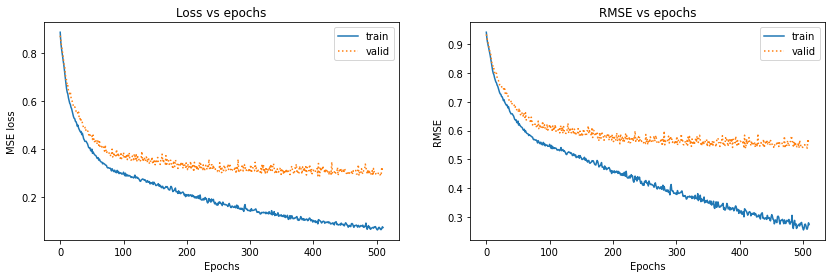

{'loss': 0.3144255578517914, 'root_mean_squared_error': 0.5607365965843201}


In [264]:
#load history from logs
small_multi_history = pd.read_csv("../saved_logs/concentrations/small_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(small_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(small_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(small_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(small_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(small_multi_mlp.evaluate(small_val_dataset, return_dict=True, verbose=0))

### VII.1.b Small correlated dataset

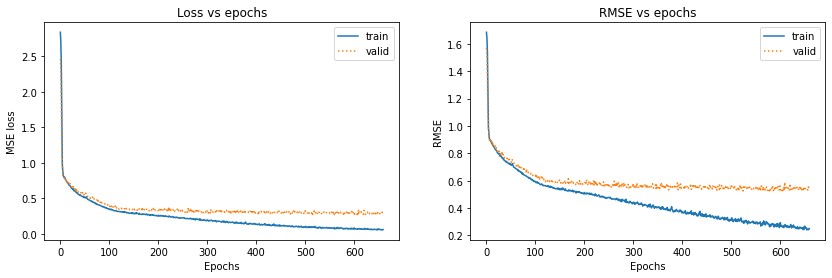

{'loss': 2.527156352996826, 'root_mean_squared_error': 1.5897032022476196}


In [265]:
#load history from logs
small_corr_multi_history = pd.read_csv("../saved_logs/concentrations/small_corr_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(small_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(small_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(small_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(small_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(small_corr_multi_mlp.evaluate(small_corr_val_dataset, return_dict=True, verbose=0))

### VII.1.c Large independent dataset

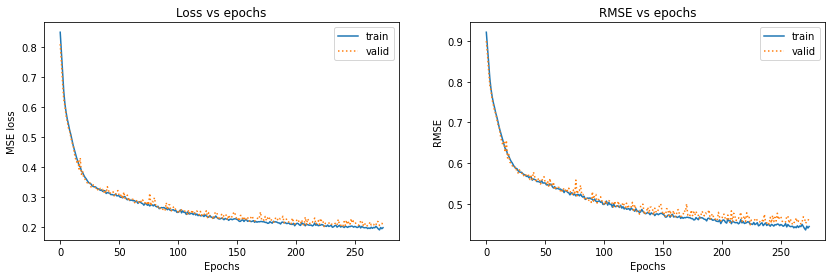

{'loss': 0.9039512872695923, 'root_mean_squared_error': 0.9507635831832886}


In [266]:
#load history from logs
large_multi_history = pd.read_csv("../saved_logs/concentrations/large_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(large_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(large_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(large_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(large_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(large_multi_mlp.evaluate(large_val_dataset, return_dict=True, verbose=0))

### VII.1.d Large correlated dataset

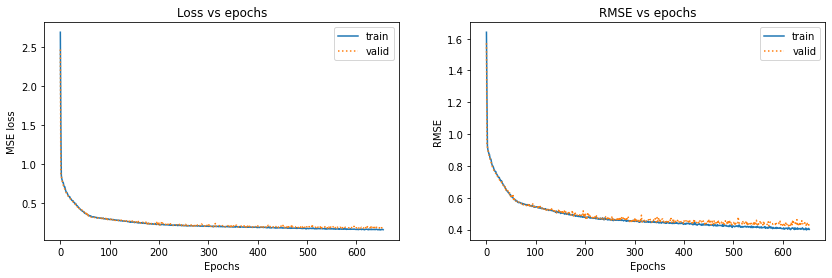

{'loss': 2.8095741271972656, 'root_mean_squared_error': 1.6761784553527832}


In [64]:
#load history from logs
large_corr_multi_history = pd.read_csv("../saved_logs/concentrations/large_corr_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(large_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(large_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(large_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(large_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(large_corr_multi_mlp.evaluate(large_corr_val_dataset, return_dict=True, verbose=0))

### VII.1.e Extra small independent dataset

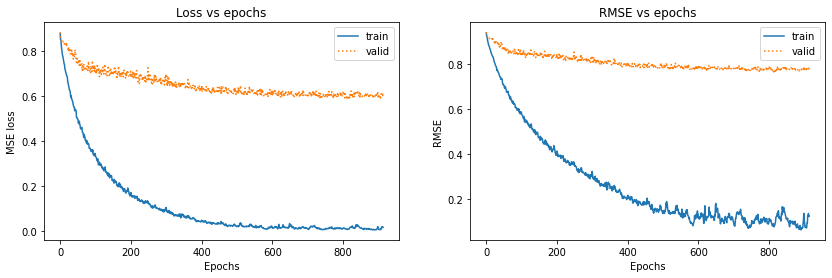

{'loss': 0.6148706674575806, 'root_mean_squared_error': 0.7841368913650513}


In [146]:
#load history from logs
xsmall_multi_history = pd.read_csv("../saved_logs/concentrations/extra_small_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(xsmall_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(xsmall_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(xsmall_multi_mlp.evaluate(xsmall_val_dataset, return_dict=True, verbose=0))

### VII.1.f Extra small correlated dataset

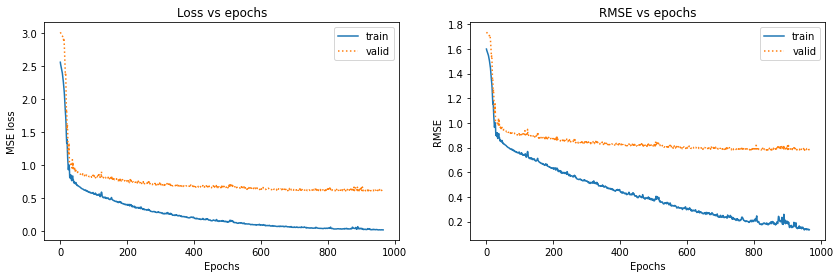

{'loss': 0.6227608919143677, 'root_mean_squared_error': 0.7891519665718079}


In [147]:
#load history from logs
xsmall_corr_multi_history = pd.read_csv("../saved_logs/concentrations/extra_small_corr_multi.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(xsmall_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(xsmall_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(xsmall_corr_multi_mlp.evaluate(xsmall_corr_val_dataset, return_dict=True, verbose=0))

## VII.2 Single Output MLPs

### VII.2.a Small independent dataset

In [ ]:
#load history from logs
small_inde_histories = [pd.read_csv("../saved_logs/concentrations/small_single/metabolite_{}.csv".format(i))
                        for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(small_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(small_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(small_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(small_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(small_inde_mlps[i].evaluate(small_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.2.b Small correlated dataset

In [ ]:
#load history from logs
small_corr_inde_histories = [pd.read_csv("../saved_logs/concentrations/small_corr_single/metabolite_{}.csv".format(i))
                             for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(small_corr_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(small_corr_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(small_corr_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(small_corr_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(small_corr_inde_mlps[i].evaluate(small_corr_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.1.c Large independent dataset

In [ ]:
#load history from logs
large_inde_histories = [pd.read_csv("../saved_logs/concentrations/large_single/metabolite_{}.csv".format(i))
                        for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(large_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(large_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(large_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(large_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(large_inde_mlps[i].evaluate(large_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.1.d Large correlated dataset

In [ ]:
#load history from logs
large_corr_inde_histories = [pd.read_csv("../saved_logs/concentrations/large_corr_single/metabolite_{}.csv".format(i))
                             for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(large_corr_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(large_corr_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(large_corr_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(large_corr_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(large_corr_inde_mlps[i].evaluate(large_corr_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.2.e Extra small independent dataset

{'loss': 0.0014355189632624388, 'root_mean_squared_error': 0.03788824379444122}
{'loss': 0.0005826809210702777, 'root_mean_squared_error': 0.024138784036040306}
{'loss': 0.028286611661314964, 'root_mean_squared_error': 0.1681862473487854}
{'loss': 0.010563580319285393, 'root_mean_squared_error': 0.10277927666902542}
{'loss': 0.0004265621828380972, 'root_mean_squared_error': 0.020653381943702698}
{'loss': 0.025011906400322914, 'root_mean_squared_error': 0.1581515371799469}
{'loss': 0.3670513927936554, 'root_mean_squared_error': 0.6058476567268372}
{'loss': 0.013946162536740303, 'root_mean_squared_error': 0.11809387058019638}
{'loss': 0.05318186804652214, 'root_mean_squared_error': 0.23061193525791168}
{'loss': 1.7111485004425049, 'root_mean_squared_error': 1.3081088066101074}
{'loss': 0.24425804615020752, 'root_mean_squared_error': 0.4942246973514557}
{'loss': 0.17595522105693817, 'root_mean_squared_error': 0.4194701611995697}
{'loss': 0.008616670966148376, 'root_mean_squared_error': 0.

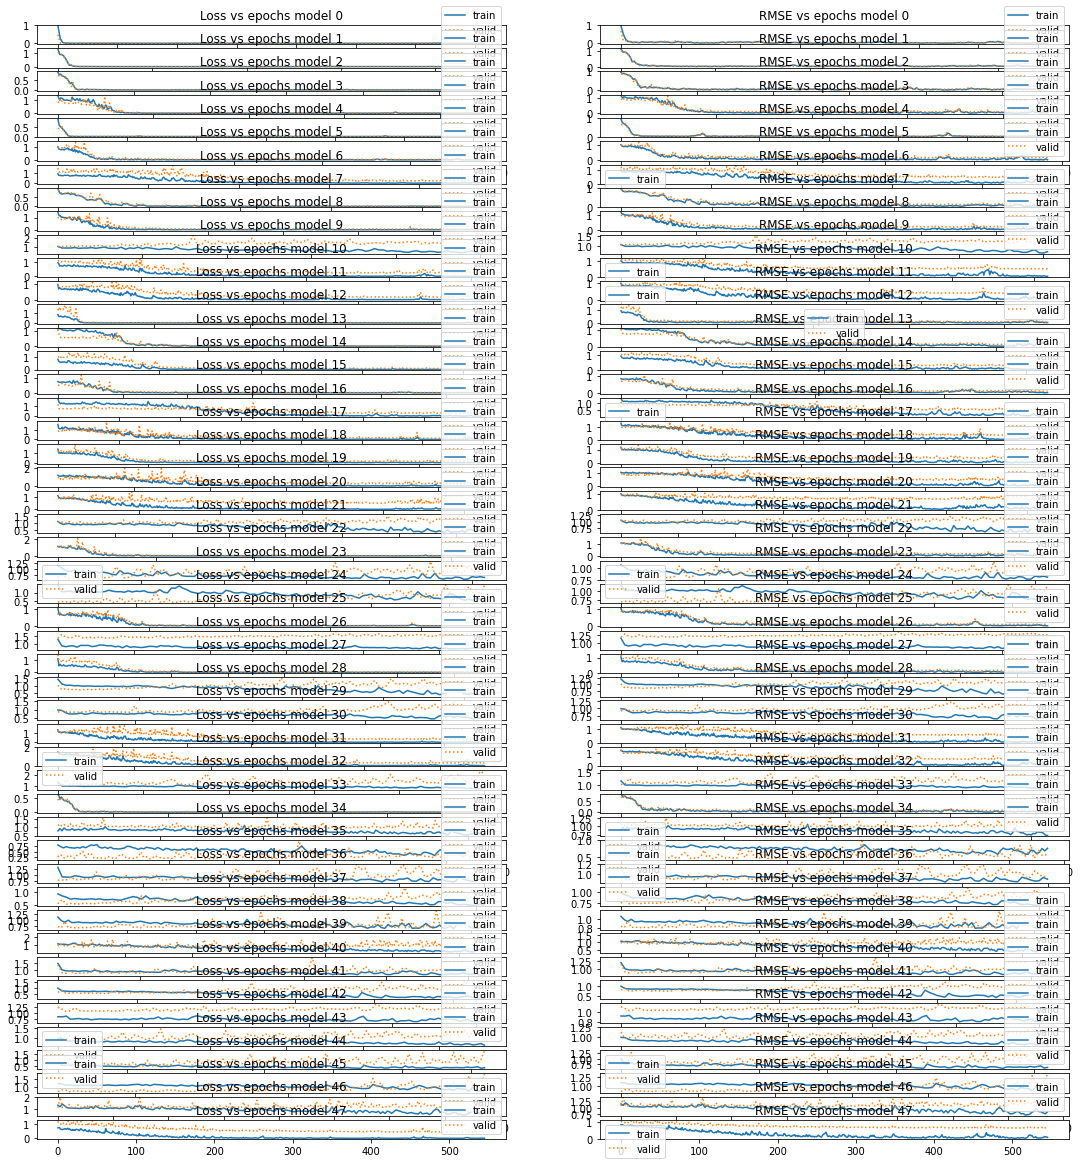

In [148]:
#load history from logs
xsmall_inde_histories = [pd.read_csv("../saved_logs/concentrations/extra_small_single/metabolite_{}.csv".format(i))
                        for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(xsmall_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(xsmall_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(xsmall_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(xsmall_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(xsmall_inde_mlps[i].evaluate(xsmall_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

### VII.2.f Extra small correlated dataset

In [ ]:
#load history from logs
xsmall_corr_inde_histories = [pd.read_csv("../saved_logs/concentrations/extra_small_corr_single/metabolite_{}.csv"
                                          .format(i)) for i in range(48)]

fig, axs = plt.subplots(48, 2)
fig.set_size_inches(18.5, 20.5)

for i in range(48): 
    axs[i, 0].plot(xsmall_corr_inde_histories[i]['loss'], label='train', color='C0', linestyle='-')
    axs[i, 0].plot(xsmall_corr_inde_histories[i]['val_loss'], label='valid', color='C1', linestyle=':')
    axs[i, 0].set_title("Loss vs epochs model {}".format(i))
    axs[i, 0].legend()

    axs[i, 1].plot(xsmall_corr_inde_histories[i]['root_mean_squared_error'],
                   label='train', color='C0', linestyle='-')
    axs[i, 1].plot(xsmall_corr_inde_histories[i]['val_root_mean_squared_error'],
                   label='valid', color='C1', linestyle=':')
    axs[i, 1].set_title("RMSE vs epochs model {}".format(i))
    axs[i, 1].legend()
    
    print(xsmall_corr_inde_mlps[i].evaluate(xsmall_corr_val_datasets_single[i], return_dict=True, verbose=0))

plt.show()

---
# VIII. Load saved models

## VIII.1 Multi Output MLPs

In [59]:
xsmall_multi_status = (tf.train.Checkpoint(model=xsmall_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/extra_small_multi'))
                      .expect_partial())
xsmall_multi_status.assert_existing_objects_matched()
xsmall_corr_multi_status = (tf.train.Checkpoint(model=xsmall_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/extra_small_corr_multi'))
                           .expect_partial())
xsmall_corr_multi_status.assert_existing_objects_matched()
small_multi_status = (tf.train.Checkpoint(model=small_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/small_multi'))
                      .expect_partial())
small_multi_status.assert_existing_objects_matched()
small_corr_multi_status = (tf.train.Checkpoint(model=small_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/small_corr_multi'))
                           .expect_partial())
small_corr_multi_status.assert_existing_objects_matched()
large_multi_status = (tf.train.Checkpoint(model=large_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../saved_models/concentrations/large_multi'))
                      .expect_partial())
large_multi_status.assert_existing_objects_matched()
large_corr_multi_status = (tf.train.Checkpoint(model=large_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../saved_models/concentrations/large_corr_multi'))
                           .expect_partial())

## VIII.2 Multi Output RFs

In [60]:
xsmall_multi_RF = joblib.load('../saved_models/concentrations/xsmall_multi_RF')
xsmall_corr_multi_RF = joblib.load('../saved_models/concentrations/xsmall_corr_multi_RF')
small_multi_RF = joblib.load('../saved_models/concentrations/small_multi_RF')
small_corr_multi_RF = joblib.load('../saved_models/concentrations/small_corr_multi_RF')
large_multi_RF = joblib.load('../saved_models/concentrations/large_multi_RF')
large_corr_multi_RF = joblib.load('../saved_models/concentrations/large_corr_multi_RF')

## VIII.3 Single Output MLPs

In [61]:
xsmall_single_status = []
xsmall_corr_single_status = []
small_single_status = []
small_corr_single_status = []
large_single_status = []
large_corr_single_status = []
for i in range(48):
    xsmall_single_status.append((tf.train.Checkpoint(model=xsmall_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/extra_small_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    xsmall_single_status[i].assert_existing_objects_matched()
    xsmall_corr_single_status.append((tf.train.Checkpoint(model=xsmall_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/extra_small_corr_single/metabolite_{}'
                                         .format(i)))
                                     .expect_partial()))
    xsmall_corr_single_status[i].assert_existing_objects_matched()
    small_single_status.append((tf.train.Checkpoint(model=small_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/small_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    small_single_status[i].assert_existing_objects_matched()
    small_corr_single_status.append((tf.train.Checkpoint(model=small_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/small_corr_single/metabolite_{}'.format(i)))
                                     .expect_partial()))
    small_corr_single_status[i].assert_existing_objects_matched()
    large_single_status.append((tf.train.Checkpoint(model=large_inde_mlps[i])
                                .restore(tf.train.latest_checkpoint(
                                    '../saved_models/concentrations/large_single/metabolite_{}'.format(i)))
                                .expect_partial()))
    large_single_status[i].assert_existing_objects_matched()
    large_corr_single_status.append((tf.train.Checkpoint(model=large_corr_inde_mlps[i])
                                     .restore(tf.train.latest_checkpoint(
                                         '../saved_models/concentrations/large_corr_single/metabolite_{}'.format(i)))
                                     .expect_partial()))
    large_corr_single_status[i].assert_existing_objects_matched()

## VIII.4 Single Output RFs

In [103]:
xsmall_inde_RFs = []
xsmall_corr_inde_RFs = []
small_inde_RFs = []
small_corr_inde_RFs = []
large_inde_RFs = []
large_corr_inde_RFs = []
for i in range(48):
    xsmall_inde_RFs.append(joblib.load('../saved_models/concentrations/xsmall_single_RF/metabolite_{}'.format(i)))
    xsmall_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/xsmall_corr_single_RF/metabolite_{}'
                                           .format(i)))
    small_inde_RFs.append(joblib.load('../saved_models/concentrations/small_single_RF/metabolite_{}'.format(i)))
    small_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/small_corr_single_RF/metabolite_{}'
                                           .format(i)))
    large_inde_RFs.append(joblib.load('../saved_models/concentrations/large_single_RF/metabolite_{}'.format(i)))
    large_corr_inde_RFs.append(joblib.load('../saved_models/concentrations/large_corr_single_RF/metabolite_{}'
                                           .format(i)))

## VIII.5 Partial Least Squares

In [62]:
xsmall_pls = joblib.load('../saved_models/concentrations/xsmall_pls')
xsmall_corr_pls = joblib.load('../saved_models/concentrations/xsmall_corr_pls')
small_pls = joblib.load('../saved_models/concentrations/small_pls')
small_corr_pls = joblib.load('../saved_models/concentrations/small_corr_pls')
large_pls = joblib.load('../saved_models/concentrations/large_pls')
large_corr_pls = joblib.load('../saved_models/concentrations/large_corr_pls')

---
# XI. Performances:

## Plot the concentrations for a random exmple of the validation dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)

filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

metab_number = range(48)
for parsed_record in val_dataset.shuffle(1000).take(1):
    true_concentration = parsed_record[1][0].numpy()
    pred_concentration = simple_model(parsed_record[0])[0].numpy()


fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)

ax1.bar(metab_number,true_concentration)
ax1.set_title("True concentrations")
ax1.set_ylim(0, 14000)

ax2.bar(metab_number, pred_concentration)
ax2.set_title("Pred concentrations")
ax2.set_ylim(0, 14000)

ax3.bar(metab_number, mean_concentrations)
ax3.set_title("Mean concentrations")
ax3.set_ylim(0, 14000)

plt.show()

print(metabolites)



## XI.1. Total RMSE on independent dataset

In [199]:
inde_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=small_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                           y_pred=large_corr_multi_RF.predict(norm_df_spectrum_test))).numpy()


inde_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=small_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                      y_pred=large_pls.predict(norm_df_spectrum_test))).numpy()
inde_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_test))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                             y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                     y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                             y_pred=small_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                     y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                             y_pred=large_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test[i],
#                                                     y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test))
#                                         for i in range(48)]).numpy()    


inde_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
inde_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
inde_rmse_small_multi_mlp = small_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
inde_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [200]:
models = ['MLP multi-output',
          'RF multi-output',
          'MLP single-output',
          'PLS']

training_datasets = ['Extra small independent', 'Extra small correlated',
                     'Small independent', 'Small correlated',
                     'Large independent', 'Large correlated']

total_rmse_inde = [[inde_rmse_xsmall_multi_mlp, inde_rmse_xsmall_corr_multi_mlp, inde_rmse_small_multi_mlp,
                   inde_rmse_small_corr_multi_mlp, inde_rmse_large_multi_mlp, inde_rmse_large_corr_multi_mlp],
                  [inde_rmse_xsmall_multi_rf, inde_rmse_xsmall_corr_multi_rf, inde_rmse_small_multi_rf,
                   inde_rmse_small_corr_multi_rf, inde_rmse_large_multi_rf, inde_rmse_large_corr_multi_rf],
                  [inde_rmse_xsmall_single_mlp, inde_rmse_xsmall_corr_single_mlp, inde_rmse_small_single_mlp,
                   inde_rmse_small_corr_single_mlp, inde_rmse_large_single_mlp, inde_rmse_large_corr_single_mlp],
                  [inde_rmse_xsmall_pls, inde_rmse_xsmall_corr_pls, inde_rmse_small_pls,
                   inde_rmse_small_corr_pls, inde_rmse_large_pls, inde_rmse_large_corr_pls]]

In [201]:
table_total_rmse_inde = pd.DataFrame(total_rmse_inde,
                                     index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_inde.style.set_caption("Total RMSE evaluated on simulated normal urine with independent metbaolites")

## XI.2. Total RMSE on correlated dataset

In [202]:
corr_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=small_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=large_corr_multi_RF.predict(norm_df_spectrum_test_corr))).numpy()


corr_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=small_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                      y_pred=large_pls.predict(norm_df_spectrum_test_corr))).numpy()
corr_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_test_corr))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                     y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                 y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                     y_pred=small_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                 y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                     y_pred=large_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
#                                                 y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test_corr))
#                                         for i in range(48)]).numpy()    


corr_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
corr_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()

corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
corr_rmse_small_multi_mlp = small_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
corr_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [203]:
total_rmse_corr = [[corr_rmse_xsmall_multi_mlp, corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_multi_mlp,
                   corr_rmse_small_corr_multi_mlp, corr_rmse_large_multi_mlp, corr_rmse_large_corr_multi_mlp],
                  [corr_rmse_xsmall_multi_rf, corr_rmse_xsmall_corr_multi_rf, corr_rmse_small_multi_rf,
                   corr_rmse_small_corr_multi_rf, corr_rmse_large_multi_rf, corr_rmse_large_corr_multi_rf],
                  [corr_rmse_xsmall_single_mlp, corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_single_mlp,
                   corr_rmse_small_corr_single_mlp, corr_rmse_large_single_mlp, corr_rmse_large_corr_single_mlp],
                  [corr_rmse_xsmall_pls, corr_rmse_xsmall_corr_pls, corr_rmse_small_pls,
                   corr_rmse_small_corr_pls, corr_rmse_large_pls, corr_rmse_large_corr_pls]]

In [204]:
table_total_rmse_corr = pd.DataFrame(total_rmse_corr, index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_corr.style.set_caption("Total RMSE evaluated on simulated normal urine with correlated metbaolites")

## XI.3. Total RMSE on abnormal independent dataset

In [196]:
abn_inde_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=small_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                  y_pred=large_corr_multi_RF.predict(norm_df_spectrum_abn_test))).numpy()


abn_inde_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=small_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                      y_pred=large_pls.predict(norm_df_spectrum_abn_test))).numpy()
abn_inde_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_abn_test))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                   y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                   y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                             y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                     y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                             y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
#                                                     y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test))
#                                         for i in range(48)]).numpy()   


abn_inde_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_inde_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


abn_inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_inde_rmse_small_multi_mlp = small_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_inde_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [205]:
total_rmse_abn_inde = [[abn_inde_rmse_xsmall_multi_mlp, abn_inde_rmse_xsmall_corr_multi_mlp, abn_inde_rmse_small_multi_mlp,
                   abn_inde_rmse_small_corr_multi_mlp, abn_inde_rmse_large_multi_mlp, abn_inde_rmse_large_corr_multi_mlp],
                  [abn_inde_rmse_xsmall_multi_rf, abn_inde_rmse_xsmall_corr_multi_rf, abn_inde_rmse_small_multi_rf,
                   abn_inde_rmse_small_corr_multi_rf, abn_inde_rmse_large_multi_rf, abn_inde_rmse_large_corr_multi_rf],
                  [abn_inde_rmse_xsmall_single_mlp, abn_inde_rmse_xsmall_corr_single_mlp, abn_inde_rmse_small_single_mlp,
                   abn_inde_rmse_small_corr_single_mlp, abn_inde_rmse_large_single_mlp, abn_inde_rmse_large_corr_single_mlp],
                  [abn_inde_rmse_xsmall_pls, abn_inde_rmse_xsmall_corr_pls, abn_inde_rmse_small_pls,
                   abn_inde_rmse_small_corr_pls, abn_inde_rmse_large_pls, abn_inde_rmse_large_corr_pls]]

In [206]:
table_total_rmse_abn_inde = pd.DataFrame(total_rmse_abn_inde, index=pd.Index(models, name='Models'),
                                   columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_inde.style.set_caption("Total RMSE evaluated on simulated abnormal urine with independent metbaolites")

## XI.4. Total RMSE on abnromal correlated dataset

In [193]:
abn_corr_rmse_xsmall_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=xsmall_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_xsmall_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=small_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=small_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=large_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_corr_multi_rf = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                y_pred=large_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr))).numpy()


abn_corr_rmse_xsmall_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=xsmall_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_xsmall_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=xsmall_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=small_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_small_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=small_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                      y_pred=large_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()
abn_corr_rmse_large_corr_pls = tf.math.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr,
                                                    y_pred=large_corr_pls.predict(norm_df_spectrum_abn_test_corr))).numpy()


# rmse_xsmall_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                     y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_xsmall_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                 y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                     y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_small_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                 y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                     y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()
# rmse_large_corr_single_rf = tf.math.sqrt(tf.math.reduce_mean([mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
#                                                 y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr))
#                                         for i in range(48)]).numpy()     


abn_corr_rmse_xsmall_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_xsmall_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([xsmall_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_small_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_small_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([small_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_large_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                    return_dict=True,
                                                                    verbose=0)['loss'] for i in range(48)])).numpy()
abn_corr_rmse_large_corr_single_mlp = tf.math.sqrt(tf.math.reduce_mean([large_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                                              return_dict=True,
                                                                              verbose=0)['loss'] for i in range(48)])).numpy()


abn_corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_corr_rmse_small_multi_mlp = small_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_corr_rmse_small_corr_multi_mlp = small_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [197]:
total_rmse_abn_corr = [[abn_corr_rmse_xsmall_multi_mlp, abn_corr_rmse_xsmall_corr_multi_mlp, abn_corr_rmse_small_multi_mlp,
                   abn_corr_rmse_small_corr_multi_mlp, abn_corr_rmse_large_multi_mlp, abn_corr_rmse_large_corr_multi_mlp],
                  [abn_corr_rmse_xsmall_multi_rf, abn_corr_rmse_xsmall_corr_multi_rf, abn_corr_rmse_small_multi_rf,
                   abn_corr_rmse_small_corr_multi_rf, abn_corr_rmse_large_multi_rf, abn_corr_rmse_large_corr_multi_rf],
                  [abn_corr_rmse_xsmall_single_mlp, abn_corr_rmse_xsmall_corr_single_mlp, abn_corr_rmse_small_single_mlp,
                   abn_corr_rmse_small_corr_single_mlp, abn_corr_rmse_large_single_mlp, abn_corr_rmse_large_corr_single_mlp],
                  [abn_corr_rmse_xsmall_pls, abn_corr_rmse_xsmall_corr_pls, abn_corr_rmse_small_pls,
                   abn_corr_rmse_small_corr_pls, abn_corr_rmse_large_pls, abn_corr_rmse_large_corr_pls]]

In [207]:
table_total_rmse_abn_corr = pd.DataFrame(total_rmse_abn_corr, index=pd.Index(models, name='Models'),
                                         columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_corr.style.set_caption("Total RMSE evaluated on simulated abnormal urine with correlated metbaolites")

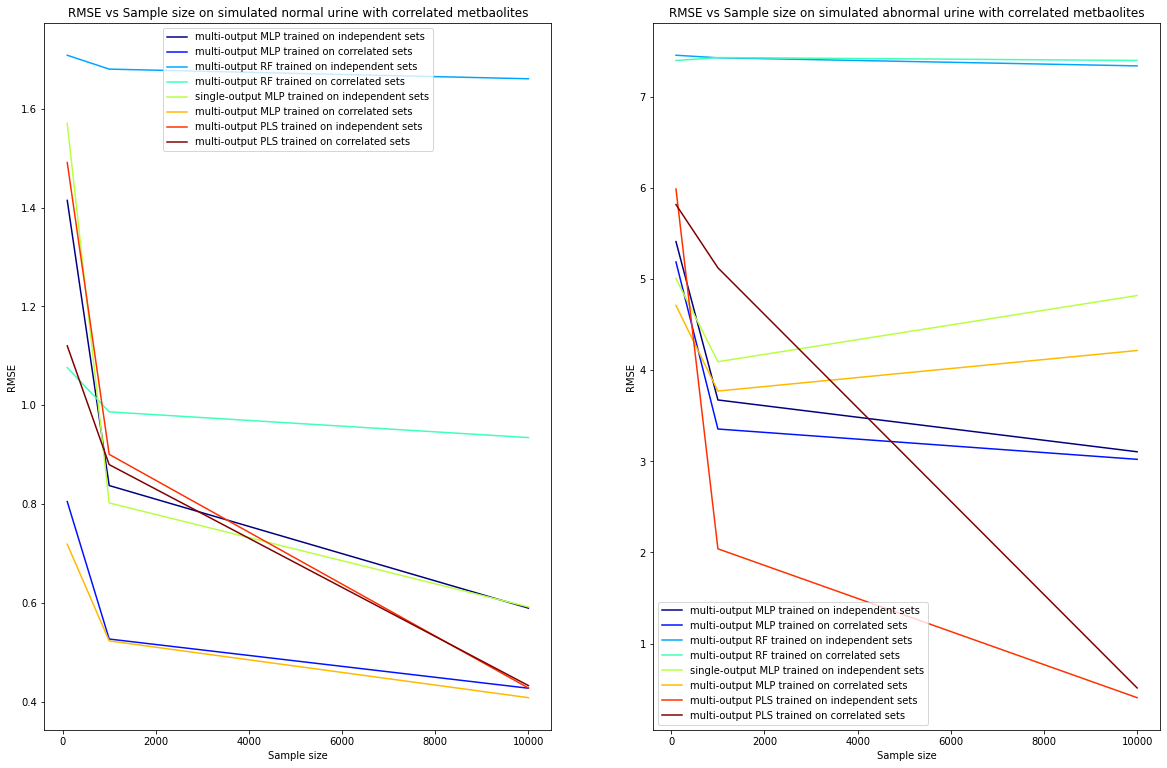

In [230]:
sample_sizes = [100, 1000, 10000]
# inde_mlp_multi_abn_inde = [abn_inde_rmse_xsmall_multi_mlp, abn_inde_rmse_small_multi_mlp, abn_inde_rmse_large_multi_mlp]
# inde_RF_multi_abn_inde = [abn_inde_rmse_xsmall_multi_rf, abn_inde_rmse_small_multi_rf, abn_inde_rmse_large_multi_rf]
# inde_mlp_single_abn_inde = [abn_inde_rmse_xsmall_single_mlp, abn_inde_rmse_small_single_mlp, abn_inde_rmse_large_single_mlp]
# inde_pls_multi_abn_inde = [abn_inde_rmse_xsmall_pls, abn_inde_rmse_small_pls, abn_inde_rmse_large_pls]
# corr_mlp_multi_abn_inde = [abn_inde_rmse_xsmall_corr_multi_mlp, abn_inde_rmse_small_corr_multi_mlp, abn_inde_rmse_large_corr_multi_mlp]
# corr_RF_multi_abn_inde = [abn_inde_rmse_xsmall_corr_multi_rf, abn_inde_rmse_small_corr_multi_rf, abn_inde_rmse_large_corr_multi_rf]
# corr_mlp_single_abn_inde = [abn_inde_rmse_xsmall_corr_single_mlp, abn_inde_rmse_small_corr_single_mlp, abn_inde_rmse_large_corr_single_mlp]
# corr_pls_multi_abn_inde = [abn_inde_rmse_xsmall_corr_pls, abn_inde_rmse_small_corr_pls, abn_inde_rmse_large_corr_pls]

inde_mlp_multi_abn_corr = [abn_corr_rmse_xsmall_multi_mlp, abn_corr_rmse_small_multi_mlp, abn_corr_rmse_large_multi_mlp]
inde_RF_multi_abn_corr = [abn_corr_rmse_xsmall_multi_rf, abn_corr_rmse_small_multi_rf, abn_corr_rmse_large_multi_rf]
inde_mlp_single_abn_corr = [abn_corr_rmse_xsmall_single_mlp, abn_corr_rmse_small_single_mlp, abn_corr_rmse_large_single_mlp]
inde_pls_multi_abn_corr = [abn_corr_rmse_xsmall_pls, abn_corr_rmse_small_pls, abn_corr_rmse_large_pls]
corr_mlp_multi_abn_corr = [abn_corr_rmse_xsmall_corr_multi_mlp, abn_corr_rmse_small_corr_multi_mlp, abn_corr_rmse_large_corr_multi_mlp]
corr_RF_multi_abn_corr = [abn_corr_rmse_xsmall_corr_multi_rf, abn_corr_rmse_small_corr_multi_rf, abn_corr_rmse_large_corr_multi_rf]
corr_mlp_single_abn_corr = [abn_corr_rmse_xsmall_corr_single_mlp, abn_corr_rmse_small_corr_single_mlp, abn_corr_rmse_large_corr_single_mlp]
corr_pls_multi_abn_corr = [abn_corr_rmse_xsmall_corr_pls, abn_corr_rmse_small_corr_pls, abn_corr_rmse_large_corr_pls]

inde_mlp_multi_corr = [corr_rmse_xsmall_multi_mlp, corr_rmse_small_multi_mlp, corr_rmse_large_multi_mlp]
inde_RF_multi_corr = [corr_rmse_xsmall_multi_rf, corr_rmse_small_multi_rf, corr_rmse_large_multi_rf]
inde_mlp_single_corr = [corr_rmse_xsmall_single_mlp, corr_rmse_small_single_mlp, corr_rmse_large_single_mlp]
inde_pls_multi_corr = [corr_rmse_xsmall_pls, corr_rmse_small_pls, corr_rmse_large_pls]
corr_mlp_multi_corr = [corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_corr_multi_mlp, corr_rmse_large_corr_multi_mlp]
corr_RF_multi_corr = [corr_rmse_xsmall_corr_multi_rf, corr_rmse_small_corr_multi_rf, corr_rmse_large_corr_multi_rf]
corr_mlp_single_corr = [corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_corr_single_mlp, corr_rmse_large_corr_single_mlp]
corr_pls_multi_corr = [corr_rmse_xsmall_corr_pls, corr_rmse_small_corr_pls, corr_rmse_large_corr_pls]


colors = plt.cm.jet(np.linspace(0,1,8))

fig = plt.figure(figsize=(20, 13))

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
plt.plot(sample_sizes, inde_RF_multi_corr, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
plt.plot(sample_sizes, corr_RF_multi_corr, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
plt.plot(sample_sizes, inde_mlp_single_corr, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
plt.plot(sample_sizes, corr_mlp_single_corr, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
plt.plot(sample_sizes, inde_pls_multi_corr, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
plt.plot(sample_sizes, corr_pls_multi_corr, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()
# fig.add_subplot(121)
# plt.plot(sample_sizes, inde_mlp_multi_abn_inde, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
# plt.plot(sample_sizes, corr_mlp_multi_abn_inde, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
# plt.plot(sample_sizes, inde_RF_multi_abn_inde, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
# plt.plot(sample_sizes, corr_RF_multi_abn_inde, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
# plt.plot(sample_sizes, inde_mlp_single_abn_inde, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
# plt.plot(sample_sizes, corr_mlp_single_abn_inde, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
# plt.plot(sample_sizes, inde_pls_multi_abn_inde, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
# plt.plot(sample_sizes, corr_pls_multi_abn_inde, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
# plt.title("RMSE vs Sample size on simulated abnormal urine with independent metbaolites")
# plt.xlabel("Sample size")
# plt.ylabel("RMSE")
# plt.legend()

fig.add_subplot(122)
plt.plot(sample_sizes, inde_mlp_multi_abn_corr, label='multi-output MLP trained on independent sets', color=colors[0], linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_abn_corr, label='multi-output MLP trained on correlated sets', color=colors[1], linestyle='-')
plt.plot(sample_sizes, inde_RF_multi_abn_corr, label='multi-output RF trained on independent sets', color=colors[2], linestyle='-')
plt.plot(sample_sizes, corr_RF_multi_abn_corr, label='multi-output RF trained on correlated sets', color=colors[3], linestyle='-')
plt.plot(sample_sizes, inde_mlp_single_abn_corr, label='single-output MLP trained on independent sets', color=colors[4], linestyle='-')
plt.plot(sample_sizes, corr_mlp_single_abn_corr, label='multi-output MLP trained on correlated sets', color=colors[5], linestyle='-')
plt.plot(sample_sizes, inde_pls_multi_abn_corr, label='multi-output PLS trained on independent sets', color=colors[6], linestyle='-')
plt.plot(sample_sizes, corr_pls_multi_abn_corr, label='multi-output PLS trained on correlated sets', color=colors[7], linestyle='-')
plt.title("RMSE vs Sample size on simulated abnormal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

plt.show()

In [ ]:
sample_sizes = [100, 1000, 10000]
inde_mlp_multi_inde = [inde_rmse_xsmall_multi_mlp, inde_rmse_small_multi_mlp, inde_rmse_large_multi_mlp]
inde_RF_multi_inde = [inde_rmse_xsmall_multi_RF, inde_rmse_small_multi_RF, inde_rmse_large_multi_RF]
inde_mlp_single_inde = [inde_rmse_xsmall_single_mlp, inde_rmse_small_single_mlp, inde_rmse_large_single_mlp]
inde_pls_multi_inde = [inde_rmse_xsmall_pls, inde_rmse_small_pls, inde_rmse_large_pls]
corr_mlp_multi_inde = [inde_rmse_xsmall_inde_multi_mlp, inde_rmse_small_inde_multi_mlp, inde_rmse_large_corr_multi_mlp]
corr_RF_multi_inde = [inde_rmse_xsmall_inde_multi_RF, ande_rmse_small_inde_multi_RF, inde_rmse_large_corr_multi_RF]
corr_mlp_single_inde = [inde_rmse_xsmall_inde_single_mlp, inde_rmse_small_inde_single_mlp, inde_rmse_large_corr_single_mlp]
corr_pls_multi_inde = [inde_rmse_xsmall_inde_pls, inde_rmse_small_corr_pls, inde_rmse_large_corr_pls]

inde_mlp_multi_corr = [corr_rmse_xsmall_multi_mlp, corr_rmse_small_multi_mlp, corr_rmse_large_multi_mlp]
inde_RF_multi_corr = [corr_rmse_xsmall_multi_RF, corr_rmse_small_multi_RF, corr_rmse_large_multi_RF]
inde_mlp_single_corr = [corr_rmse_xsmall_single_mlp, corr_rmse_small_single_mlp, corr_rmse_large_single_mlp]
inde_pls_multi_corr = [corr_rmse_xsmall_pls, corr_rmse_small_pls, corr_rmse_large_pls]
corr_mlp_multi_corr = [corr_rmse_xsmall_corr_multi_mlp, corr_rmse_small_corr_multi_mlp, corr_rmse_large_corr_multi_mlp]
corr_RF_multi_corr = [corr_rmse_xsmall_corr_multi_RF, corr_rmse_small_corr_multi_RF, corr_rmse_large_corr_multi_RF]
corr_mlp_single_corr = [corr_rmse_xsmall_corr_single_mlp, corr_rmse_small_corr_single_mlp, corr_rmse_large_corr_single_mlp]
corr_pls_multi_corr = [corr_rmse_xsmall_corr_pls, corr_rmse_small_corr_pls, corr_rmse_large_corr_pls]

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output MLP trained on independent sets', color='C0', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output RF trained on independent sets', color='C1', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='single-output MLP trained on independent sets', color='C2', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_inde, label='multi-output PLS trained on independent sets', color='C3', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_inde, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with independent metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

fig.add_subplot(121)
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output MLP trained on independent sets', color='C0', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output RF trained on independent sets', color='C1', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='single-output MLP trained on independent sets', color='C2', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.plot(sample_sizes, inde_mlp_multi_corr, label='multi-output PLS trained on independent sets', color='C3', linestyle='-')
plt.plot(sample_sizes, corr_mlp_multi_corr, label='multi-output MLP trained on correlated sets', color='C0', linestyle='-')
plt.title("RMSE vs Sample size on simulated normal urine with correlated metbaolites")
plt.xlabel("Sample size")
plt.ylabel("RMSE")
plt.legend()

plt.show()

## XI.4. Metabolite wise $R^{2}$ on independent dataset

### XI.4.a Import mean concentration data and metabolites

In [120]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.4.b Extract ground truth from validation set

In [121]:
true_val = []
for batch in test_dataset:
    true_val.append(batch[1])
y_val = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [122]:
inde_SS_total = tf.reduce_mean(tf.math.square(y_val), axis=0).numpy()
inde_SS_total = pd.Series(inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.4.c Multi output MLPs

In [123]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(test_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_dataset)


inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_multi_mlp), axis=0).numpy()
inde_R_xsmall_multi_mlp = 1 - inde_SS_res_xsmall_multi_mlp/inde_SS_total
inde_R_xsmall_multi_mlp = pd.Series(inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_xsmall_corr_multi_mlp = 1 - inde_SS_res_xsmall_corr_multi_mlp/inde_SS_total
inde_R_xsmall_corr_multi_mlp = pd.Series(inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

inde_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_small_multi_mlp), axis=0).numpy()
inde_R_small_multi_mlp = 1 - inde_SS_res_small_multi_mlp/inde_SS_total
inde_R_small_multi_mlp = pd.Series(inde_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

inde_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_small_corr_multi_mlp = 1 - inde_SS_res_small_corr_multi_mlp/inde_SS_total
inde_R_small_corr_multi_mlp = pd.Series(inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_multi_mlp), axis=0).numpy()
inde_R_large_multi_mlp = 1 - inde_SS_res_large_multi_mlp/inde_SS_total
inde_R_large_multi_mlp = pd.Series(inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_large_corr_multi_mlp = 1 - inde_SS_res_large_corr_multi_mlp/inde_SS_total
inde_R_large_corr_multi_mlp = pd.Series(inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.4.d Multi output RFs

In [124]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_test)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_test)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_test)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_test)

inde_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_multi_RF), axis=0).numpy()
inde_R_xsmall_multi_RF = 1 - inde_SS_res_xsmall_multi_RF/inde_SS_total
inde_R_xsmall_multi_RF = pd.Series(inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

inde_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_xsmall_corr_multi_RF = 1 - inde_SS_res_xsmall_corr_multi_RF/inde_SS_total
inde_R_xsmall_corr_multi_RF = pd.Series(inde_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

inde_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_small_multi_RF), axis=0).numpy()
inde_R_small_multi_RF = 1 - inde_SS_res_small_multi_RF/inde_SS_total
inde_R_small_multi_RF = pd.Series(inde_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

inde_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_small_corr_multi_RF = 1 - inde_SS_res_small_corr_multi_RF/inde_SS_total
inde_R_small_corr_multi_RF = pd.Series(inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

inde_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_large_multi_RF), axis=0).numpy()
inde_R_large_multi_RF = 1 - inde_SS_res_large_multi_RF/inde_SS_total
inde_R_large_multi_RF = pd.Series(inde_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

inde_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
inde_R_large_corr_multi_RF = 1 - inde_SS_res_large_corr_multi_RF/inde_SS_total
inde_R_large_corr_multi_RF = pd.Series(inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.4.e Single output MLPs

In [125]:
inde_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_xsmall_single_mlp = 1 - inde_SS_res_xsmall_single_mlp/inde_SS_total
inde_R_xsmall_single_mlp = pd.Series(inde_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

inde_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_xsmall_corr_single_mlp = 1 - inde_SS_res_xsmall_corr_single_mlp/inde_SS_total
inde_R_xsmall_corr_single_mlp = pd.Series(inde_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

inde_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_small_single_mlp = 1 - inde_SS_res_small_single_mlp/inde_SS_total
inde_R_small_single_mlp = pd.Series(inde_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

inde_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_small_corr_single_mlp = 1 - inde_SS_res_small_corr_single_mlp/inde_SS_total
inde_R_small_corr_single_mlp = pd.Series(inde_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

inde_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_large_single_mlp = 1 - inde_SS_res_large_single_mlp/inde_SS_total
inde_R_large_single_mlp = pd.Series(inde_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

inde_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
inde_R_large_corr_single_mlp = 1 - inde_SS_res_large_corr_single_mlp/inde_SS_total
inde_R_large_corr_single_mlp = pd.Series(inde_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.4.f Single output RFs

In [ ]:
inde_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_xsmall_single_RF = pd.Series(inde_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

inde_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_xsmall_corr_single_RF = pd.Series(inde_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

inde_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=small_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_small_single_RF = pd.Series(inde_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

inde_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_small_corr_single_RF = pd.Series(inde_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

inde_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                          y_pred=large_single_RFs[i].predict(norm_df_spectrum_test)))
                               for i in range(48)]
inde_ew_rmse_large_single_RF = pd.Series(inde_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

inde_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test[i],
                                                    y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test)))
                                    for i in range(48)]
inde_ew_rmse_large_corr_single_RF = pd.Series(inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.4.g PLS

In [126]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_test)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_test)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_test)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_test)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_test)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_test)


inde_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_pls), axis=0).numpy()
inde_R_xsmall_pls = 1 - inde_SS_res_xsmall_multi_RF/inde_SS_total
inde_R_xsmall_pls = pd.Series(inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

inde_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
inde_R_xsmall_corr_pls = 1 - inde_SS_res_xsmall_corr_pls/inde_SS_total
inde_R_xsmall_corr_pls = pd.Series(inde_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

inde_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_small_pls), axis=0).numpy()
inde_R_small_pls = 1 - inde_SS_res_small_pls/inde_SS_total
inde_R_small_pls = pd.Series(inde_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

inde_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_small_corr_pls),
                                                  axis=0).numpy()
inde_R_small_corr_pls = 1 - inde_SS_res_small_corr_pls/inde_SS_total
inde_R_small_corr_pls = pd.Series(inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

inde_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_large_pls), axis=0).numpy()
inde_R_large_pls = 1 - inde_SS_res_large_pls/inde_SS_total
inde_R_large_pls = pd.Series(inde_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

inde_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_pls),
                                                  axis=0).numpy()
inde_R_large_corr_pls = 1 - inde_SS_res_large_corr_pls/inde_SS_total
inde_R_large_corr_pls = pd.Series(inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.4.i Create the table

In [ ]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
(summary_table_small.style
  .background_gradient(cmap=cm))

In [127]:
def color_traget(cell):
    colors = ['lightgreen' if cell[i] > 0 else 'lightcoral' for i in range(8)] + ['white']
    return ['background-color: %s' % color for color in colors]


def font_min_RMSE(cell):
    fonts = ['bold' if (1 - cell[i]) == min(1 - cell[:8]) else '' for i in range (8)] + ['']
    return ['font-weight: %s' % font for font in fonts]

In [128]:
# target = pd.Series(mean_concentrations/sd_concentrations * 0.3, index=metabolites, name='Target RMSE')

summary_table_xsmall = pd.concat([inde_R_xsmall_multi_mlp, inde_R_xsmall_single_mlp,
                                  inde_R_xsmall_multi_RF, inde_R_xsmall_pls,
                                  inde_R_xsmall_corr_multi_mlp, inde_R_xsmall_corr_single_mlp, 
                                  inde_R_xsmall_corr_multi_RF, inde_R_xsmall_corr_pls,
                                  inde_SS_total], axis=1)
summary_table_small = pd.concat([inde_R_small_multi_mlp, inde_R_small_single_mlp,
                                 inde_R_small_multi_RF, inde_R_small_pls,
                                 inde_R_small_corr_multi_mlp, inde_R_small_corr_single_mlp,
                                 inde_R_small_corr_multi_RF, inde_R_small_corr_pls,
                                 inde_SS_total], axis=1)
summary_table_large = pd.concat([inde_R_large_multi_mlp, inde_R_large_single_mlp,
                                 inde_R_large_multi_RF, inde_R_large_pls,
                                 inde_R_large_corr_multi_mlp, inde_R_large_corr_single_mlp,
                                 inde_R_large_corr_multi_RF, inde_R_large_corr_pls,
                                 inde_SS_total], axis=1)

In [129]:
summary_table_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [130]:
summary_table_small.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [131]:
summary_table_large.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

## XI.5. Metabolite wise RMSE on correlated dataset

### XI.5.a Import mean concentration data and metabolites

In [132]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.5.b Extract ground truth from validation set

In [133]:
true_val = []
for batch in test_corr_dataset:
    true_val.append(batch[1])
y_val_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [134]:
corr_SS_total = tf.reduce_mean(tf.math.square(y_val_corr), axis=0).numpy()
corr_SS_total = pd.Series(corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.5.c Multi output MLPs

In [135]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_corr_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(test_corr_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_corr_dataset)



corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_multi_mlp), axis=0).numpy()
corr_R_xsmall_multi_mlp = 1 - corr_SS_res_xsmall_multi_mlp/corr_SS_total
corr_R_xsmall_multi_mlp = pd.Series(corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_xsmall_corr_multi_mlp = 1 - corr_SS_res_xsmall_corr_multi_mlp/corr_SS_total
corr_R_xsmall_corr_multi_mlp = pd.Series(corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

corr_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_multi_mlp), axis=0).numpy()
corr_R_small_multi_mlp = 1 - corr_SS_res_small_multi_mlp/corr_SS_total
corr_R_small_multi_mlp = pd.Series(corr_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

corr_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_small_corr_multi_mlp = 1 - corr_SS_res_small_corr_multi_mlp/corr_SS_total
corr_R_small_corr_multi_mlp = pd.Series(corr_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_multi_mlp), axis=0).numpy()
corr_R_large_multi_mlp = 1 - corr_SS_res_large_multi_mlp/corr_SS_total
corr_R_large_multi_mlp = pd.Series(corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_large_corr_multi_mlp = 1 - corr_SS_res_large_corr_multi_mlp/corr_SS_total
corr_R_large_corr_multi_mlp = pd.Series(corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.5.d Multi output RFs

In [136]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_test_corr)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_test_corr)


corr_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_multi_RF), axis=0).numpy()
corr_R_xsmall_multi_RF = 1 - corr_SS_res_xsmall_multi_RF/corr_SS_total
corr_R_xsmall_multi_RF = pd.Series(corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

corr_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_xsmall_corr_multi_RF = 1 - corr_SS_res_xsmall_corr_multi_RF/corr_SS_total
corr_R_xsmall_corr_multi_RF = pd.Series(corr_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

corr_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_multi_RF), axis=0).numpy()
corr_R_small_multi_RF = 1 - corr_SS_res_small_multi_RF/corr_SS_total
corr_R_small_multi_RF = pd.Series(corr_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

corr_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_small_corr_multi_RF = 1 - corr_SS_res_small_corr_multi_RF/corr_SS_total
corr_R_small_corr_multi_RF = pd.Series(corr_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

corr_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_multi_RF), axis=0).numpy()
corr_R_large_multi_RF = 1 - corr_SS_res_large_multi_RF/corr_SS_total
corr_R_large_multi_RF = pd.Series(corr_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

corr_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
corr_R_large_corr_multi_RF = 1 - corr_SS_res_large_corr_multi_RF/corr_SS_total
corr_R_large_corr_multi_RF = pd.Series(corr_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.5.e Single output MLPs

In [137]:
corr_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_xsmall_single_mlp = 1 - corr_SS_res_xsmall_single_mlp/corr_SS_total
corr_R_xsmall_single_mlp = pd.Series(corr_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

corr_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_xsmall_corr_single_mlp = 1 - corr_SS_res_xsmall_corr_single_mlp/corr_SS_total
corr_R_xsmall_corr_single_mlp = pd.Series(corr_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

corr_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_small_single_mlp = 1 - corr_SS_res_small_single_mlp/corr_SS_total
corr_R_small_single_mlp = pd.Series(corr_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

corr_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_small_corr_single_mlp = 1 - corr_SS_res_small_corr_single_mlp/corr_SS_total
corr_R_small_corr_single_mlp = pd.Series(corr_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

corr_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_large_single_mlp = 1 - corr_SS_res_large_single_mlp/corr_SS_total
corr_R_large_single_mlp = pd.Series(corr_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

corr_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
corr_R_large_corr_single_mlp = 1 - corr_SS_res_large_corr_single_mlp/corr_SS_total
corr_R_large_corr_single_mlp = pd.Series(corr_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.5.f Single output RFs

In [37]:
corr_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_xsmall_single_RF = pd.Series(corr_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

corr_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_xsmall_corr_single_RF = pd.Series(corr_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

corr_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_small_single_RF = pd.Series(corr_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

corr_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_small_corr_single_RF = pd.Series(corr_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

corr_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                               for i in range(48)]
corr_ew_rmse_large_single_RF = pd.Series(corr_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

corr_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_test_corr[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_test_corr)))
                                    for i in range(48)]
corr_ew_rmse_large_corr_single_RF = pd.Series(inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.5.g PLS

In [138]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_test_corr)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_test_corr)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_test_corr)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_test_corr)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_test_corr)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_test_corr)


corr_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_pls), axis=0).numpy()
corr_R_xsmall_pls = 1 - corr_SS_res_xsmall_multi_RF/corr_SS_total
corr_R_xsmall_pls = pd.Series(corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

corr_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
corr_R_xsmall_corr_pls = 1 - corr_SS_res_xsmall_corr_pls/corr_SS_total
corr_R_xsmall_corr_pls = pd.Series(corr_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

corr_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_pls), axis=0).numpy()
corr_R_small_pls = 1 - corr_SS_res_small_pls/corr_SS_total
corr_R_small_pls = pd.Series(corr_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

corr_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_small_corr_pls),
                                                  axis=0).numpy()
corr_R_small_corr_pls = 1 - corr_SS_res_small_corr_pls/corr_SS_total
corr_R_small_corr_pls = pd.Series(corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

corr_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_pls), axis=0).numpy()
corr_R_large_pls = 1 - corr_SS_res_large_pls/corr_SS_total
corr_R_large_pls = pd.Series(corr_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

corr_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_pls),
                                                  axis=0).numpy()
corr_R_large_corr_pls = 1 - corr_SS_res_large_corr_pls/corr_SS_total
corr_R_large_corr_pls = pd.Series(corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.5.i Create the table

In [141]:
summary_table_xsmall_corr = pd.concat([corr_R_xsmall_multi_mlp, corr_R_xsmall_single_mlp,
                                        corr_R_xsmall_multi_RF, corr_R_xsmall_pls,
                                        corr_R_xsmall_corr_multi_mlp, corr_R_xsmall_corr_single_mlp,
                                        corr_R_xsmall_corr_multi_RF, corr_R_xsmall_corr_pls,
                                        corr_SS_total], axis=1)

summary_table_small_corr = pd.concat([corr_R_small_multi_mlp, corr_R_small_single_mlp,
                                      corr_R_small_multi_RF, corr_R_small_pls,
                                      corr_R_small_corr_multi_mlp, corr_R_small_corr_single_mlp,
                                      corr_R_small_corr_multi_RF, corr_R_small_corr_pls,
                                      corr_SS_total], axis=1)

summary_table_large_corr = pd.concat([corr_R_large_multi_mlp, corr_R_large_single_mlp,
                                      corr_R_large_multi_RF, corr_R_large_pls,
                                      corr_R_large_corr_multi_mlp, corr_R_large_corr_single_mlp,
                                      corr_R_large_corr_multi_RF, corr_R_large_corr_pls,
                                      corr_SS_total], axis=1)

In [188]:
overlapped_metabolites = [34, 47, 46, 45, 44, 43, 42, 41, 40]
well_resolved_metabolites = [i for i in range(10)]

In [189]:
summary_table_xsmall_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [190]:
summary_table_xsmall_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [187]:
summary_table_small_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [191]:
summary_table_large_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [231]:
summary_table_large_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

## XI.6. Metabolite wise RMSE on abnormal independent dataset

### XI.6.a Import mean concentration data and metabolites

In [145]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.6.b Extract ground truth from validation set

In [146]:
true_val = []
for batch in abn_test_dataset:
    true_val.append(batch[1])
y_val_abn = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [147]:
abn_inde_SS_total = tf.reduce_mean(tf.math.square(y_val_abn), axis=0).numpy()
abn_inde_SS_total = pd.Series(abn_inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.6.c Multi output MLPs

In [148]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(abn_test_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(abn_test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_dataset)


abn_inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_multi_mlp), axis=0).numpy()
abn_inde_R_xsmall_multi_mlp = 1 - abn_inde_SS_res_xsmall_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_multi_mlp = pd.Series(abn_inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_multi_mlp = 1 - abn_inde_SS_res_xsmall_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_corr_multi_mlp = pd.Series(abn_inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_inde_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_multi_mlp), axis=0).numpy()
abn_inde_R_small_multi_mlp = 1 - abn_inde_SS_res_small_multi_mlp/abn_inde_SS_total
abn_inde_R_small_multi_mlp = pd.Series(abn_inde_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

abn_inde_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_small_corr_multi_mlp = 1 - abn_inde_SS_res_small_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_small_corr_multi_mlp = pd.Series(abn_inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

abn_inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_multi_mlp), axis=0).numpy()
abn_inde_R_large_multi_mlp = 1 - abn_inde_SS_res_large_multi_mlp/abn_inde_SS_total
abn_inde_R_large_multi_mlp = pd.Series(abn_inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_large_corr_multi_mlp = 1 - abn_inde_SS_res_large_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_large_corr_multi_mlp = pd.Series(abn_inde_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.6.d Multi output RFs

In [149]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_test)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_abn_test)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_abn_test)

abn_inde_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_multi_RF), axis=0).numpy()
abn_inde_R_xsmall_multi_RF = 1 - abn_inde_SS_res_xsmall_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_multi_RF = pd.Series(abn_inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

abn_inde_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_multi_RF = 1 - abn_inde_SS_res_xsmall_corr_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_corr_multi_RF = pd.Series(abn_inde_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

abn_inde_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_multi_RF), axis=0).numpy()
abn_inde_R_small_multi_RF = 1 - abn_inde_SS_res_small_multi_RF/abn_inde_SS_total
abn_inde_R_small_multi_RF = pd.Series(abn_inde_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

abn_inde_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_small_corr_multi_RF = 1 - abn_inde_SS_res_small_corr_multi_RF/abn_inde_SS_total
abn_inde_R_small_corr_multi_RF = pd.Series(abn_inde_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

abn_inde_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_multi_RF), axis=0).numpy()
abn_inde_R_large_multi_RF = 1 - abn_inde_SS_res_large_multi_RF/abn_inde_SS_total
abn_inde_R_large_multi_RF = pd.Series(abn_inde_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

abn_inde_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
abn_inde_R_large_corr_multi_RF = 1 - abn_inde_SS_res_large_corr_multi_RF/abn_inde_SS_total
abn_inde_R_large_corr_multi_RF = pd.Series(abn_inde_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.6.e Single output MLPs

In [150]:
abn_inde_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_xsmall_single_mlp = 1 - abn_inde_SS_res_xsmall_single_mlp/abn_inde_SS_total
abn_inde_R_xsmall_single_mlp = pd.Series(abn_inde_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

abn_inde_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_xsmall_corr_single_mlp = 1 - abn_inde_SS_res_xsmall_corr_single_mlp/abn_inde_SS_total
abn_inde_R_xsmall_corr_single_mlp = pd.Series(abn_inde_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

abn_inde_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_small_single_mlp = 1 - abn_inde_SS_res_small_single_mlp/abn_inde_SS_total
abn_inde_R_small_single_mlp = pd.Series(abn_inde_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

abn_inde_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_small_corr_single_mlp = 1 - abn_inde_SS_res_small_corr_single_mlp/abn_inde_SS_total
abn_inde_R_small_corr_single_mlp = pd.Series(abn_inde_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

abn_inde_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_large_single_mlp = 1 - abn_inde_SS_res_large_single_mlp/abn_inde_SS_total
abn_inde_R_large_single_mlp = pd.Series(abn_inde_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

abn_inde_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(abn_test_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_inde_R_large_corr_single_mlp = 1 - abn_inde_SS_res_large_corr_single_mlp/abn_inde_SS_total
abn_inde_R_large_corr_single_mlp = pd.Series(abn_inde_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.6.f Single output RFs

In [37]:
abn_inde_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_xsmall_single_RF = pd.Series(abn_inde_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_inde_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_xsmall_corr_single_RF = pd.Series(abn_inde_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_inde_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_small_single_RF = pd.Series(abn_inde_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_inde_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_small_corr_single_RF = pd.Series(abn_inde_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_inde_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                    y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                               for i in range(48)]
abn_inde_ew_rmse_large_single_RF = pd.Series(abn_inde_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

abn_inde_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test[i],
                                                y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test)))
                                    for i in range(48)]
abn_inde_ew_rmse_large_corr_single_RF = pd.Series(abn_inde_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.6.g PLS

In [151]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_abn_test)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_abn_test)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_abn_test)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_abn_test)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_abn_test)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_abn_test)


abn_inde_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_pls), axis=0).numpy()
abn_inde_R_xsmall_pls = 1 - abn_inde_SS_res_xsmall_multi_RF/abn_inde_SS_total
abn_inde_R_xsmall_pls = pd.Series(abn_inde_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

abn_inde_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_pls = 1 - abn_inde_SS_res_xsmall_corr_pls/abn_inde_SS_total
abn_inde_R_xsmall_corr_pls = pd.Series(abn_inde_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

abn_inde_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_pls), axis=0).numpy()
abn_inde_R_small_pls = 1 - abn_inde_SS_res_small_pls/abn_inde_SS_total
abn_inde_R_small_pls = pd.Series(abn_inde_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

abn_inde_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_small_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_small_corr_pls = 1 - abn_inde_SS_res_small_corr_pls/abn_inde_SS_total
abn_inde_R_small_corr_pls = pd.Series(abn_inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

abn_inde_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_pls), axis=0).numpy()
abn_inde_R_large_pls = 1 - abn_inde_SS_res_large_pls/abn_inde_SS_total
abn_inde_R_large_pls = pd.Series(abn_inde_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

abn_inde_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_pls),
                                                  axis=0).numpy()
abn_inde_R_large_corr_pls = 1 - abn_inde_SS_res_large_corr_pls/abn_inde_SS_total
abn_inde_R_large_corr_pls = pd.Series(abn_inde_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.6.i Create the table

In [152]:
summary_table_abn_xsmall = pd.concat([abn_inde_R_xsmall_multi_mlp, abn_inde_R_xsmall_single_mlp, 
                                      abn_inde_R_xsmall_multi_RF, abn_inde_R_xsmall_pls,
                                      abn_inde_R_xsmall_corr_multi_mlp, abn_inde_R_xsmall_corr_single_mlp, 
                                      abn_inde_R_xsmall_corr_multi_RF, abn_inde_R_xsmall_corr_pls,
                                      abn_inde_SS_total], axis=1)
summary_table_abn_small = pd.concat([abn_inde_R_small_multi_mlp, abn_inde_R_small_single_mlp,
                                     abn_inde_R_small_multi_RF, abn_inde_R_small_pls,
                                     abn_inde_R_small_corr_multi_mlp, abn_inde_R_small_corr_single_mlp,
                                     abn_inde_R_small_corr_multi_RF, abn_inde_R_small_corr_pls, 
                                     abn_inde_SS_total], axis=1)
summary_table_abn_large = pd.concat([abn_inde_R_large_multi_mlp, abn_inde_R_large_single_mlp,
                                     abn_inde_R_large_multi_RF, abn_inde_R_large_pls,
                                     abn_inde_R_large_corr_multi_mlp, abn_inde_R_large_corr_single_mlp,
                                     abn_inde_R_large_corr_multi_RF, abn_inde_R_large_corr_pls,
                                     abn_inde_SS_total], axis=1)

In [153]:
summary_table_abn_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [154]:
summary_table_abn_small.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [192]:
summary_table_abn_large.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

## XI.7. Metabolite wise RMSE on abnormal correlated dataset

### XI.7.a Import mean concentration data and metabolites

In [156]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.7.b Extract ground truth from validation set

In [157]:
true_val = []
for batch in abn_test_corr_dataset:
    true_val.append(batch[1])
y_val_abn_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [158]:
abn_corr_SS_total = tf.reduce_mean(tf.math.square(y_val_abn_corr), axis=0).numpy()
abn_corr_SS_total = pd.Series(abn_corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.7.c Multi output MLPs

In [159]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_corr_dataset)
y_pred_small_multi_mlp = small_multi_mlp.predict(abn_test_corr_dataset)
y_pred_small_corr_multi_mlp = small_corr_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_corr_dataset)



abn_corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_multi_mlp),
                                                       axis=0).numpy()
abn_corr_R_xsmall_multi_mlp = 1 - abn_corr_SS_res_xsmall_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_multi_mlp = pd.Series(abn_corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_multi_mlp = 1 - abn_corr_SS_res_xsmall_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_corr_multi_mlp = pd.Series(abn_corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_corr_SS_res_small_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_multi_mlp),
                                                      axis=0).numpy()
abn_corr_R_small_multi_mlp = 1 - abn_corr_SS_res_small_multi_mlp/abn_corr_SS_total
abn_corr_R_small_multi_mlp = pd.Series(abn_corr_R_small_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on small set')

abn_corr_SS_res_small_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_small_corr_multi_mlp = 1 - abn_corr_SS_res_small_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_small_corr_multi_mlp = pd.Series(abn_corr_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on small correlated set')

abn_corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_multi_mlp),
                                                      axis=0).numpy()
abn_corr_R_large_multi_mlp = 1 - abn_corr_SS_res_large_multi_mlp/abn_corr_SS_total
abn_corr_R_large_multi_mlp = pd.Series(abn_corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_large_corr_multi_mlp = 1 - abn_corr_SS_res_large_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_large_corr_multi_mlp = pd.Series(abn_corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.7.d Multi output RFs

In [160]:
y_pred_xsmall_multi_RF = xsmall_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_xsmall_corr_multi_RF = xsmall_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_multi_RF = small_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_corr_multi_RF = small_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_multi_RF = large_multi_RF.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_corr_multi_RF = large_corr_multi_RF.predict(norm_df_spectrum_abn_test_corr)


abn_corr_SS_res_xsmall_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_multi_RF),
                                                 axis=0).numpy()
abn_corr_R_xsmall_multi_RF = 1 - abn_corr_SS_res_xsmall_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_multi_RF = pd.Series(abn_corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on extra small set')

abn_corr_SS_res_xsmall_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_multi_RF = 1 - abn_corr_SS_res_xsmall_corr_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_corr_multi_RF = pd.Series(abn_corr_R_xsmall_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on extra small correlated set')

abn_corr_SS_res_small_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_multi_RF),
                                                axis=0).numpy()
abn_corr_R_small_multi_RF = 1 - abn_corr_SS_res_small_multi_RF/abn_corr_SS_total
abn_corr_R_small_multi_RF = pd.Series(abn_corr_R_small_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on small set')

abn_corr_SS_res_small_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_small_corr_multi_RF = 1 - abn_corr_SS_res_small_corr_multi_RF/abn_corr_SS_total
abn_corr_R_small_corr_multi_RF = pd.Series(abn_corr_R_small_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on small correlated set')

abn_corr_SS_res_large_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_multi_RF),
                                                axis=0).numpy()
abn_corr_R_large_multi_RF = 1 - abn_corr_SS_res_large_multi_RF/abn_corr_SS_total
abn_corr_R_large_multi_RF = pd.Series(abn_corr_R_large_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output RF trained on large set')

abn_corr_SS_res_large_corr_multi_RF = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_multi_RF),
                                                  axis=0).numpy()
abn_corr_R_large_corr_multi_RF = 1 - abn_corr_SS_res_large_corr_multi_RF/abn_corr_SS_total
abn_corr_R_large_corr_multi_RF = pd.Series(abn_corr_R_large_corr_multi_RF, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output RF trained on large correlated set')

### XI.7.e Single output MLPs

In [161]:
abn_corr_SS_res_xsmall_single_mlp = [xsmall_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_xsmall_single_mlp = 1 - abn_corr_SS_res_xsmall_single_mlp/abn_corr_SS_total
abn_corr_R_xsmall_single_mlp = pd.Series(abn_corr_R_xsmall_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on extra small set')

abn_corr_SS_res_xsmall_corr_single_mlp = [xsmall_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_xsmall_corr_single_mlp = 1 - abn_corr_SS_res_xsmall_corr_single_mlp/abn_corr_SS_total
abn_corr_R_xsmall_corr_single_mlp = pd.Series(abn_corr_R_xsmall_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on extra small correlated set')

abn_corr_SS_res_small_single_mlp = [small_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_small_single_mlp = 1 - abn_corr_SS_res_small_single_mlp/abn_corr_SS_total
abn_corr_R_small_single_mlp = pd.Series(abn_corr_R_small_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on small set')

abn_corr_SS_res_small_corr_single_mlp = [small_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_small_corr_single_mlp = 1 - abn_corr_SS_res_small_corr_single_mlp/abn_corr_SS_total
abn_corr_R_small_corr_single_mlp = pd.Series(abn_corr_R_small_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on small correlated set')

abn_corr_SS_res_large_single_mlp = [large_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_large_single_mlp = 1 - abn_corr_SS_res_large_single_mlp/abn_corr_SS_total
abn_corr_R_large_single_mlp = pd.Series(abn_corr_R_large_single_mlp, index=metabolites,
                                        name='R' + chr(0x00B2) + ' single-output RF trained on large set')

abn_corr_SS_res_large_corr_single_mlp = [large_corr_inde_mlps[i].evaluate(abn_test_corr_datasets_single[i],
                                                              return_dict=True,
                                                              verbose=0)['loss'] 
                                for i in range(48)]
abn_corr_R_large_corr_single_mlp = 1 - abn_corr_SS_res_large_corr_single_mlp/abn_corr_SS_total
abn_corr_R_large_corr_single_mlp = pd.Series(abn_corr_R_large_corr_single_mlp, index=metabolites,
                                name='R' + chr(0x00B2) + ' single-output RF trained on large correlated set')


### XI.7.f Single output RFs

In [37]:
abn_corr_ew_rmse_xsmall_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=xsmall_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_xsmall_single_RF = pd.Series(abn_corr_ew_rmse_xsmall_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_corr_ew_rmse_xsmall_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=xsmall_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_xsmall_corr_single_RF = pd.Series(abn_corr_ew_rmse_xsmall_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_corr_ew_rmse_small_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=small_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_small_single_RF = pd.Series(abn_corr_ew_rmse_small_single_RF, index=metabolites,
                                         name='RMSE single-output RFs trained on small set')

abn_corr_ew_rmse_small_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=small_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_small_corr_single_RF = pd.Series(abn_corr_ew_rmse_small_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on small correlated set')

abn_corr_ew_rmse_large_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                                y_pred=large_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                               for i in range(48)]
abn_corr_ew_rmse_large_single_RF = pd.Series(abn_corr_ew_rmse_large_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large set')

abn_corr_ew_rmse_large_corr_single_RF = [tf.sqrt(mean_squared_error(y_true=stand_df_concentrations_abn_test_corr[i],
                                            y_pred=large_corr_single_RFs[i].predict(norm_df_spectrum_abn_test_corr)))
                                    for i in range(48)]
abn_corr_ew_rmse_large_corr_single_RF = pd.Series(abn_corr_ew_rmse_large_corr_single_RF, index=metabolites,
                                         name='RMSE single-output MLPs trained on large correlated set')


### XI.7.g PLS

In [162]:
y_pred_xsmall_pls = xsmall_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_xsmall_corr_pls = xsmall_corr_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_pls = small_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_small_corr_pls = small_corr_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_pls = large_pls.predict(norm_df_spectrum_abn_test_corr)
y_pred_large_corr_pls = large_corr_pls.predict(norm_df_spectrum_abn_test_corr)


abn_corr_SS_res_xsmall_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_pls), axis=0).numpy()
abn_corr_R_xsmall_pls = 1 - abn_corr_SS_res_xsmall_multi_RF/abn_corr_SS_total
abn_corr_R_xsmall_pls = pd.Series(abn_corr_R_xsmall_multi_RF, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on extra small set')

abn_corr_SS_res_xsmall_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_pls = 1 - abn_corr_SS_res_xsmall_corr_pls/abn_corr_SS_total
abn_corr_R_xsmall_corr_pls = pd.Series(abn_corr_R_xsmall_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on extra small correlated set')

abn_corr_SS_res_small_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_pls), axis=0).numpy()
abn_corr_R_small_pls = 1 - abn_corr_SS_res_small_pls/abn_corr_SS_total
abn_corr_R_small_pls = pd.Series(abn_corr_R_small_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on small set')

abn_corr_SS_res_small_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_small_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_small_corr_pls = 1 - abn_corr_SS_res_small_corr_pls/abn_corr_SS_total
abn_corr_R_small_corr_pls = pd.Series(abn_corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on small correlated set')

abn_corr_SS_res_large_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_pls), axis=0).numpy()
abn_corr_R_large_pls = 1 - abn_corr_SS_res_large_pls/abn_corr_SS_total
abn_corr_R_large_pls = pd.Series(abn_corr_R_large_pls, index=metabolites,
                                         name='R' + chr(0x00B2) + ' PLS trained on large set')

abn_corr_SS_res_large_corr_pls = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_pls),
                                                  axis=0).numpy()
abn_corr_R_large_corr_pls = 1 - abn_corr_SS_res_large_corr_pls/abn_corr_SS_total
abn_corr_R_large_corr_pls = pd.Series(abn_corr_R_small_corr_pls, index=metabolites,
                            name='R' + chr(0x00B2) + ' PLS trained on large correlated set')

### XI.7.i Create the table

In [164]:
summary_table_abn_xsmall_corr = pd.concat([abn_corr_R_xsmall_multi_mlp, abn_corr_R_xsmall_single_mlp,
                                           abn_corr_R_xsmall_multi_RF, abn_corr_R_xsmall_pls,
                                           abn_corr_R_xsmall_corr_multi_mlp,
                                           abn_corr_R_xsmall_corr_single_mlp,
                                           abn_corr_R_xsmall_corr_multi_RF, abn_corr_R_xsmall_corr_pls,
                                           abn_corr_SS_total], axis=1)

summary_table_abn_small_corr = pd.concat([abn_corr_R_small_multi_mlp, abn_corr_R_small_single_mlp,
                                          abn_corr_R_small_multi_RF, abn_corr_R_small_pls,
                                          abn_corr_R_small_corr_multi_mlp, abn_corr_R_small_corr_single_mlp,
                                          abn_corr_R_small_corr_multi_RF, abn_corr_R_small_corr_pls,
                                          abn_corr_SS_total], axis=1)

summary_table_abn_large_corr = pd.concat([abn_corr_R_large_multi_mlp, abn_corr_R_large_single_mlp,
                                          abn_corr_R_large_multi_RF, abn_corr_R_large_pls,
                                          abn_corr_R_large_corr_multi_mlp,
                                          abn_corr_R_large_corr_single_mlp,
                                          abn_corr_R_large_corr_multi_RF, abn_corr_R_large_corr_pls,
                                          abn_corr_SS_total], axis=1)

In [165]:
summary_table_abn_xsmall_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [166]:
summary_table_abn_small_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [167]:
summary_table_abn_large_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

In [126]:
print('Small: ', sum(rule_of_thumbs_small), '\n'
      'Small Single: ', sum(rule_of_thumbs_small_single), '\n'
      'large: ', sum(rule_of_thumbs_large), '\n'
      'large Weighted: ', sum(rule_of_thumbs_large_weighted))

Small:  30 
Small Single:  32 
Big:  35 
Big Weighted:  37


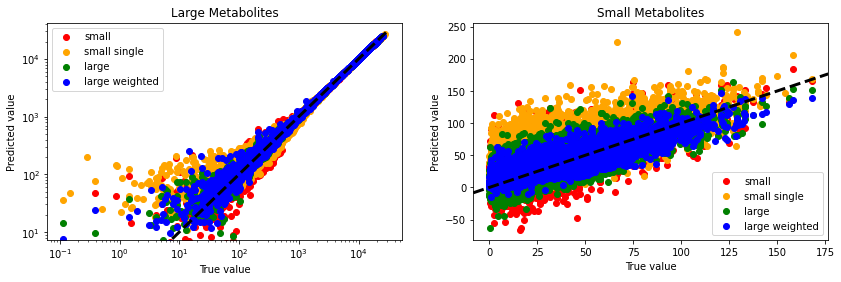

In [222]:
# Plot the scatter

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.scatter(y_val[:, :20], y_pred_small[:, :20], label='small', color='red')
plt.scatter(y_val_single[:20], y_pred_small_single[:20], label='small single', color='orange')
plt.scatter(y_val[:, :20], y_pred_big[:, :20], label='large', color='green')
plt.scatter(y_val[:, :20], y_pred_big_weigthed[:, :20], label='large weighted', color='blue')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("Large Metabolites")
plt.xlabel("True value")
plt.ylabel("Predicted value")

fig.add_subplot(122)
plt.scatter(y_val[:, 35:46], y_pred_small[:, 35:46], label='small', color='red')
plt.scatter(y_val_single[35:46], y_pred_small_single[35:46], label='small single', color='orange')
plt.scatter(y_val[:, 35:46], y_pred_big[:, 35:46], label='large', color='green')
plt.scatter(y_val[:, 35:46], y_pred_big_weigthed[:, 35:46], label='large weighted', color='blue')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.legend()
plt.title("Small Metabolites")
plt.xlabel("True value")
plt.ylabel("Predicted value")

plt.show()

# Interprete MLP

In [268]:
def saliency_map_multi(model, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(spectrum)
        preds = model(spectrum[tf.newaxis, ...])
        preds = tf.squeeze(preds)
        metabolites = [preds[i] for i in range(48)]
    sms = []
    for i in range(48):
        grads = tape.gradient(metabolites[i], spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

def saliency_map_single(models, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    sms = []
    for i in range(48):
        model = models[i]
        with tf.GradientTape() as tape:
            tape.watch(spectrum)
            preds = model(spectrum[tf.newaxis, ...])
            preds = tf.squeeze(preds)
        grads = tape.gradient(preds, spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

In [281]:
df_spectrum_metabolites = []
for i in range(4):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))
for i in range(45, 47):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))

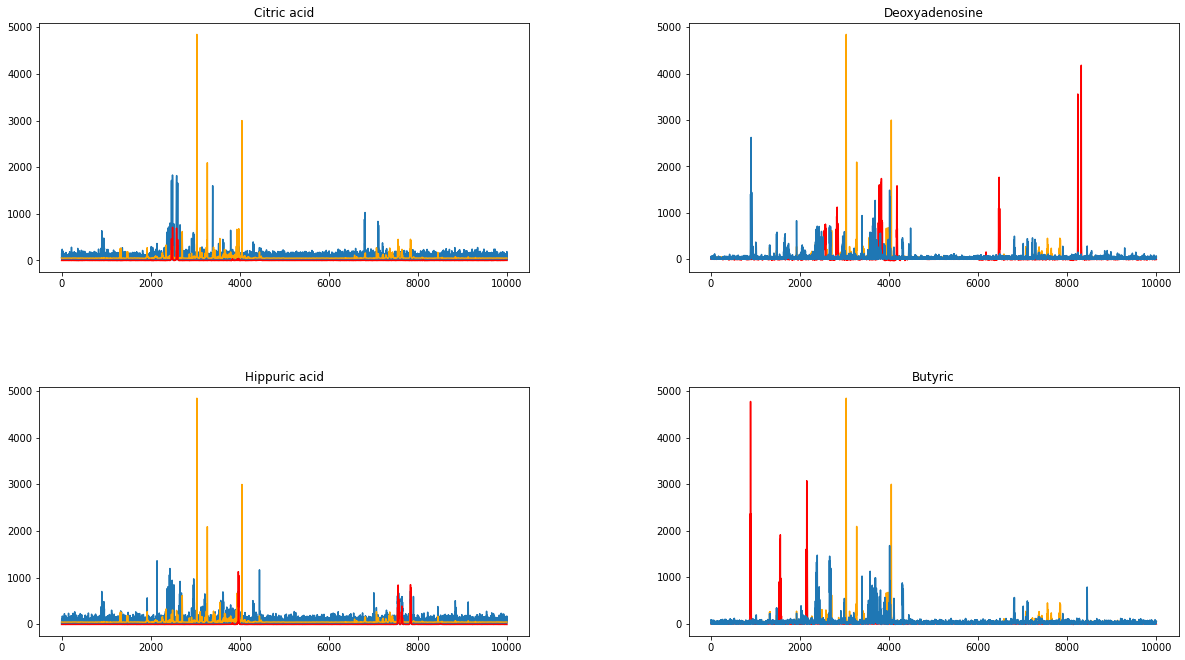

In [313]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_multi(large_multi_mlp, random_spectrum)


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 300)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 300)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20000, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 4000, color='red')
axs[0, 1].plot(sms[45] * 300)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20000, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 10000, color='red')
axs[1, 1].plot(sms[46] * 300)
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))

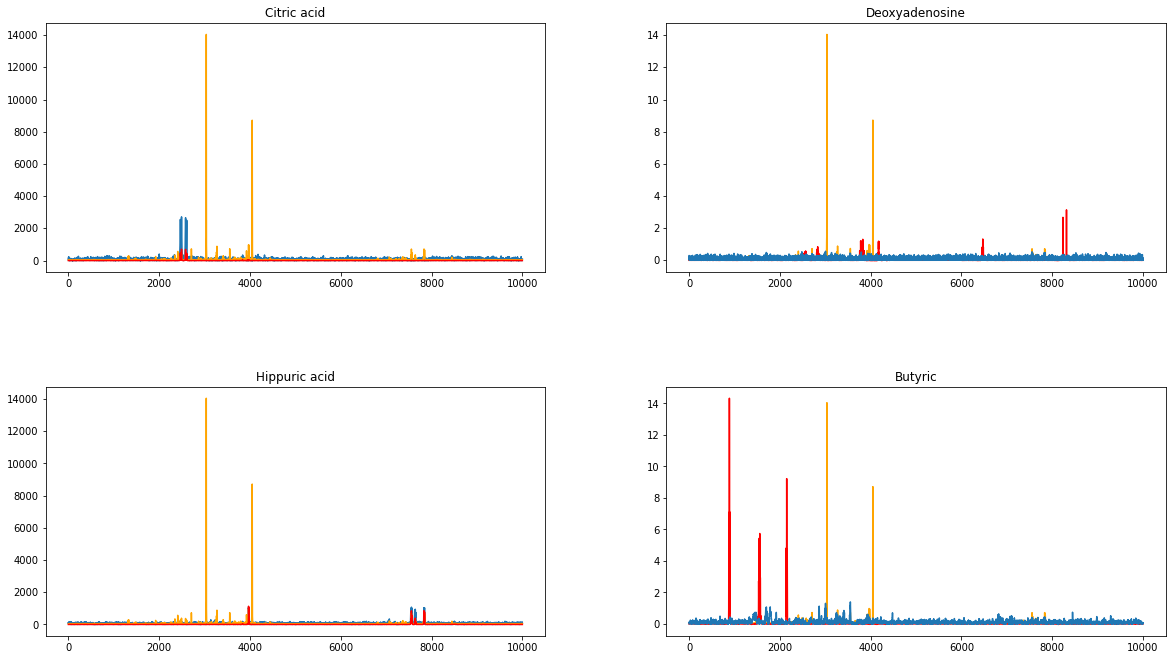

In [309]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_single(xsmall_inde_mlps, random_spectrum)



fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 500)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 500)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 3, color='red')
axs[0, 1].plot(sms[45] * 10)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 30, color='red')
axs[1, 1].plot(sms[46])
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))